# ATLAS OmniFold - Technical Closure and Stress Tests
In this notebook, we use a single a sample to perform a technical closure test (unfolding the sample against itself) and stress tests (unfolding the sample with artificial "stress" weights).

### Standard Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
from __future__ import absolute_import, division, print_function

from ntupleanalysis import *
import math

import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing

import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import energyflow as ef
from energyflow.archs import PFN

/global/home/users/adisurtya/anaconda3/envs/omnifold_gpu/lib/python3.7/site-packages/energyflow/emd.py:915: UserWarning: emd module requires 'wasserstein' or 'pot', both of which are unavailable
  warnings.warn(message)


In [4]:
plot_setup()

In [5]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [6]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'histtype': 'stepfilled','alpha': 0.5, 'density': True}

### Utilities

In [7]:
# from NN (DCTR)
def reweight(model, events):
    f = model.predict(events, batch_size=1000)
    weights = f / (1. - f)
    return np.squeeze(weights)

In [8]:
# Binary crossentropy for classifying two samples with weights
# Weights are "hidden" by zipping in y_true (the labels)

def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))
    
    return K.mean(t_loss)

In [9]:
def sigmoid(x):
    return 1./(1. + np.exp(-x)) 

### Load ROOT files

In [10]:
data_dir = '/clusterfs/ml4hep/bpnachman/OmniFoldATLAS/'

In [11]:
zmumu_0 = uproot.open(
    data_dir + "GridRunOctober/ZjetOmnifold_Oct5_PowhegPythia_mc16e.root"
)['EventTree']

In [12]:
zmumu_0.show()

CutFlow                    (no streamer)              asdtype('>i4')
EventNumber                (no streamer)              asdtype('>i4')
RunNumber                  (no streamer)              asdtype('>i4')
LumiBlock                  (no streamer)              asdtype('>i4')
BCID                       (no streamer)              asdtype('>i4')
NPV                        (no streamer)              asdtype('>i4')
pass                       (no streamer)              asdtype('>i4')
truth_pass                 (no streamer)              asdtype('>i4')
initialWeight              (no streamer)              asdtype('>f4')
pileupWeight               (no streamer)              asdtype('>f4')
genWeight                  (no streamer)              asdtype('>f4')
weight                     (no streamer)              asdtype('>f4')
mu_recoSF                  (no streamer)              asdtype('>f4')
mu_isoSF                   (no streamer)              asdtype('>f4')
mu_TTVASF                  (no str

In [13]:
mybranches_0 = []
for mykey in zmumu_0.keys():
    mybranches_0 += [mykey.decode("utf-8")]

In [14]:
Events_0 = prepare_dataset_table(
    [data_dir + "GridRunOctober/ZjetOmnifold_Oct5_PowhegPythia_mc16e.root"],
    "EventTree",
    branch_list=mybranches_0,
    col_names=mybranches_0,
    entrysteps=10000000,
    outputype=Event_table)

Total number of events:  666677
Events in returned Object:  666677
Loading the data took  63.522698402404785  seconds


### Unpack data

In [15]:
# Event selection

# we should eventually properly account for events that fail one of MC Truth or MC Reco - for now, just ignore them.

mypass_0 = (Events_0.events['m_ll'] >
            81) & (Events_0.events['m_ll'] <
                     101) & (Events_0.events['truth_m_ll'] > 81) & (
                         Events_0.events['truth_m_ll'] <
                         101) & (Events_0.events['pT_ll'] > 165) & (
                             Events_0.events['truth_pT_ll'] >
                             165) & (Events_0.events['y_ll'] < 2.4) & (
                                 Events_0.events['truth_y_ll'] < 2.4)

In [16]:
weights_MC_0 = Events_0.events['weight'][mypass_0]
# standardize
weights_MC_0 = weights_MC_0/np.mean(weights_MC_0)

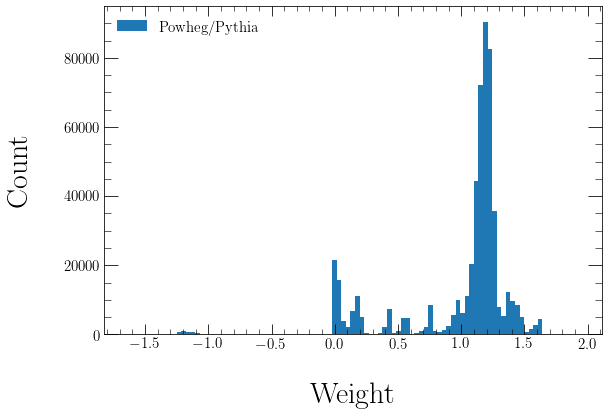

In [17]:
bins = np.linspace(np.min(weights_MC_0),
                   np.max(weights_MC_0), 100)

plt.hist(weights_MC_0, bins = bins, label=r'Powheg/Pythia')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.legend()
plt.show()

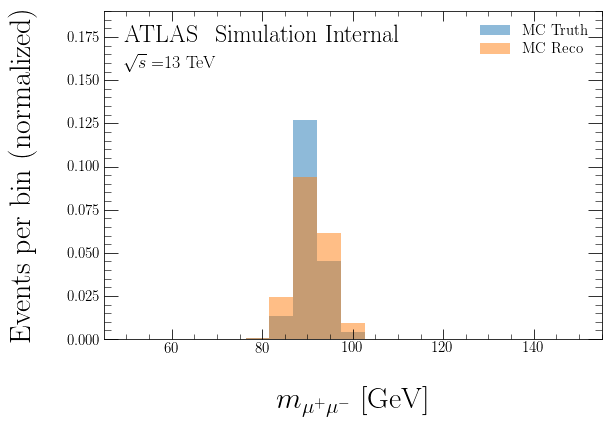

In [18]:
plt.figure()
hT, _, _ = plt.hist(Events_0.events['truth_m_ll'][mypass_0],
                    weights=weights_MC_0,
                    label="MC Truth",
                    bins=np.linspace(50, 150, 20),
                    alpha=0.5, density=True)
hR, _, _ = plt.hist(Events_0.events['m_ll'][mypass_0],
                    weights=weights_MC_0,
                    label="MC Reco",
                    bins=np.linspace(50, 150, 20),
                    alpha=0.5, density=True)

plt.xlabel("$m_{\mu^+\mu^-}$ [GeV]")
plt.ylabel("Events per bin (normalized)")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.legend()
plt.ylim([0, 1.5 * max(max(hT), max(hR))])
plt.show()

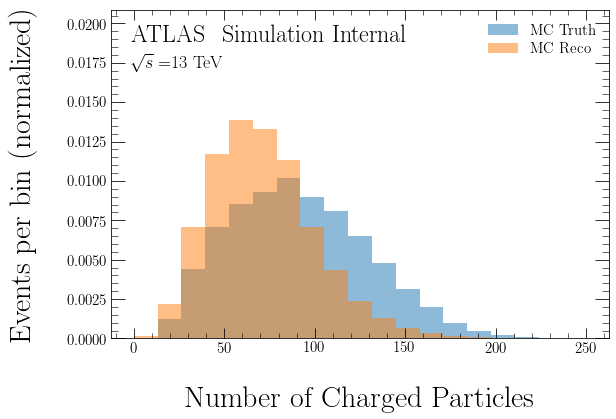

In [19]:
hT, _, _ = plt.hist(Events_0.events['truth_Ntracks'][mypass_0],
                    weights=weights_MC_0,
                    label="MC Truth",
                    alpha=0.5,
                    density=True,
                    bins=np.linspace(0, 250, 20))
hR, _, _ = plt.hist(Events_0.events['Ntracks'][mypass_0],
                    weights=weights_MC_0,
                    label="MC Reco",
                    alpha=0.5,
                    density=True,
                    bins=np.linspace(0, 250, 20))
plt.xlabel("Number of Charged Particles")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.ylabel("Events per bin (normalized)")
plt.legend()
plt.ylim([0, 1.5 * max(max(hT), max(hR))])
plt.show()

### Define UniFold Algorithm

In [20]:
"""    Arguments:
                            
        iterations: number of iterations (integer)
        
        sim_truth: MC Truth observable as Numpy array
                    
        sim_reco: MC Reco observable as Numpy array
                    
        data_reco: Data Reco observable 
                            to be unfolded as Numpy arrays
                            
        weights_MC_sim: (optional) initial MC generator weights for simulation sample
        
        weights_MC_data: (optional) initial MC generator weights for "data" sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    sim_truth to the unfolded distribution of data_reco
        
        model: The model used to calculate those weights
"""


def unifold(iterations,
            sim_truth,
            sim_reco,
            data_reco,
            weights_MC_sim=None,
            weights_MC_data=None):

    if weights_MC_sim is None:
        weights_MC_sim = np.ones(len(sim_truth))

    if weights_MC_data is None:
        weights_MC_data = np.ones(len(data_reco))

    labels_0 = np.zeros(len(sim_truth))
    labels_unknown = np.ones(len(data_reco))

    xvals_1 = np.concatenate((sim_reco, data_reco))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((sim_truth, sim_truth))
    yvals_2 = np.concatenate((labels_0, (labels_0 + 1.)))

    weights = np.empty(shape=(iterations, 2, len(sim_truth)))
    # shape = (iteration, step, event)

    weights_pull = weights_MC_sim
    weights_push = weights_MC_sim

    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify MC Reco (which is reweighted by weights_push) to Data Reco
        # weights reweighted MC Reco --> Data Reco
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, weights_MC_data))
        # actual weights for MC Reco, ones for Data Reco

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        # zip ("hide") the weights with the labels
        Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
        Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)

        model.compile(loss=weighted_binary_crossentropy,
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, sim_reco)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify MC Truth to reweighted MC Truth (which is reweighted by weights_pull)
        # weights MC Truth --> reweighted MC Truth
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((weights_MC_sim, weights_pull))
        # ones for MC Truth, actual weights for (reweighted) MC Truth

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        # zip ("hide") the weights with the labels
        Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
        Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

        model.compile(loss=weighted_binary_crossentropy,
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = weights_MC_sim * reweight(model, sim_truth)
        weights[i, 1:2, :] = weights_push

    return weights, model

### Define MultiFold Algorithm

In [21]:
# Input multiple observables as tuple or list (i.e. sim_truth = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        sim_truth: tuple or list of MC Truth 
                    observables as Numpy arrays
                    
        sim_reco: tuple or list of MC Reco 
                    observables as Numpy arrays
                    
        data_reco: tuple or list of Data Reco 
                    observables to be unfolded 
                    as Numpy arrays
        
        weights_MC_sim: (optional) initial MC generator weights for simulation sample
        
        weights_MC_data: (optional) initial MC generator weights for "data" sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    sim_truth to the unfolded distribution of data_reco
        
        model: The model used to calculate those weights
"""
 

def multifold(num_observables,
              iterations,
              sim_truth,
              sim_reco,
              data_reco,
              weights_MC_sim=None,
              weights_MC_data=None):

    sim_truth = np.stack(sim_truth, axis=1)
    sim_reco = np.stack(sim_reco, axis=1)
    data_reco = np.stack(data_reco, axis=1)
    
    if weights_MC_sim is None:
        weights_MC_sim = np.ones(len(sim_truth)) 
        
    if weights_MC_data is None:
        weights_MC_data = np.ones(len(data_reco))

    labels_0 = np.zeros(len(sim_truth))
    labels_unknown = np.ones(len(data_reco))

    xvals_1 = np.concatenate((sim_reco, data_reco))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((sim_truth, sim_truth))
    yvals_2 = np.concatenate((labels_0, (labels_0+1.)))

    weights = np.empty(shape=(iterations, 2, len(sim_truth)))
    # shape = (iteration, step, event)

    weights_pull = weights_MC_sim
    weights_push = weights_MC_sim

    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify MC Reco (which is reweighted by weights_push) to Data Reco
        # weights reweighted MC Reco --> Data Reco
        print("STEP 1\n")

        weights_1 = np.concatenate(
            (weights_push, weights_MC_data))
        # actual weights for MC Reco, ones for Data Reco

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        # zip ("hide") the weights with the labels
        Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
        Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)

        model.compile(loss=weighted_binary_crossentropy,
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, sim_reco)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify MC Truth to reweighted MC Truth (which is reweighted by weights_pull)
        # weights MC Truth --> reweighted MC Truth
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((weights_MC_sim, weights_pull))
        # ones for MC Truth, actual weights for (reweighted) MC Truth

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        # zip ("hide") the weights with the labels
        Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
        Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

        model.compile(loss=weighted_binary_crossentropy,
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = weights_MC_sim * reweight(model, sim_truth)
        weights[i, 1:2, :] = weights_push

    return weights, model

### Define OmniFold Algorithm

In [22]:
"""    Arguments:
                            
        iterations: number of iterations (integer)
        
        sim_truth: MC Truth events 
                    (i.e. list of events with particles as 
                    (pT, eta, phi, charge)) as zero-padded Numpy array
                    
        sim_truth: MC Reco events 
                    (i.e. list of events with particles as 
                    (pT, eta, phi, charge)) as zero-padded Numpy array
                    
        data_reco: Data Reco events 
                            (i.e. list of events with particles as 
                            (pT, eta, phi, charge))
                            to be unfolded as zero-padded Numpy array 
                            
        
        weights_MC_sim: (optional) initial MC generator weights for simulation sample
        
        weights_MC_data: (optional) initial MC generator weights for data sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    sim_truth to the unfolded distribution of data_reco
        
        model: The model used to calculate those weights
"""


def omnifold(iterations,
             sim_truth,
             sim_reco,
             data_reco,
             weights_MC_sim=None,
             weights_MC_data=None):

    if weights_MC_sim is None:
        weights_MC_sim = np.ones(len(sim_truth))

    if weights_MC_data is None:
        weights_MC_data = np.ones(len(data_reco))

    labels_0 = np.zeros(len(sim_truth))
    labels_unknown = np.ones(len(data_reco))

    xvals_1 = np.concatenate((sim_reco, data_reco))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((sim_truth, sim_truth))
    yvals_2 = np.concatenate((labels_0, (labels_0 + 1.)))

    weights = np.empty(shape=(iterations, 2, len(sim_truth)))
    # shape = (iteration, step, event)

    weights_pull = weights_MC_sim
    weights_push = weights_MC_sim

    # network architecture parameters
    Phi_sizes = (100, 100, 128)
    F_sizes = (100, 100, 100)

    model = PFN(input_dim=4,
                Phi_sizes=Phi_sizes,
                F_sizes=F_sizes,
                latent_dropout=0.2,
                F_dropouts=0.2,
                output_dim=1,
                output_act='sigmoid',
                summary=False)

    earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

    print("Jumpstarting Model\n")
    count = 0
    while count < 20:
        count += 1

        X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(
            xvals_1, yvals_1)

        model.model.compile(loss='binary_crossentropy',
                            optimizer=keras.optimizers.Adam(),
                            metrics=['accuracy'])
        history = model.fit(X_train_1,
                            Y_train_1,
                            epochs=1,
                            batch_size=10000,
                            validation_data=(X_test_1, Y_test_1),
                            verbose=1)
        if (history.history['val_loss'][0] < history.history['loss'][0] -
                0.1) or history.history['val_loss'][0] < 1:
            break
        else:
            K.clear_session()

            model = PFN(input_dim=4,
                        Phi_sizes=Phi_sizes,
                        F_sizes=F_sizes,
                        latent_dropout=0.2,
                        F_dropouts=0.2,
                        output_dim=1,
                        output_act='sigmoid',
                        summary=False)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify MC Reco (which is reweighted by weights_push) to Data Reco
        # weights reweighted MC Reco --> Data Reco
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, weights_MC_data))
        # actual weights for MC Reco, initial MC for Data Reco

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        # zip ("hide") the weights with the labels
        Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
        Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)

        model.model.compile(loss=weighted_binary_crossentropy,
                            optimizer='Adam',
                            metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=1000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, sim_reco)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify MC Truth to reweighted MC Truth (which is reweighted by weights_pull)
        # weights MC Truth --> reweighted MC Truth
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((weights_MC_sim, weights_pull))
        # initial MC for MC Truth, actual weights for (reweighted) MC Truth

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        # zip ("hide") the weights with the labels
        Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
        Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

        model.model.compile(loss=weighted_binary_crossentropy,
                            optimizer='Adam',
                            metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  epochs=200,
                  batch_size=1000,
                  validation_data=(X_test_2, Y_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = weights_MC_sim * reweight(model, sim_truth)
        weights[i, 1:2, :] = weights_push

    return weights, model

# Technical Closure Test
We split the existing sample in half and unfold it against itself.

## UniFold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles separately.

### Setup Datasets

In [23]:
m_ll_sim_truth, m_ll_data_truth, m_ll_sim_reco, m_ll_data_reco = train_test_split(Events_0.events['truth_m_ll'][mypass_0],
                                                                      Events_0.events['m_ll'][mypass_0], 
                                                                      test_size=0.5)

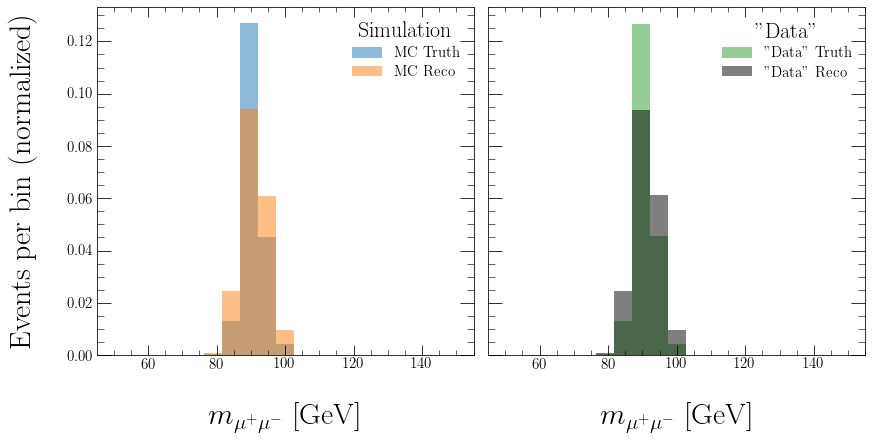

In [24]:
bins = np.linspace(50, 150, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Events per bin (normalized)')
hG0, _, _ = ax[0].hist(m_ll_sim_truth,
                       bins=bins,
                       label='MC Truth',
                       **plot_style_2,
                       color='C0')
hS0, _, _ = ax[0].hist(m_ll_sim_reco,
                       bins=bins,
                       label='MC Reco',
                       **plot_style_2,
                       color='C1')
legend = ax[0].legend(title='Simulation', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[1].hist(m_ll_data_truth,
                       bins=bins,
                       label='"Data" Truth',
                       **plot_style_2,
                       color='C2')
hS1, _, _ = ax[1].hist(m_ll_data_reco,
                       bins=bins,
                       label='"Data" Reco',
                       **plot_style_2,
                       color='k')
legend = ax[1].legend(title='"Data"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-TechnicalClosureTest-UniFold-m_ll-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

In [25]:
Ntracks_sim_truth, Ntracks_data_truth, Ntracks_sim_reco, Ntracks_data_reco = train_test_split(Events_0.events['truth_Ntracks'][mypass_0],
                                                                      Events_0.events['Ntracks'][mypass_0], 
                                                                      test_size=0.5)

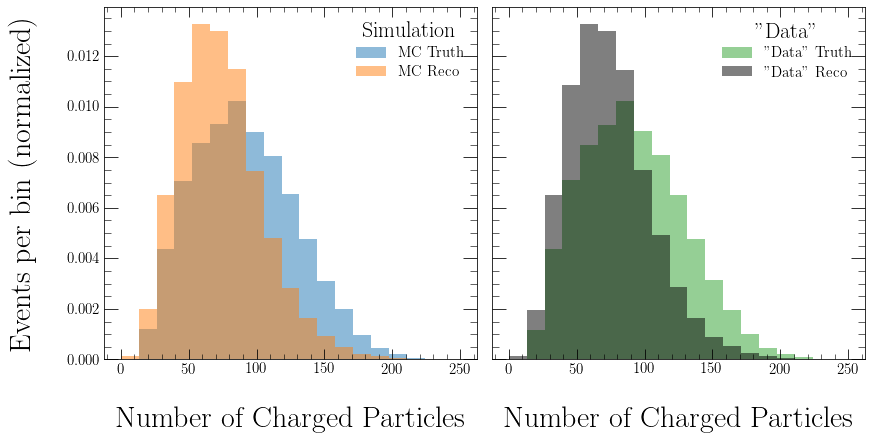

In [26]:
bins = np.linspace(0, 250, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Events per bin (normalized)')
hG0, _, _ = ax[0].hist(Ntracks_sim_truth,
                       bins=bins,
                       label='MC Truth',
                       **plot_style_2,
                       color='C0')
hS0, _, _ = ax[0].hist(Ntracks_sim_reco,
                       bins=bins,
                       label='MC Reco',
                       **plot_style_2,
                       color='C1')
legend = ax[0].legend(title='Simulation', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1].hist(Ntracks_data_truth,
                       bins=bins,
                       label='"Data" Truth',
                       **plot_style_2,
                       color='C2')
hS1, _, _ = ax[1].hist(Ntracks_data_reco,
                       bins=bins,
                       label='"Data" Reco',
                       **plot_style_2,
                       color='k')
legend = ax[1].legend(title='"Data"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-TechnicalClosureTest-UniFold-Ntracks-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

### Unfold $m_{\mu^+\mu^-}$

In [27]:
# z-score standardization of data

scaler_truth = preprocessing.StandardScaler()
scaler_reco = preprocessing.StandardScaler()

scaler_truth.fit(m_ll_sim_truth.reshape(-1,1))
scaler_reco.fit(np.concatenate((m_ll_sim_reco, m_ll_data_reco)).reshape(-1,1))

sim_truth = np.squeeze(scaler_truth.transform(m_ll_sim_truth.reshape(-1,1)))
sim_reco = np.squeeze(scaler_reco.transform(m_ll_sim_reco.reshape(-1,1)))
data_reco = np.squeeze(scaler_reco.transform(m_ll_data_reco.reshape(-1,1)))

In [28]:
weights, _ = unifold(iterations=3,
                     sim_truth=sim_truth,
                     sim_reco=sim_reco,
                     data_reco=data_reco)


ITERATION: 1

STEP 1

Epoch 1/200
42/42 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4883 - val_loss: 0.6932 - val_accuracy: 0.4142
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5067 - val_loss: 0.6932 - val_accuracy: 0.5219
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5470 - val_loss: 0.6932 - val_accuracy: 0.3740
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5202 - val_loss: 0.6933 - val_accuracy: 0.2497
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4856 - val_loss: 0.6932 - val_accuracy: 0.5211
Epoch 6/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5463 - val_loss: 0.6932 - val_accuracy: 0.3067
Epoch 7/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4567 - val_loss: 0.6932 - val_accurac

42/42 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.4587 - val_loss: 0.6939 - val_accuracy: 0.4618
Epoch 25/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.3712 - val_loss: 0.6939 - val_accuracy: 0.4905
Epoch 00025: early stopping

ITERATION: 2

STEP 1

Epoch 1/200
42/42 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4565 - val_loss: 0.6937 - val_accuracy: 0.4143
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.4738 - val_loss: 0.6937 - val_accuracy: 0.4971
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.3843 - val_loss: 0.6937 - val_accuracy: 0.4626
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.3744 - val_loss: 0.6937 - val_accuracy: 0.4812
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.4405 - val_loss: 0.6

Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5000 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 6/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5000 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 7/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.4452 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 8/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5000 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 9/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.4329 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 10/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5000 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 11/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5000 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 12/20

#### Results

ITERATION 1:


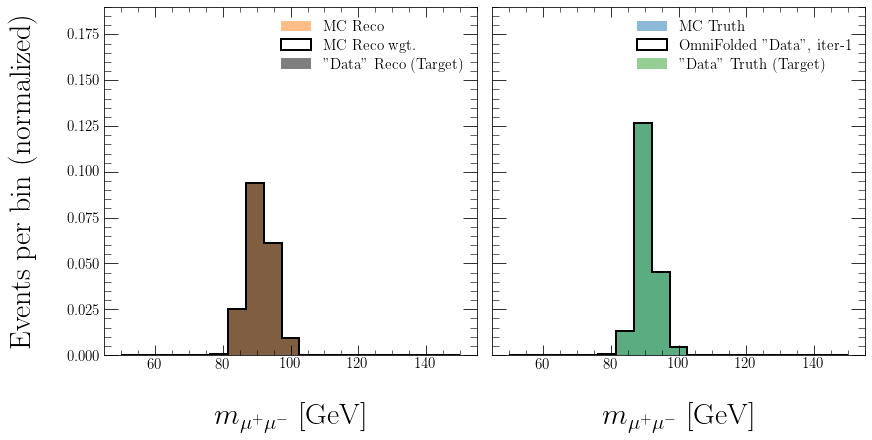

ITERATION 2:


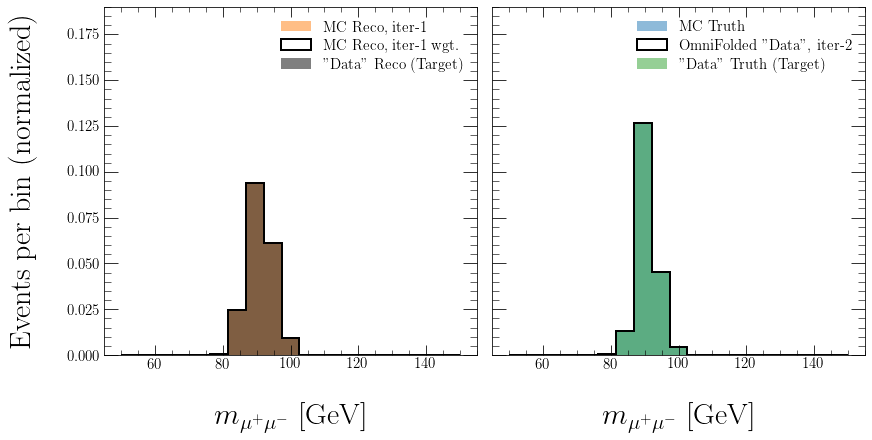

ITERATION 3:


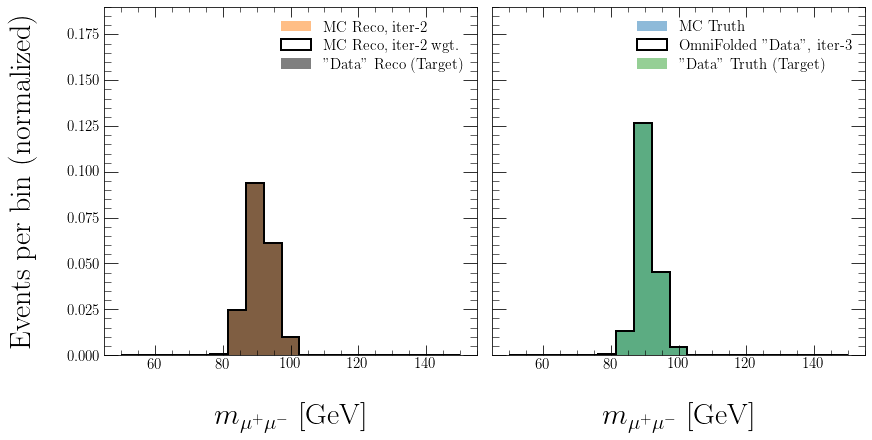

In [29]:
bins = np.linspace(50, 150, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = np.ones(len(m_ll_sim_reco))
        label0 = ''
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    ax[0].hist(m_ll_sim_reco,
               weights=weights_init,
               bins=bins,
               label='MC Reco' + label0,
               **plot_style_2,
               color='C1')

    ax[0].hist(m_ll_sim_reco,
               bins=bins,
               label='MC Reco' + label0 + ' wgt.',
               weights=weights[i, 0, :],
               **plot_style_1)
    hR, _, _ = ax[0].hist(m_ll_data_reco,
                          bins=bins,
                          label='"Data" Reco (Target)',
                          **plot_style_2,
                          color='k')
    ax[0].set_xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend()
    ax[1].hist(m_ll_sim_truth, bins=bins, label=r'MC Truth', **plot_style_2)

    ax[1].hist(m_ll_sim_truth,
               bins=bins,
               label='OmniFolded "Data"' + label1,
               weights=weights[i, 1, :],
               **plot_style_1)
    hT, _, _ = ax[1].hist(m_ll_data_truth,
                          bins=bins,
                          label='"Data" Truth (Target)',
                          **plot_style_2,
                          color='C2')
    ax[1].legend()
    ax[1].set_xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")

    plt.ylim([0, 1.5 * max(max(hT), max(hR))])
    fig.show()
    #     fig.savefig(
    #         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-TechnicalClosureTest-UniFold-m_ll-Iteration{:02}.pdf'
    #         .format(i + 1),
    #         bbox_inches='tight')
    plt.show()

### Unfold Number of Charged Particles

In [30]:
# z-score standardization of data

scaler_truth = preprocessing.StandardScaler()
scaler_reco = preprocessing.StandardScaler()

scaler_truth.fit(Ntracks_sim_truth.reshape(-1,1))
scaler_reco.fit(np.concatenate((Ntracks_sim_reco, Ntracks_data_reco)).reshape(-1,1))

sim_truth = np.squeeze(scaler_truth.transform(Ntracks_sim_truth.reshape(-1,1)))
sim_reco = np.squeeze(scaler_reco.transform(Ntracks_sim_reco.reshape(-1,1)))
data_reco = np.squeeze(scaler_reco.transform(Ntracks_data_reco.reshape(-1,1)))

In [31]:
weights, _ = unifold(iterations=3,
                     sim_truth=sim_truth,
                     sim_reco=sim_reco,
                     data_reco=data_reco)


ITERATION: 1

STEP 1

Epoch 1/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5848 - val_loss: 0.6932 - val_accuracy: 0.7374
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5612 - val_loss: 0.6932 - val_accuracy: 0.7193
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5520 - val_loss: 0.6931 - val_accuracy: 0.4518
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.6052 - val_loss: 0.6931 - val_accuracy: 0.3825
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.5324
Epoch 6/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.4270
Epoch 7/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5134 - val_loss: 0.6931 - val_accurac

42/42 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.4509 - val_loss: 0.6913 - val_accuracy: 0.4543
Epoch 16/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.4912 - val_loss: 0.6913 - val_accuracy: 0.4024
Epoch 17/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.4548 - val_loss: 0.6913 - val_accuracy: 0.3118
Epoch 18/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.4561 - val_loss: 0.6913 - val_accuracy: 0.4834
Epoch 19/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.4273 - val_loss: 0.6913 - val_accuracy: 0.4806
Epoch 00019: early stopping

STEP 2

Epoch 1/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6902 - accuracy: 0.2803 - val_loss: 0.6903 - val_accuracy: 0.3015
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.2915 - val_loss: 0.6902 - val_a

#### Results

ITERATION 1:


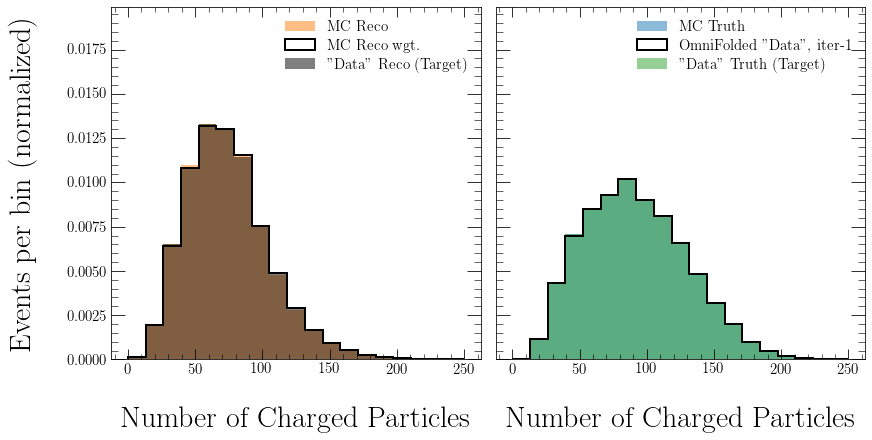

ITERATION 2:


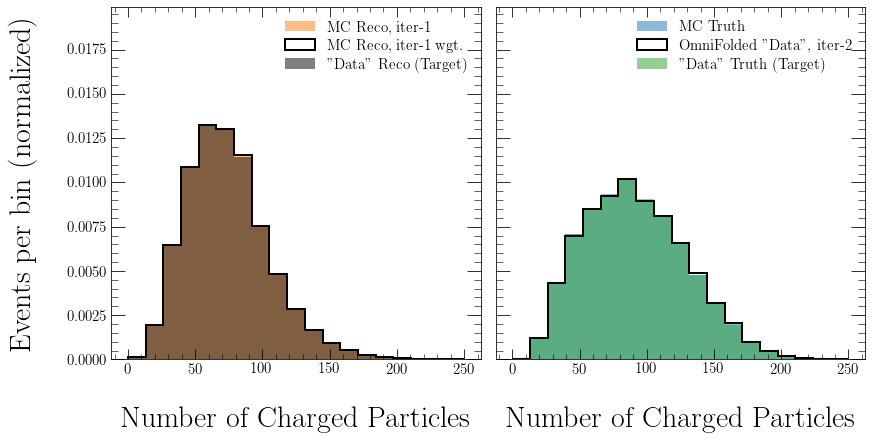

ITERATION 3:


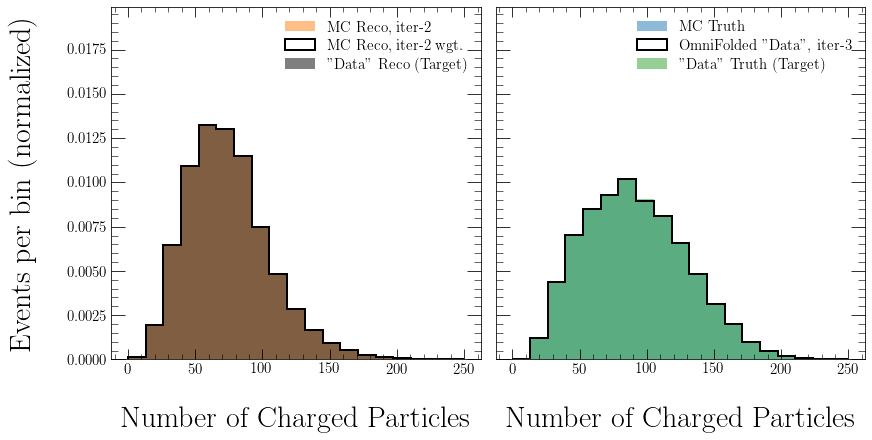

In [32]:
bins = np.linspace(0, 250, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = np.ones(len(Ntracks_sim_reco))
        label0 = ''
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    ax[0].hist(Ntracks_sim_reco,
               weights=weights_init,
               bins=bins,
               label='MC Reco' + label0,
               **plot_style_2,
               color='C1')

    ax[0].hist(Ntracks_sim_reco,
               bins=bins,
               label='MC Reco' + label0 + ' wgt.',
               weights=weights[i, 0, :],
               **plot_style_1)
    hR, _, _ = ax[0].hist(Ntracks_data_reco,
                          bins=bins,
                          label='"Data" Reco (Target)',
                          **plot_style_2,
                          color='k')
    ax[0].set_xlabel(r"Number of Charged Particles")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend()
    ax[1].hist(Ntracks_sim_truth, bins=bins, label=r'MC Truth', **plot_style_2)

    ax[1].hist(Ntracks_sim_truth,
               bins=bins,
               label='OmniFolded "Data"' + label1,
               weights=weights[i, 1, :],
               **plot_style_1)
    hT, _, _ = ax[1].hist(Ntracks_data_truth,
                          bins=bins,
                          label='"Data" Truth (Target)',
                          **plot_style_2,
                          color='C2')
    ax[1].legend()
    ax[1].set_xlabel(r"Number of Charged Particles")

    plt.ylim([0, 1.5 * max(max(hT), max(hR))])
    fig.show()
#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-TechnicalClosureTest-UniFold-Ntracks-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    plt.show()

## MultiFold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles simultaneously.

In [33]:
K.clear_session()

### Setup datasets

In [34]:
m_ll_sim_truth, m_ll_data_truth, m_ll_sim_reco, m_ll_data_reco, Ntracks_sim_truth, Ntracks_data_truth, Ntracks_sim_reco, Ntracks_data_reco = train_test_split(
    Events_0.events['truth_m_ll'][mypass_0],
    Events_0.events['m_ll'][mypass_0],
    Events_0.events['truth_Ntracks'][mypass_0],
    Events_0.events['Ntracks'][mypass_0],
    test_size=0.5)

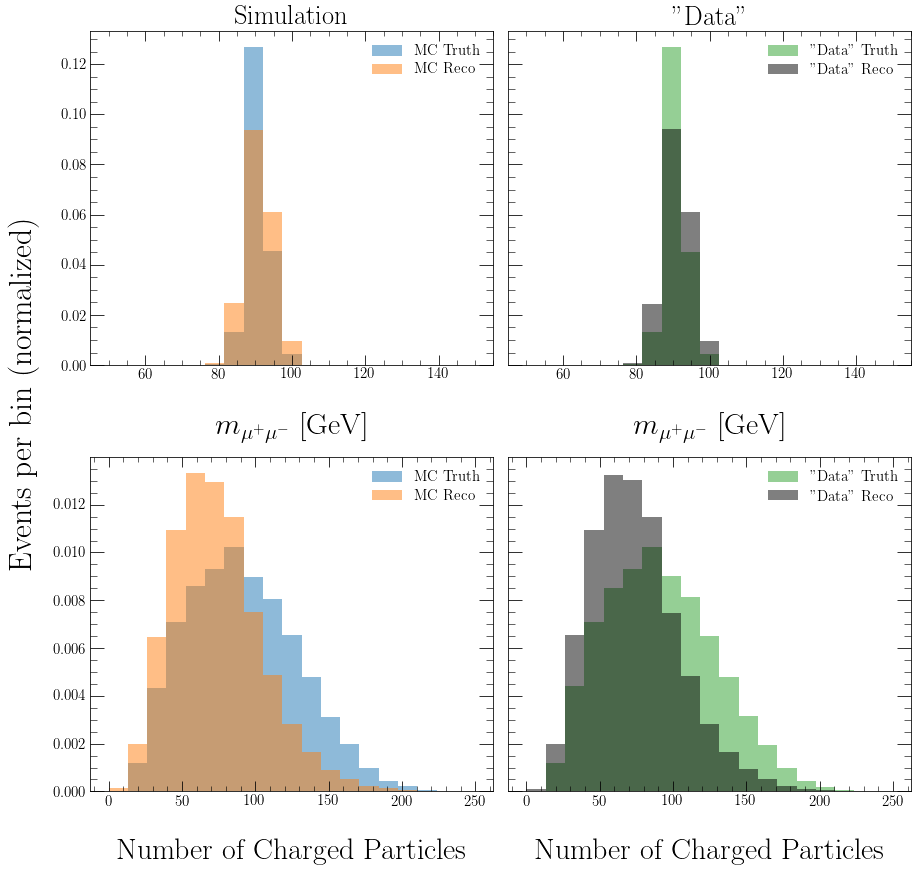

In [35]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 12),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(50, 150, 20)

ax[0, 0].set_title('Simulation')
ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG0, _, _ = ax[0, 0].hist(m_ll_sim_truth,
                          bins=bins,
                          label='MC Truth',
                          **plot_style_2,
                          color='C0')
hS0, _, _ = ax[0, 0].hist(m_ll_sim_reco,
                          bins=bins,
                          label='MC Reco',
                          **plot_style_2,
                          color='C1')
legend = ax[0, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Data"')
ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[0, 1].hist(m_ll_data_truth,
                          bins=bins,
                          label='"Data" Truth',
                          **plot_style_2,
                          color='C2')
hS1, _, _ = ax[0, 1].hist(m_ll_data_reco,
                          bins=bins,
                          label='"Data" Reco',
                          **plot_style_2,
                          color='k')
legend = ax[0, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

bins = np.linspace(0, 250, 20)

ax[1, 0].set_xlabel('Number of Charged Particles')
hG0, _, _ = ax[1, 0].hist(Ntracks_sim_truth,
                          bins=bins,
                          label='MC Truth',
                          **plot_style_2,
                          color='C0')
hS0, _, _ = ax[1, 0].hist(Ntracks_sim_reco,
                          bins=bins,
                          label='MC Reco',
                          **plot_style_2,
                          color='C1')
legend = ax[1, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1, 1].hist(Ntracks_data_truth,
                          bins=bins,
                          label='"Data" Truth',
                          **plot_style_2,
                          color='C2')
hS1, _, _ = ax[1, 1].hist(Ntracks_data_reco,
                          bins=bins,
                          label='"Data" Reco',
                          **plot_style_2,
                          color='k')
legend = ax[1, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.text(-0.05,
         0.55,
         'Events per bin (normalized)',
         va='center',
         rotation='vertical',
         fontsize='x-large')
# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-TechnicalClosureTest-MultiFold-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

### Unfold $m_{\mu^+\mu^-}$ and Number of Charged Particles Simultaneously

In [36]:
num_observables = 2

# z-score standardization

scaler_m_ll_truth = preprocessing.StandardScaler()
scaler_m_ll_reco = preprocessing.StandardScaler()

scaler_m_ll_truth.fit(m_ll_sim_truth.reshape(-1,1))
scaler_m_ll_reco.fit(np.concatenate((m_ll_sim_reco, m_ll_data_reco)).reshape(-1,1))

scaler_Ntracks_truth = preprocessing.StandardScaler()
scaler_Ntracks_reco = preprocessing.StandardScaler()

scaler_Ntracks_truth.fit(Ntracks_sim_truth.reshape(-1,1))
scaler_Ntracks_reco.fit(np.concatenate((Ntracks_sim_reco, Ntracks_data_reco)).reshape(-1,1))

sim_truth = (np.squeeze(scaler_m_ll_truth.transform(m_ll_sim_truth.reshape(-1,1))),
             np.squeeze(scaler_Ntracks_truth.transform(Ntracks_sim_truth.reshape(-1,1))))

sim_reco = (np.squeeze(scaler_m_ll_reco.transform(m_ll_sim_reco.reshape(-1,1))),
             np.squeeze(scaler_Ntracks_reco.transform(Ntracks_sim_reco.reshape(-1,1))))

data_reco = (np.squeeze(scaler_m_ll_reco.transform(m_ll_data_reco.reshape(-1,1))),
                   np.squeeze(scaler_Ntracks_reco.transform(Ntracks_data_reco.reshape(-1,1))))

In [37]:
weights, _ = multifold(num_observables=num_observables,
                       iterations=3,
                       sim_truth=sim_truth,
                       sim_reco=sim_reco,
                       data_reco=data_reco)


ITERATION: 1

STEP 1

Epoch 1/200
42/42 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4791 - val_loss: 0.6932 - val_accuracy: 0.6491
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4876 - val_loss: 0.6932 - val_accuracy: 0.5684
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4893 - val_loss: 0.6933 - val_accuracy: 0.2502
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4510 - val_loss: 0.6932 - val_accuracy: 0.3684
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4710 - val_loss: 0.6932 - val_accuracy: 0.4904
Epoch 6/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4638 - val_loss: 0.6932 - val_accuracy: 0.4329
Epoch 7/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6932 - val_accurac

42/42 [==============================] - 0s 3ms/step - loss: 0.6973 - accuracy: 0.2763 - val_loss: 0.6974 - val_accuracy: 0.2797
Epoch 00011: early stopping

STEP 2

Epoch 1/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6964 - accuracy: 0.4339 - val_loss: 0.6963 - val_accuracy: 0.4815
Epoch 2/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6964 - accuracy: 0.4914 - val_loss: 0.6963 - val_accuracy: 0.4950
Epoch 3/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6963 - accuracy: 0.4788 - val_loss: 0.6963 - val_accuracy: 0.4925
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6964 - accuracy: 0.4846 - val_loss: 0.6963 - val_accuracy: 0.4926
Epoch 5/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6964 - accuracy: 0.4876 - val_loss: 0.6963 - val_accuracy: 0.4845
Epoch 6/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6964 - accuracy: 0.4314 - val_loss: 0.6964 - val_accur

#### Results

ITERATION: 1


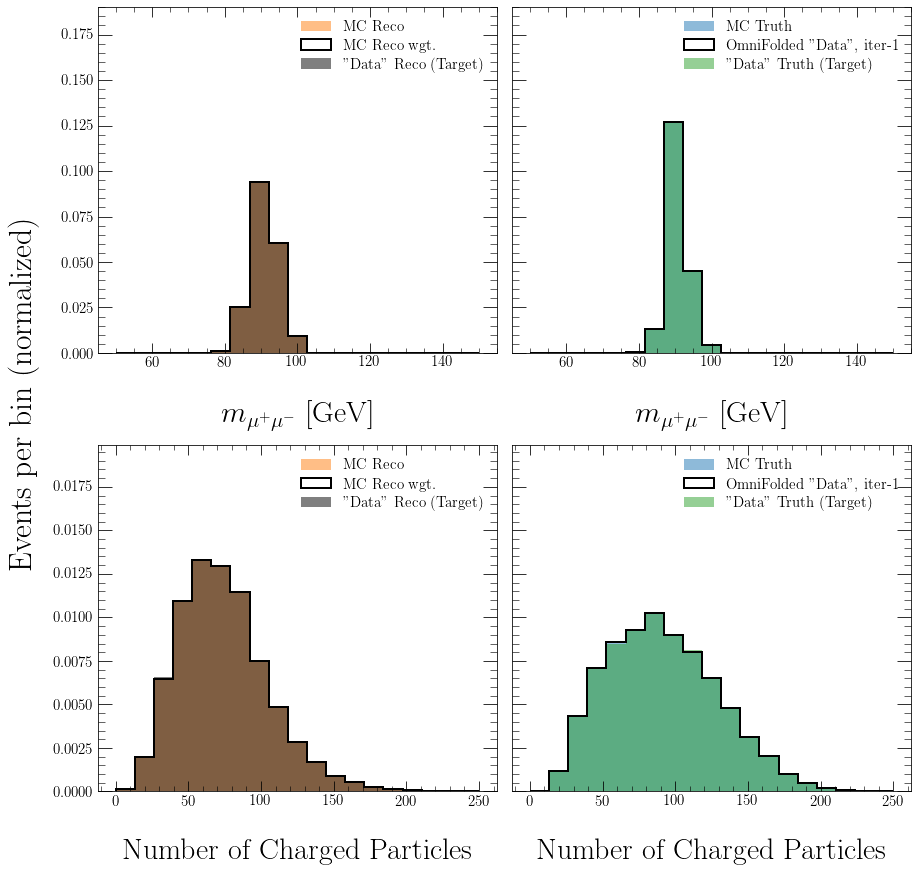

ITERATION: 2


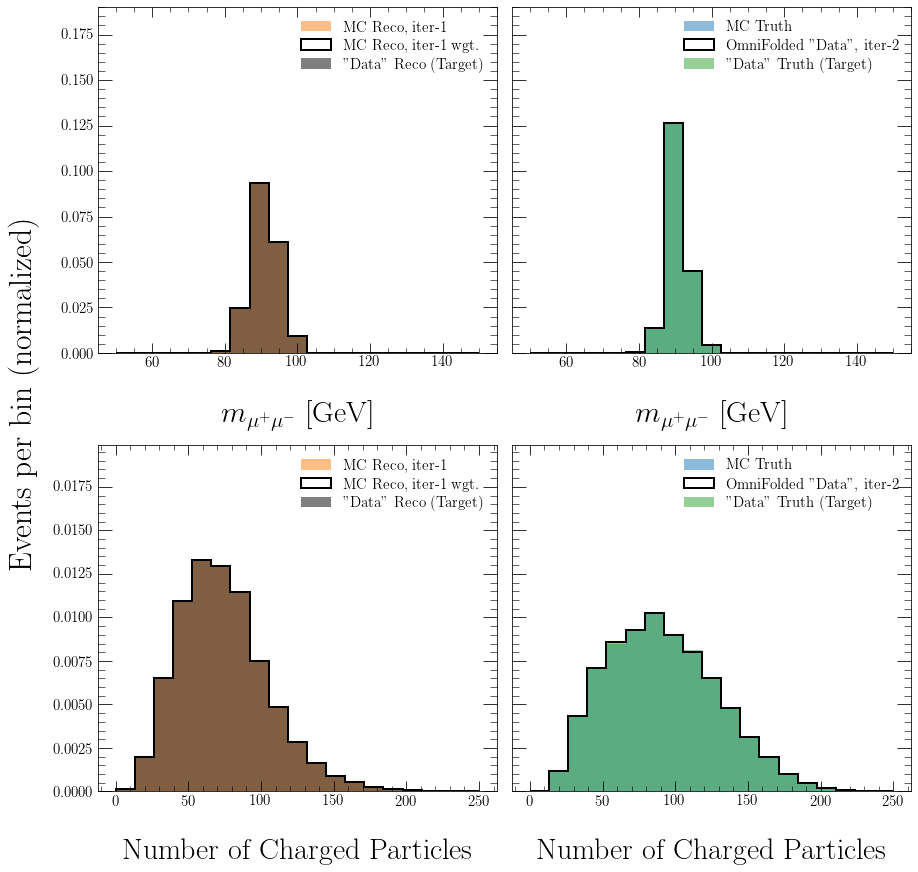

ITERATION: 3


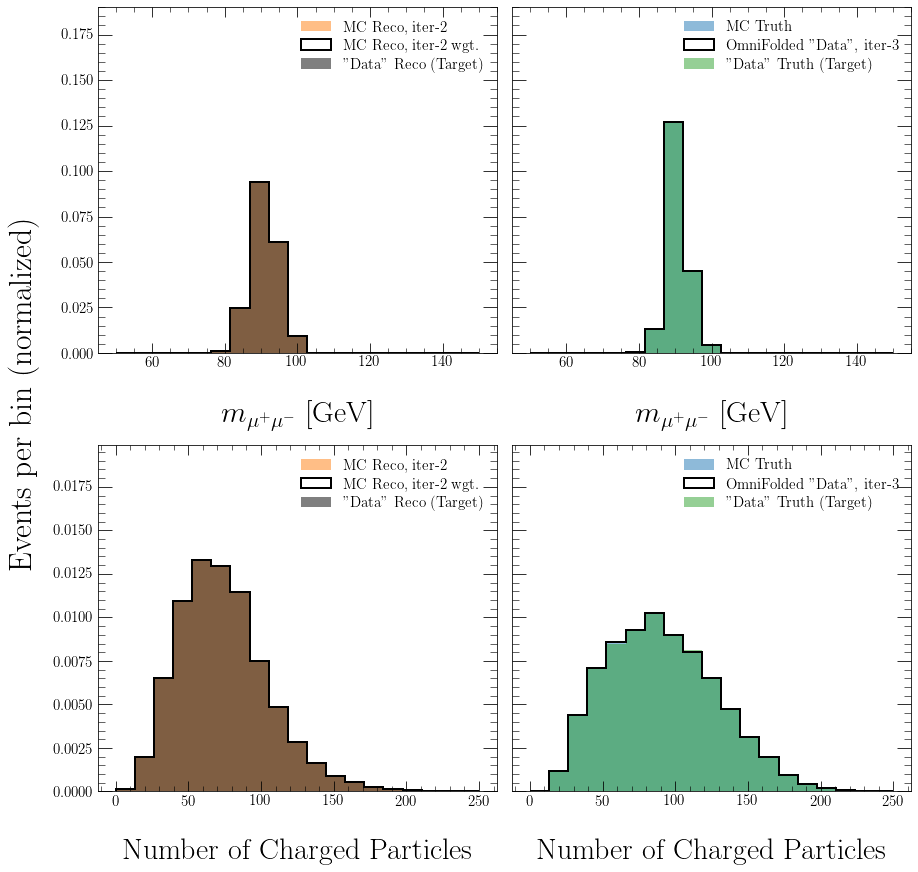

In [38]:
for i in range(len(weights)):
    if i == 0:
        weights_init = np.ones(len(weights[i - 1, 1, :]))
        label0 = ''.format(i)
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(50, 150, 20)

    fig, ax = plt.subplots(num_observables,
                           2,
                           figsize=(12, 12),
                           constrained_layout=True,
                           sharey='row')

    ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0, 0].hist(m_ll_sim_reco,
                  weights=weights_init,
                  bins=bins,
                  label='MC Reco' + label0,
                  **plot_style_2,
                  color='C1')
    ax[0, 0].hist(m_ll_sim_reco,
                  bins=bins,
                  weights=weights[i, 0, :],
                  label='MC Reco' + label0 + ' wgt.',
                  **plot_style_1)

    hR0, _, _ = ax[0, 0].hist(m_ll_data_reco,
                              bins=bins,
                              label=r'"Data" Reco (Target)',
                              **plot_style_2,
                              color='k')
    ax[0, 0].legend(frameon=False)
    

    ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0, 1].hist(m_ll_sim_truth,
                  bins=bins,
                  label=r'MC Truth',
                  **plot_style_2,
                  color='C0')
    ax[0, 1].hist(m_ll_sim_truth,
                  bins=bins,
                  weights=weights[i, 1, :],
                  label='OmniFolded "Data"' + label1,
                  **plot_style_1)

    hT0, _, _ = ax[0, 1].hist(m_ll_data_truth,
                              bins=bins,
                              label=r'"Data" Truth (Target)',
                              **plot_style_2,
                              color='C2')
    ax[0, 0].set_ylim([0, 1.5 * np.max(np.concatenate((hT0, hR0)))])
    ax[0, 1].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1, 0].set_xlabel('Number of Charged Particles')
    ax[1, 0].hist(Ntracks_sim_reco,
                  weights=weights_init,
                  bins=bins,
                  label='MC Reco' + label0,
                  **plot_style_2,
                  color='C1')
    ax[1, 0].hist(Ntracks_sim_reco,
                  bins=bins,
                  weights=weights[i, 1, :],
                  label='MC Reco' + label0 + ' wgt.',
                  **plot_style_1)
    hR1, _, _ = ax[1, 0].hist(Ntracks_data_reco,
                              bins=bins,
                              label=r'"Data" Reco (Target)',
                              **plot_style_2,
                              color='k')
    ax[1, 0].legend(frameon=False)

    ax[1, 1].set_xlabel('Number of Charged Particles')
    ax[1, 1].hist(Ntracks_sim_truth,
                  bins=bins,
                  label=r'MC Truth',
                  **plot_style_2,
                  color='C0')
    ax[1, 1].hist(Ntracks_sim_truth,
                  bins=bins,
                  weights=weights[i, 1, :],
                  label='OmniFolded "Data"' + label1,
                  **plot_style_1)
    hT1, _, _ = ax[1, 1].hist(Ntracks_data_truth,
                              bins=bins,
                              label=r'"Data" Truth (Target)',
                              **plot_style_2,
                              color='C2')
    ax[1, 1].legend(frameon=False)

    fig.text(-0.05,
             0.55,
             'Events per bin (normalized)',
             va='center',
             rotation='vertical',
             fontsize='x-large')

    ax[1, 0].set_ylim([0, 1.5 * np.max(np.concatenate((hT1, hR1)))])

    #     fig.savefig(
    #         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-TechnicalClosureTest-MultiFold-Iteration{:02}.pdf'
    #         .format(i + 1),
    #         bbox_inches='tight')
    fig.show()
    plt.show()

# Stress Test A

Stress weights are nonrandom.

For each observable $x$ in the "unknown" sample, the weight is given roughly by $w \propto x^n$ for some $n$.

## UniFold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles separately.

### Setup Datasets

In [39]:
m_ll_sim_truth, m_ll_data_truth, m_ll_sim_reco, m_ll_data_reco = train_test_split(Events_0.events['truth_m_ll'][mypass_0],
                                                                      Events_0.events['m_ll'][mypass_0], 
                                                                      test_size=0.5)

In [40]:
scaler_m_ll = preprocessing.StandardScaler()

scaler_m_ll.fit(np.concatenate((m_ll_sim_truth, m_ll_data_truth)).reshape(-1,1))

weight_m_ll_seed = np.squeeze(scaler_m_ll.transform(m_ll_data_truth.reshape(-1,1)))

In [41]:
weights_m_ll_stress = -np.min(weight_m_ll_seed) + weight_m_ll_seed
weights_m_ll_stress = (weights_m_ll_stress)**2
weights_m_ll_stress = weights_m_ll_stress/np.mean(weights_m_ll_stress)

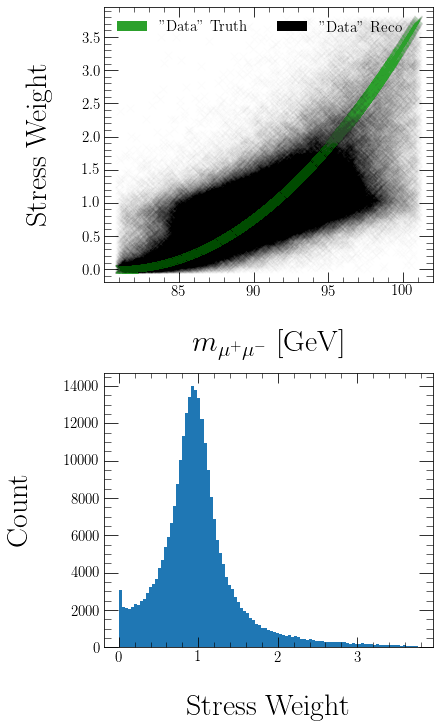

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10), constrained_layout=True)

ax[0].plot(m_ll_data_reco,
           weights_m_ll_stress,
           'x',
           alpha=0.01,
           label='Data',
           color='k')
ax[0].plot(m_ll_data_truth,
           weights_m_ll_stress,
           'x',
           alpha=0.01,
           label='Truth',
           color='C2')

ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Stress Weight')
handles = [Patch(facecolor='C2'), Patch(facecolor='k')]
labels = ['"Data" Truth', '"Data" Reco']
ax[0].legend(handles, labels, ncol=2)

ax[1].hist(weights_m_ll_stress,
           bins=np.linspace(np.min(weights_m_ll_stress),
                            np.max(weights_m_ll_stress), 100))
ax[1].set_xlabel('Stress Weight')
ax[1].set_ylabel('Count')

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-UniFold-m_ll-StressWeights.png',
#     bbox_inches='tight')

fig.show()

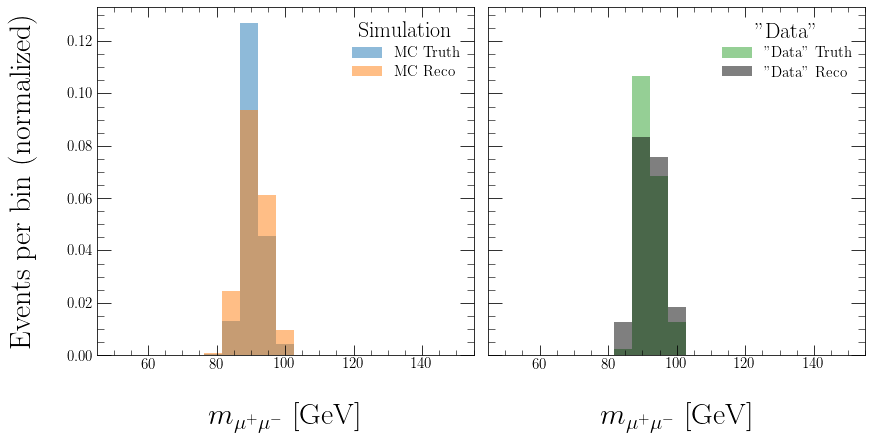

In [43]:
bins = np.linspace(50, 150, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Events per bin (normalized)')
hG0, _, _ = ax[0].hist(m_ll_sim_truth,
                       bins=bins,
                       label='MC Truth',
                       **plot_style_2,
                       color='C0')
hS0, _, _ = ax[0].hist(m_ll_sim_reco,
                       bins=bins,
                       label='MC Reco',
                       **plot_style_2,
                       color='C1')
legend = ax[0].legend(title='Simulation', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[1].hist(m_ll_data_truth,
                       weights=weights_m_ll_stress,
                       bins=bins,
                       label='"Data" Truth',
                       **plot_style_2,
                       color='C2')
hS1, _, _ = ax[1].hist(m_ll_data_reco,
                       weights=weights_m_ll_stress,
                       bins=bins,
                       label='"Data" Reco',
                       **plot_style_2,
                       color='k')
legend = ax[1].legend(title='"Data"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-UniFold-m_ll-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

In [44]:
Ntracks_sim_truth, Ntracks_data_truth, Ntracks_sim_reco, Ntracks_data_reco = train_test_split(
    Events_0.events['truth_Ntracks'][mypass_0],
    Events_0.events['Ntracks'][mypass_0],
    test_size=0.5)

In [45]:
scaler_Ntracks = preprocessing.StandardScaler()

scaler_Ntracks.fit(np.concatenate((Ntracks_sim_truth, Ntracks_data_truth)).reshape(-1,1))

weight_Ntracks_seed = np.squeeze(scaler_Ntracks.transform(Ntracks_data_truth.reshape(-1,1)))

In [46]:
weights_Ntracks_stress = -np.min(weight_Ntracks_seed) + weight_Ntracks_seed
weights_Ntracks_stress = (weights_Ntracks_stress)**2
weights_Ntracks_stress = weights_Ntracks_stress/np.mean(weights_Ntracks_stress)

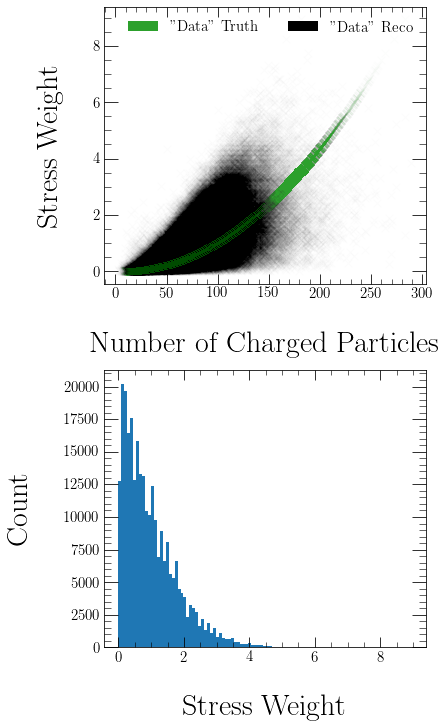

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10), constrained_layout=True)

ax[0].plot(Ntracks_data_reco, weights_Ntracks_stress,
           'x',
           alpha=0.01,
           label='Data',
           color='k')
ax[0].plot(Ntracks_data_truth, weights_Ntracks_stress,
           'x',
           alpha=0.01,
           label='Truth',
           color='C2')

ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Stress Weight')
handles = [Patch(facecolor='C2'), Patch(facecolor='k')]
labels = ['"Data" Truth', '"Data" Reco']
ax[0].legend(handles, labels, ncol=2)

ax[1].hist(weights_Ntracks_stress,
           bins=np.linspace(np.min(weights_Ntracks_stress),
                            np.max(weights_Ntracks_stress), 100))
ax[1].set_xlabel('Stress Weight')
ax[1].set_ylabel('Count')

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-UniFold-Ntracks-StressWeights.png',
#     bbox_inches='tight')

fig.show()

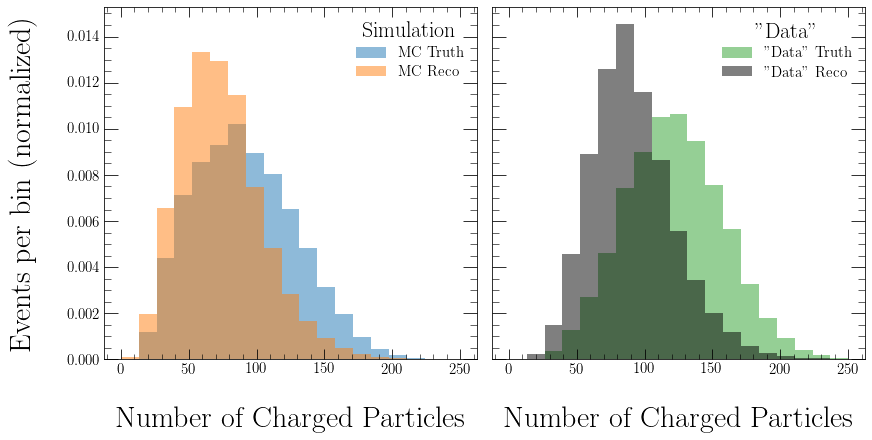

In [48]:
bins = np.linspace(0, 250, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Events per bin (normalized)')
hG0, _, _ = ax[0].hist(Ntracks_sim_truth,
                       bins=bins,
                       label='MC Truth',
                       **plot_style_2,
                       color='C0')
hS0, _, _ = ax[0].hist(Ntracks_sim_reco,
                       bins=bins,
                       label='MC Reco',
                       **plot_style_2,
                       color='C1')
legend = ax[0].legend(title='Simulation', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1].hist(Ntracks_data_truth,
                       weights=weights_Ntracks_stress,
                       bins=bins,
                       label='"Data" Truth',
                       **plot_style_2,
                       color='C2')
hS1, _, _ = ax[1].hist(Ntracks_data_reco,
                       weights=weights_Ntracks_stress,
                       bins=bins,
                       label='"Data" Reco',
                       **plot_style_2,
                       color='k')
legend = ax[1].legend(title='"Data"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-UniFold-Ntracks-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

### Unfold $m_{\mu^+\mu^-}$

In [49]:
# z-score standardization

scaler_truth = preprocessing.StandardScaler()
scaler_reco = preprocessing.StandardScaler()

scaler_truth.fit(m_ll_sim_truth.reshape(-1,1))
scaler_reco.fit(np.concatenate((m_ll_sim_reco, m_ll_data_reco)).reshape(-1,1))

sim_truth = np.squeeze(scaler_truth.transform(m_ll_sim_truth.reshape(-1,1)))
sim_reco = np.squeeze(scaler_reco.transform(m_ll_sim_reco.reshape(-1,1)))
data_reco = np.squeeze(scaler_reco.transform(m_ll_data_reco.reshape(-1,1)))

In [50]:
weights, _ = unifold(iterations=10,
                     sim_truth=sim_truth,
                     sim_reco=sim_reco,
                     data_reco=data_reco,
                     weights_MC_data=weights_m_ll_stress)


ITERATION: 1

STEP 1

Epoch 1/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6808 - accuracy: 0.3658 - val_loss: 0.6785 - val_accuracy: 0.3682
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6789 - accuracy: 0.3569 - val_loss: 0.6785 - val_accuracy: 0.3482
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6789 - accuracy: 0.3520 - val_loss: 0.6783 - val_accuracy: 0.3515
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6788 - accuracy: 0.3526 - val_loss: 0.6784 - val_accuracy: 0.3502
Epoch 5/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6788 - accuracy: 0.3552 - val_loss: 0.6783 - val_accuracy: 0.3490
Epoch 6/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6788 - accuracy: 0.3537 - val_loss: 0.6783 - val_accuracy: 0.3582
Epoch 7/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6787 - accuracy: 0.3555 - val_loss: 0.6783 - val_accurac

42/42 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.2497 - val_loss: 0.6834 - val_accuracy: 0.2499
Epoch 8/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.2496 - val_loss: 0.6834 - val_accuracy: 0.2500
Epoch 9/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.2497 - val_loss: 0.6834 - val_accuracy: 0.2499
Epoch 10/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.2498 - val_loss: 0.6834 - val_accuracy: 0.2499
Epoch 11/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.2497 - val_loss: 0.6834 - val_accuracy: 0.2497
Epoch 12/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.2498 - val_loss: 0.6834 - val_accuracy: 0.2499
Epoch 13/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.2496 - val_loss: 0.6834 - val_accuracy: 0.2499
Epoch 00013: early st

Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.2495 - val_loss: 0.6908 - val_accuracy: 0.2496
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.2498 - val_loss: 0.6908 - val_accuracy: 0.2495
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.2498 - val_loss: 0.6908 - val_accuracy: 0.2496
Epoch 6/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.2499 - val_loss: 0.6908 - val_accuracy: 0.2496
Epoch 7/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.2497 - val_loss: 0.6908 - val_accuracy: 0.2495
Epoch 8/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.2498 - val_loss: 0.6908 - val_accuracy: 0.2496
Epoch 9/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.2497 - val_loss: 0.6908 - val_accuracy: 0.2495
Epoch 10/200


42/42 [==============================] - 0s 3ms/step - loss: 0.6624 - accuracy: 0.3500 - val_loss: 0.6628 - val_accuracy: 0.3513
Epoch 12/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6624 - accuracy: 0.3495 - val_loss: 0.6628 - val_accuracy: 0.3568
Epoch 13/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6624 - accuracy: 0.3515 - val_loss: 0.6627 - val_accuracy: 0.3460
Epoch 14/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6624 - accuracy: 0.3481 - val_loss: 0.6627 - val_accuracy: 0.3535
Epoch 15/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6624 - accuracy: 0.3510 - val_loss: 0.6628 - val_accuracy: 0.3535
Epoch 00015: early stopping

ITERATION: 6

STEP 1

Epoch 1/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.2495 - val_loss: 0.6881 - val_accuracy: 0.2504
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.2495 - val_loss: 

Epoch 9/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.3522 - val_loss: 0.6618 - val_accuracy: 0.3506
Epoch 10/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.3524 - val_loss: 0.6617 - val_accuracy: 0.3510
Epoch 11/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.3531 - val_loss: 0.6618 - val_accuracy: 0.3496
Epoch 12/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.3524 - val_loss: 0.6618 - val_accuracy: 0.3523
Epoch 13/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.3512 - val_loss: 0.6618 - val_accuracy: 0.3522
Epoch 14/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.3524 - val_loss: 0.6618 - val_accuracy: 0.3491
Epoch 15/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.3540 - val_loss: 0.6617 - val_accuracy: 0.3496
Epoch 0

Epoch 7/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.3543 - val_loss: 0.6619 - val_accuracy: 0.3549
Epoch 8/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.3538 - val_loss: 0.6620 - val_accuracy: 0.3538
Epoch 9/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.3546 - val_loss: 0.6621 - val_accuracy: 0.3512
Epoch 10/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.3535 - val_loss: 0.6620 - val_accuracy: 0.3570
Epoch 11/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.3559 - val_loss: 0.6620 - val_accuracy: 0.3566
Epoch 12/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.3542 - val_loss: 0.6620 - val_accuracy: 0.3536
Epoch 13/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.3548 - val_loss: 0.6620 - val_accuracy: 0.3568
Epoch 14/

#### Results 

ITERATION 1:


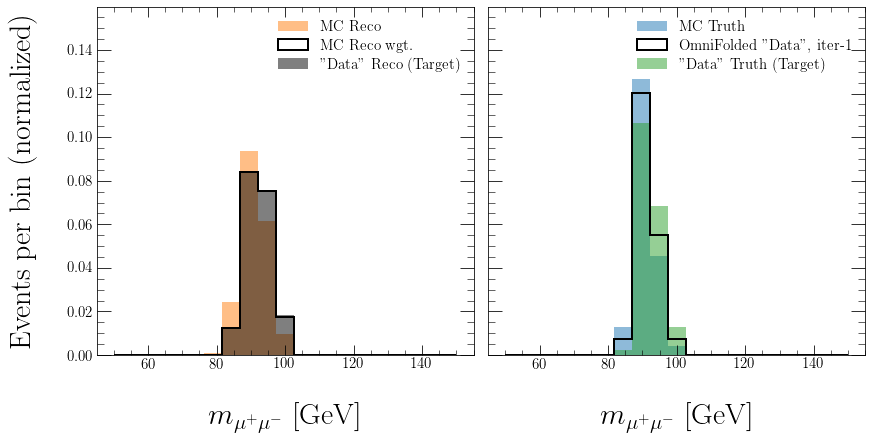

ITERATION 2:


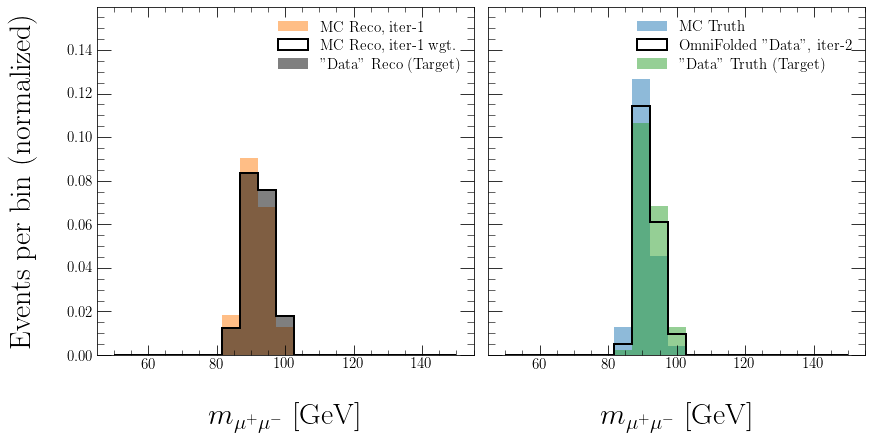

ITERATION 3:


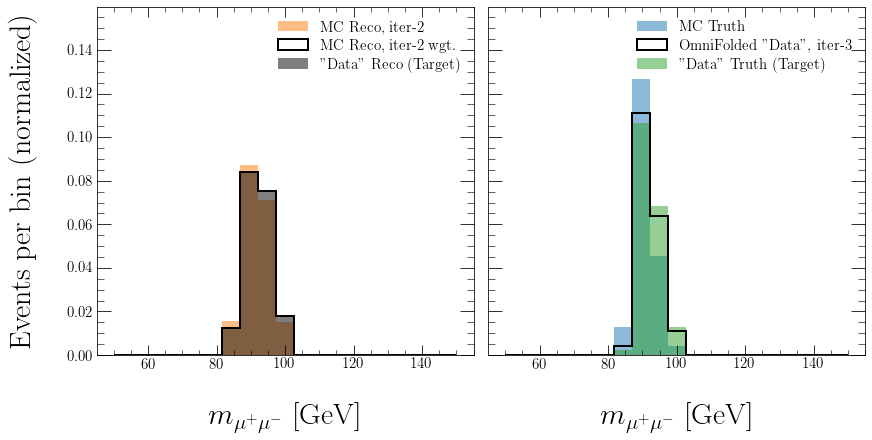

ITERATION 4:


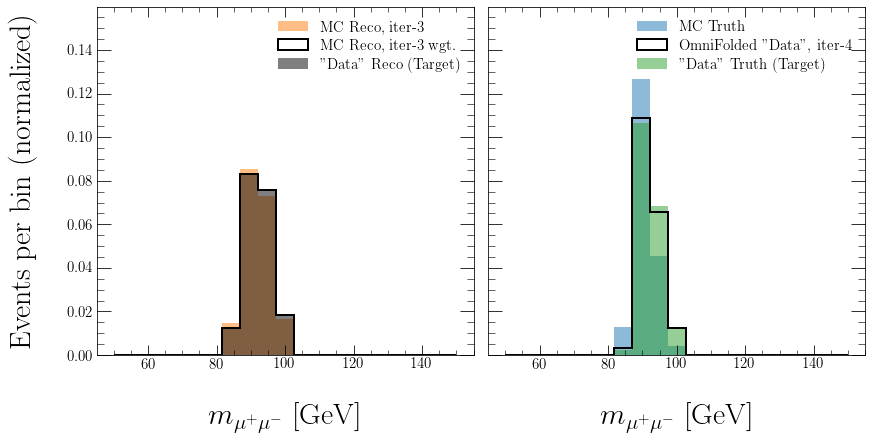

ITERATION 5:


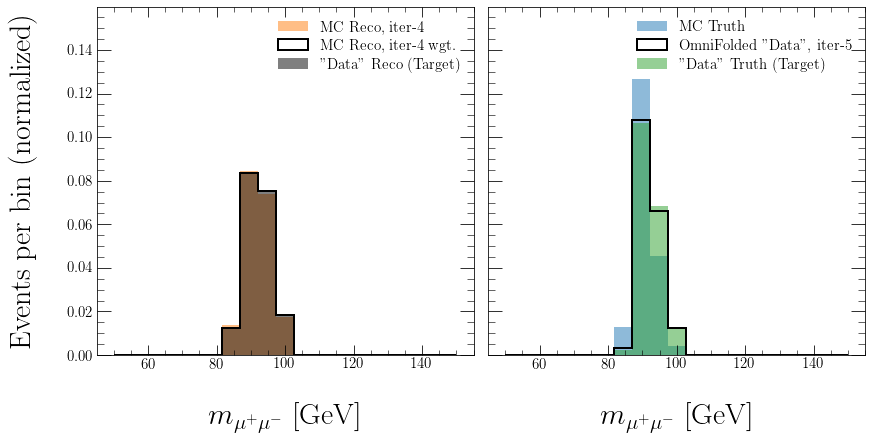

ITERATION 6:


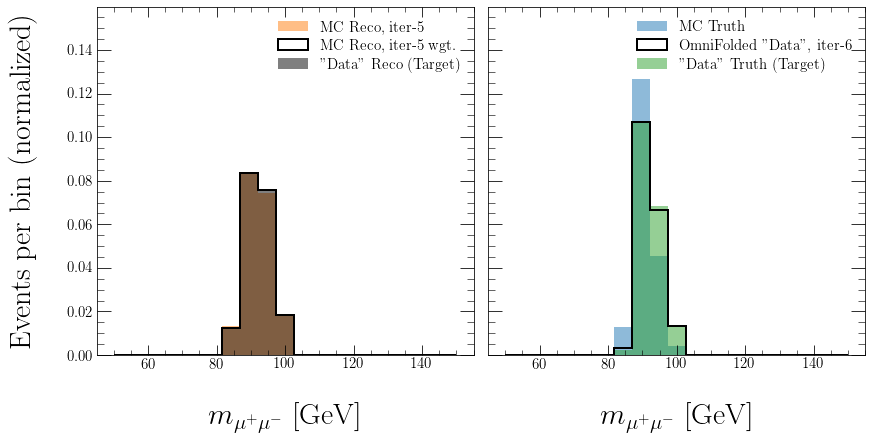

ITERATION 7:


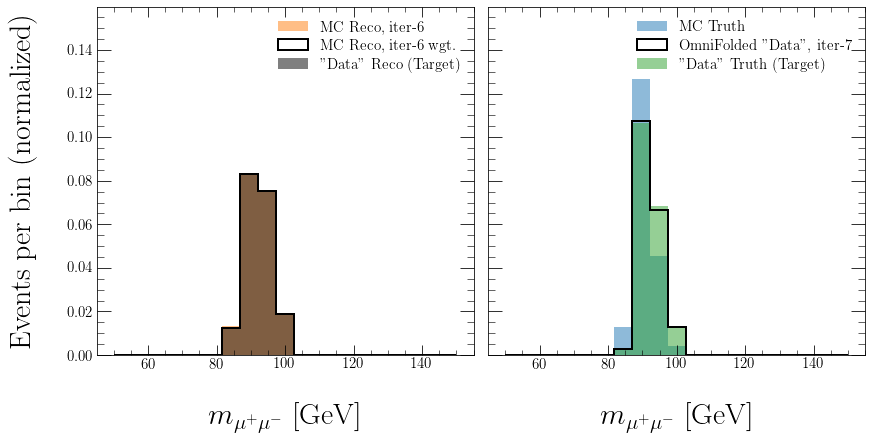

ITERATION 8:


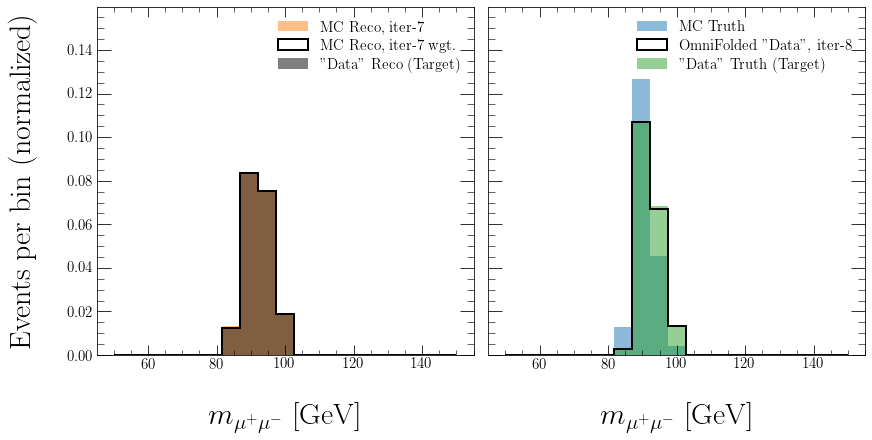

ITERATION 9:


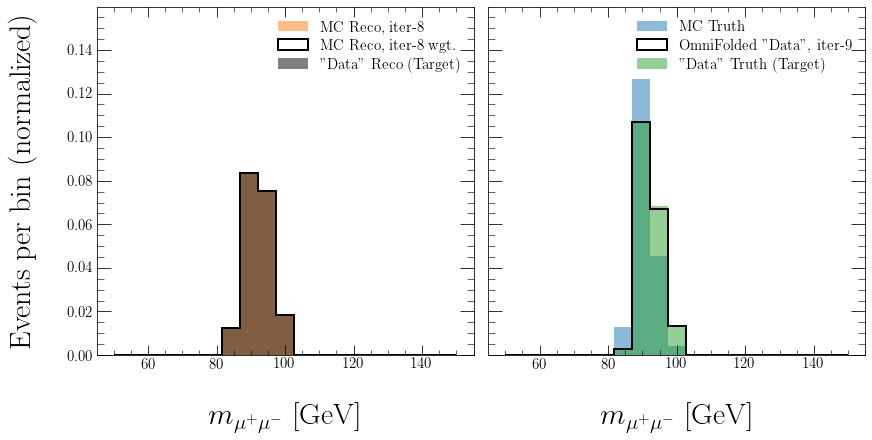

ITERATION 10:


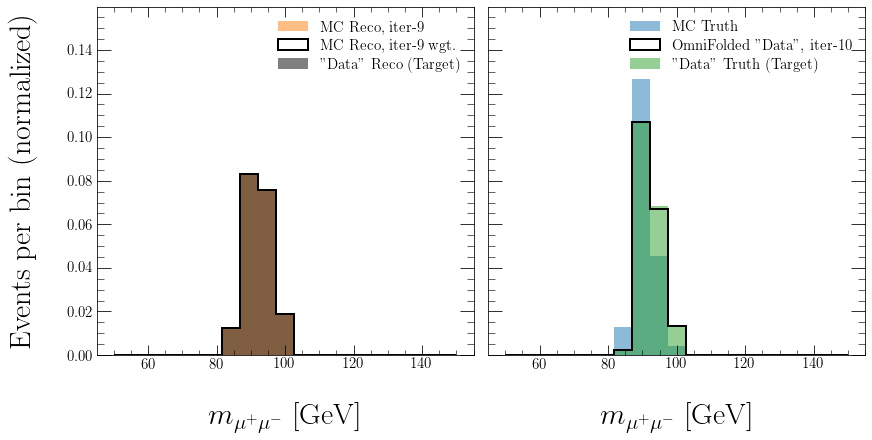

In [51]:
bins = np.linspace(50, 150, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = np.ones(len(m_ll_sim_reco))
        label0 = ''
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    ax[0].hist(m_ll_sim_reco,
               weights=weights_init,
               bins=bins,
               label='MC Reco' + label0,
               **plot_style_2,
               color='C1')

    ax[0].hist(m_ll_sim_reco,
               bins=bins,
               label='MC Reco' + label0 + ' wgt.',
               weights=weights[i, 0, :],
               **plot_style_1)
    hR, _, _ = ax[0].hist(m_ll_data_reco,
                          weights=weights_m_ll_stress,
                          bins=bins,
                          label='"Data" Reco (Target)',
                          **plot_style_2,
                          color='k')
    ax[0].set_xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend()
    ax[1].hist(m_ll_sim_truth, bins=bins, label=r'MC Truth', **plot_style_2)

    ax[1].hist(m_ll_sim_truth,
               bins=bins,
               label='OmniFolded "Data"' + label1,
               weights=weights[i, 1, :],
               **plot_style_1)
    hT, _, _ = ax[1].hist(m_ll_data_truth,
                          weights=weights_m_ll_stress,
                          bins=bins,
                          label='"Data" Truth (Target)',
                          **plot_style_2,
                          color='C2')
    ax[1].legend()
    ax[1].set_xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")

    plt.ylim([0, 1.5 * max(max(hT), max(hR))])
    fig.show()
#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-UniFold-m_ll-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    plt.show()

### Unfold Number of Charged Particles

In [52]:
# z-score standardization

scaler_truth = preprocessing.StandardScaler()
scaler_reco = preprocessing.StandardScaler()

scaler_truth.fit(Ntracks_sim_truth.reshape(-1,1))
scaler_reco.fit(np.concatenate((Ntracks_sim_reco, Ntracks_data_reco)).reshape(-1,1))

sim_truth = np.squeeze(scaler_truth.transform(Ntracks_sim_truth.reshape(-1,1)))
sim_reco = np.squeeze(scaler_reco.transform(Ntracks_sim_reco.reshape(-1,1)))
data_reco = np.squeeze(scaler_reco.transform(Ntracks_data_reco.reshape(-1,1)))

In [53]:
weights, _ = unifold(iterations=10,
                     sim_truth=sim_truth,
                     sim_reco=sim_reco,
                     data_reco=data_reco,
                     weights_MC_data=weights_Ntracks_stress)


ITERATION: 1

STEP 1

Epoch 1/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6613 - accuracy: 0.3591 - val_loss: 0.6503 - val_accuracy: 0.3587
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.3704 - val_loss: 0.6487 - val_accuracy: 0.3722
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.3716 - val_loss: 0.6485 - val_accuracy: 0.3689
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.3699 - val_loss: 0.6484 - val_accuracy: 0.3654
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.3672 - val_loss: 0.6483 - val_accuracy: 0.3654
Epoch 6/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.3667 - val_loss: 0.6485 - val_accuracy: 0.3689
Epoch 7/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.3665 - val_loss: 0.6484 - val_accurac

42/42 [==============================] - 0s 4ms/step - loss: 0.6750 - accuracy: 0.2508 - val_loss: 0.6756 - val_accuracy: 0.2495
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.2506 - val_loss: 0.6757 - val_accuracy: 0.2495
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.2506 - val_loss: 0.6756 - val_accuracy: 0.2495
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.2505 - val_loss: 0.6756 - val_accuracy: 0.2493
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.2506 - val_loss: 0.6756 - val_accuracy: 0.2493
Epoch 6/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.2506 - val_loss: 0.6756 - val_accuracy: 0.2493
Epoch 7/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.2505 - val_loss: 0.6756 - val_accuracy: 0.2493
Epoch 8/200
42/42 [======

42/42 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.3542 - val_loss: 0.6271 - val_accuracy: 0.3566
Epoch 7/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.3543 - val_loss: 0.6271 - val_accuracy: 0.3566
Epoch 8/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.3541 - val_loss: 0.6270 - val_accuracy: 0.3543
Epoch 9/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.3542 - val_loss: 0.6271 - val_accuracy: 0.3589
Epoch 10/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6262 - accuracy: 0.3540 - val_loss: 0.6270 - val_accuracy: 0.3520
Epoch 11/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6262 - accuracy: 0.3534 - val_loss: 0.6270 - val_accuracy: 0.3566
Epoch 12/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6263 - accuracy: 0.3543 - val_loss: 0.6270 - val_accuracy: 0.3543
Epoch 13/200
42/42 [==

42/42 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.2498 - val_loss: 0.7014 - val_accuracy: 0.2491
Epoch 11/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.2504 - val_loss: 0.7014 - val_accuracy: 0.2489
Epoch 12/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.2506 - val_loss: 0.7013 - val_accuracy: 0.2507
Epoch 13/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.2500 - val_loss: 0.7013 - val_accuracy: 0.2504
Epoch 14/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.2502 - val_loss: 0.7013 - val_accuracy: 0.2510
Epoch 15/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.2499 - val_loss: 0.7014 - val_accuracy: 0.2491
Epoch 16/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.2501 - val_loss: 0.7014 - val_accuracy: 0.2490
Epoch 17/200
42/42 

42/42 [==============================] - 0s 4ms/step - loss: 0.6111 - accuracy: 0.3516 - val_loss: 0.6113 - val_accuracy: 0.3526
Epoch 15/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6111 - accuracy: 0.3511 - val_loss: 0.6115 - val_accuracy: 0.3547
Epoch 16/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6111 - accuracy: 0.3511 - val_loss: 0.6113 - val_accuracy: 0.3526
Epoch 17/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6111 - accuracy: 0.3513 - val_loss: 0.6113 - val_accuracy: 0.3526
Epoch 18/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6111 - accuracy: 0.3516 - val_loss: 0.6113 - val_accuracy: 0.3504
Epoch 19/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6111 - accuracy: 0.3508 - val_loss: 0.6114 - val_accuracy: 0.3526
Epoch 20/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6111 - accuracy: 0.3512 - val_loss: 0.6113 - val_accuracy: 0.3504
Epoch 00020: early 

Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6125 - accuracy: 0.3529 - val_loss: 0.6130 - val_accuracy: 0.3557
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6125 - accuracy: 0.3535 - val_loss: 0.6130 - val_accuracy: 0.3535
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6125 - accuracy: 0.3524 - val_loss: 0.6130 - val_accuracy: 0.3557
Epoch 6/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6125 - accuracy: 0.3529 - val_loss: 0.6130 - val_accuracy: 0.3557
Epoch 7/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6125 - accuracy: 0.3524 - val_loss: 0.6130 - val_accuracy: 0.3557
Epoch 8/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6125 - accuracy: 0.3529 - val_loss: 0.6130 - val_accuracy: 0.3535
Epoch 9/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6125 - accuracy: 0.3514 - val_loss: 0.6130 - val_accuracy: 0.3557
Epoch 10/200


42/42 [==============================] - 0s 4ms/step - loss: 0.6116 - accuracy: 0.3532 - val_loss: 0.6106 - val_accuracy: 0.3529
Epoch 16/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6116 - accuracy: 0.3531 - val_loss: 0.6107 - val_accuracy: 0.3549
Epoch 17/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6116 - accuracy: 0.3535 - val_loss: 0.6106 - val_accuracy: 0.3529
Epoch 18/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6116 - accuracy: 0.3521 - val_loss: 0.6107 - val_accuracy: 0.3529
Epoch 19/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6116 - accuracy: 0.3540 - val_loss: 0.6107 - val_accuracy: 0.3549
Epoch 20/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6116 - accuracy: 0.3531 - val_loss: 0.6106 - val_accuracy: 0.3529
Epoch 21/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6116 - accuracy: 0.3528 - val_loss: 0.6109 - val_accuracy: 0.3549
Epoch 22/200
42/42 

#### Results

ITERATION 1:


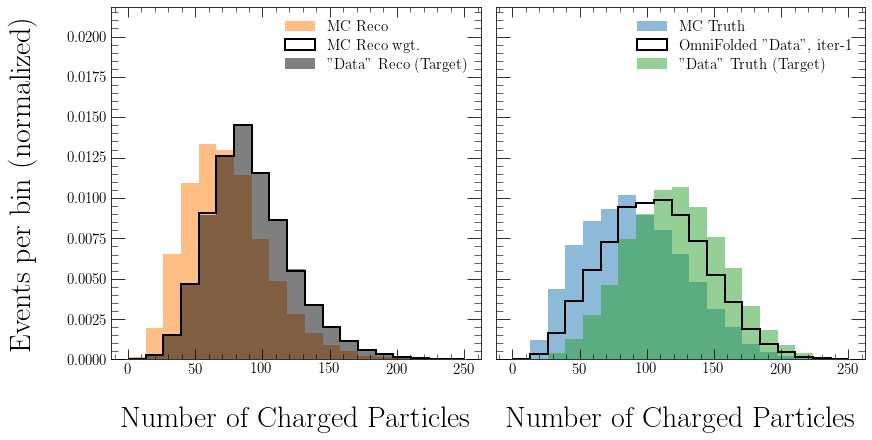

ITERATION 2:


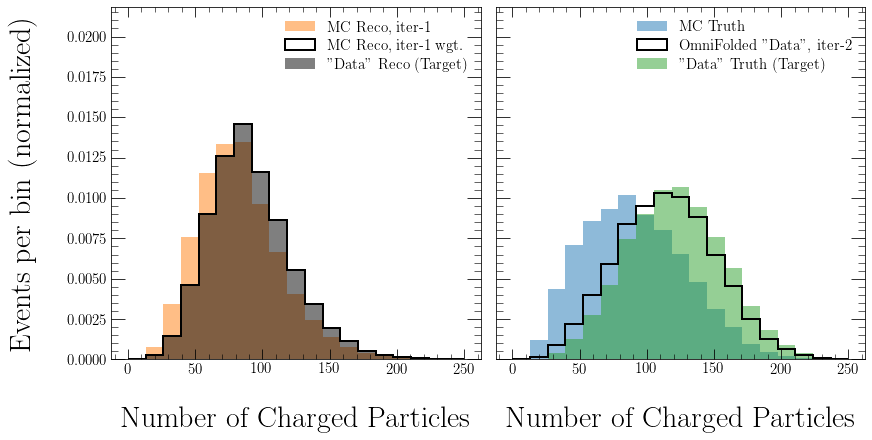

ITERATION 3:


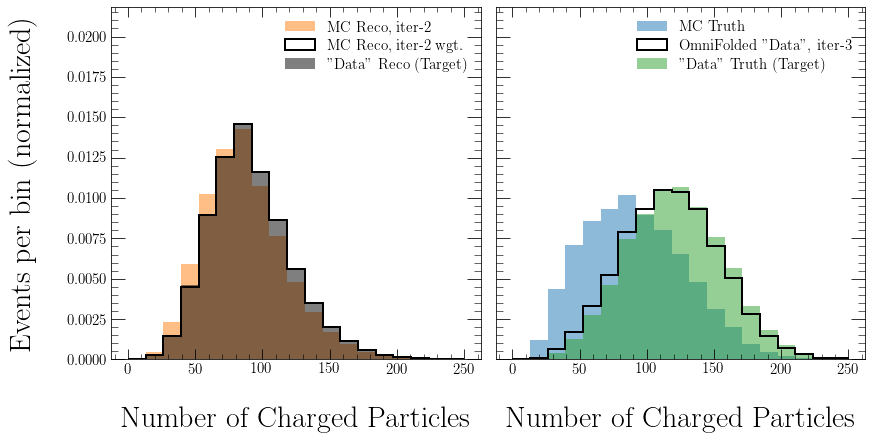

ITERATION 4:


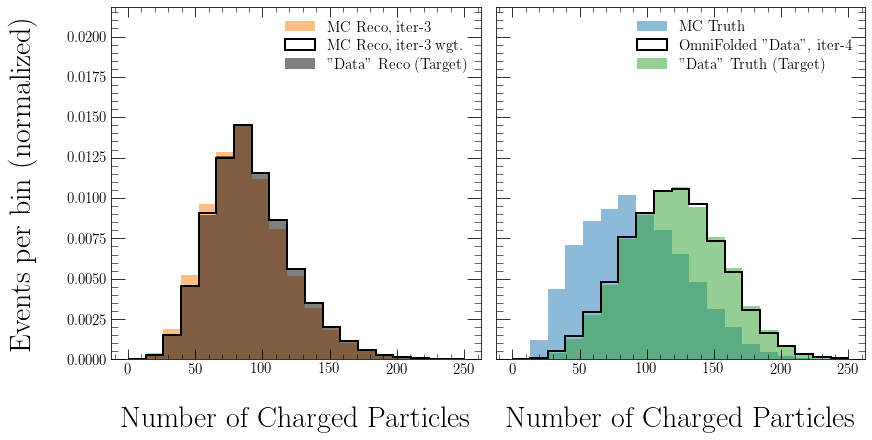

ITERATION 5:


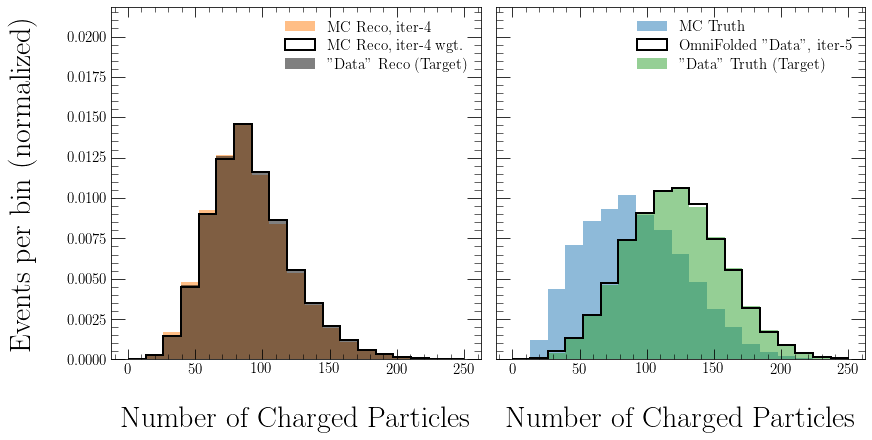

ITERATION 6:


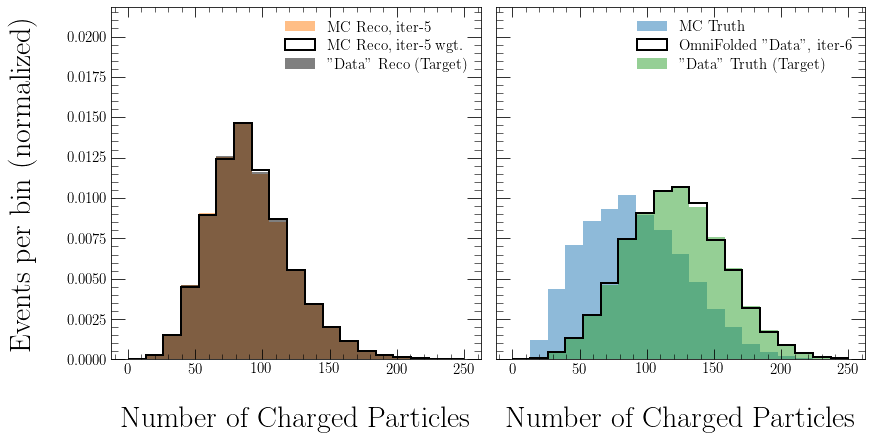

ITERATION 7:


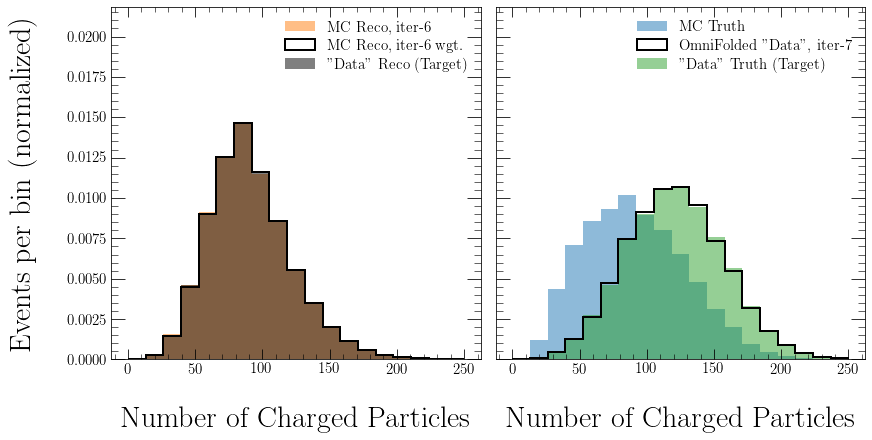

ITERATION 8:


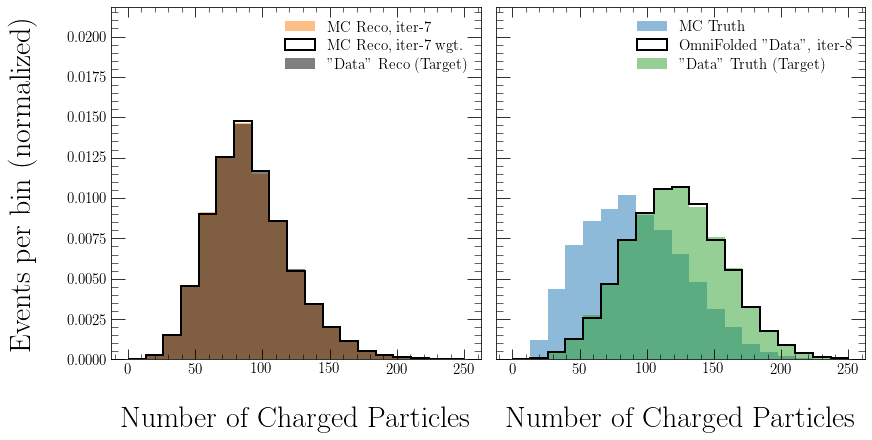

ITERATION 9:


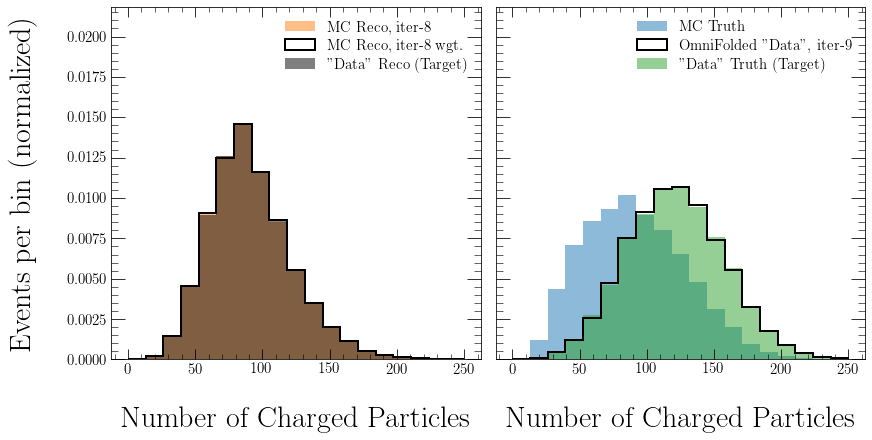

ITERATION 10:


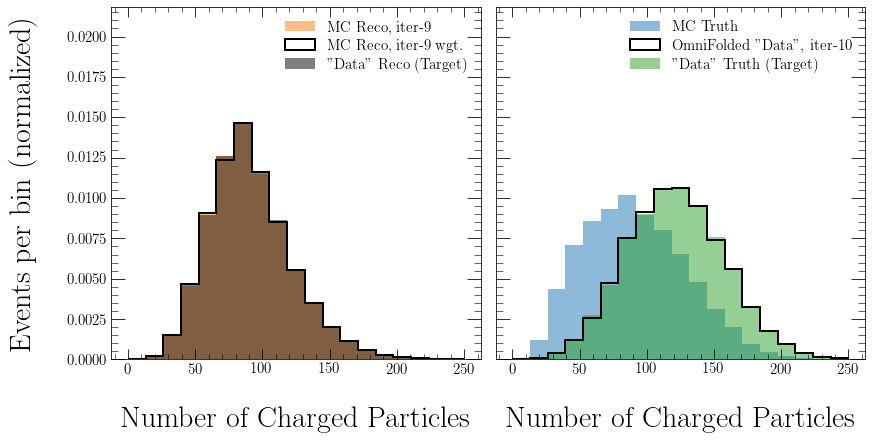

In [54]:
bins = np.linspace(0, 250, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = np.ones(len(Ntracks_sim_reco))
        label0 = ''
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    ax[0].hist(Ntracks_sim_reco,
               weights=weights_init,
               bins=bins,
               label='MC Reco' + label0,
               **plot_style_2,
               color='C1')

    ax[0].hist(Ntracks_sim_reco,
               bins=bins,
               label='MC Reco' + label0 + ' wgt.',
               weights=weights[i, 0, :],
               **plot_style_1)
    hR, _, _ = ax[0].hist(Ntracks_data_reco,
                          weights=weights_Ntracks_stress,
                          bins=bins,
                          label='"Data" Reco (Target)',
                          **plot_style_2,
                          color='k')
    ax[0].set_xlabel(r"Number of Charged Particles")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend()
    ax[1].hist(Ntracks_sim_truth, bins=bins, label=r'MC Truth', **plot_style_2)

    ax[1].hist(Ntracks_sim_truth,
               bins=bins,
               label='OmniFolded "Data"' + label1,
               weights=weights[i, 1, :],
               **plot_style_1)
    hT, _, _ = ax[1].hist(Ntracks_data_truth,
                          weights=weights_Ntracks_stress,
                          bins=bins,
                          label='"Data" Truth (Target)',
                          **plot_style_2,
                          color='C2')
    ax[1].legend()
    ax[1].set_xlabel(r"Number of Charged Particles")

    plt.ylim([0, 1.5 * max(max(hT), max(hR))])
    fig.show()
#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-UniFold-Ntracks-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    plt.show()

## MultiFold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles simultaneously.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the synthetic dataset, and the other half as the unknown "natural" dataset.

In [55]:
K.clear_session()

### Setup datasets

In [56]:
m_ll_sim_truth, m_ll_data_truth, m_ll_sim_reco, m_ll_data_reco, Ntracks_sim_truth, Ntracks_data_truth, Ntracks_sim_reco, Ntracks_data_reco = train_test_split(
    Events_0.events['truth_m_ll'][mypass_0],
    Events_0.events['m_ll'][mypass_0],
    Events_0.events['truth_Ntracks'][mypass_0],
    Events_0.events['Ntracks'][mypass_0],
    test_size=0.5)

In [57]:
scaler_m_ll = preprocessing.StandardScaler()
scaler_m_ll.fit(np.concatenate((m_ll_sim_truth, m_ll_data_truth)).reshape(-1,1))

scaler_Ntracks = preprocessing.StandardScaler()
scaler_Ntracks.fit(np.concatenate((Ntracks_sim_truth, Ntracks_data_truth)).reshape(-1,1))

weight_m_ll_seed = np.squeeze(scaler_m_ll.transform(m_ll_data_truth.reshape(-1,1)))
weight_Ntracks_seed = np.squeeze(scaler_Ntracks.transform(Ntracks_data_truth.reshape(-1,1)))

weight_seed = weight_m_ll_seed + weight_Ntracks_seed

In [58]:
weights_stress = -np.min(weight_seed) + weight_seed
weights_stress = (weights_stress)**3
weights_stress = weights_stress/np.mean(weights_stress)

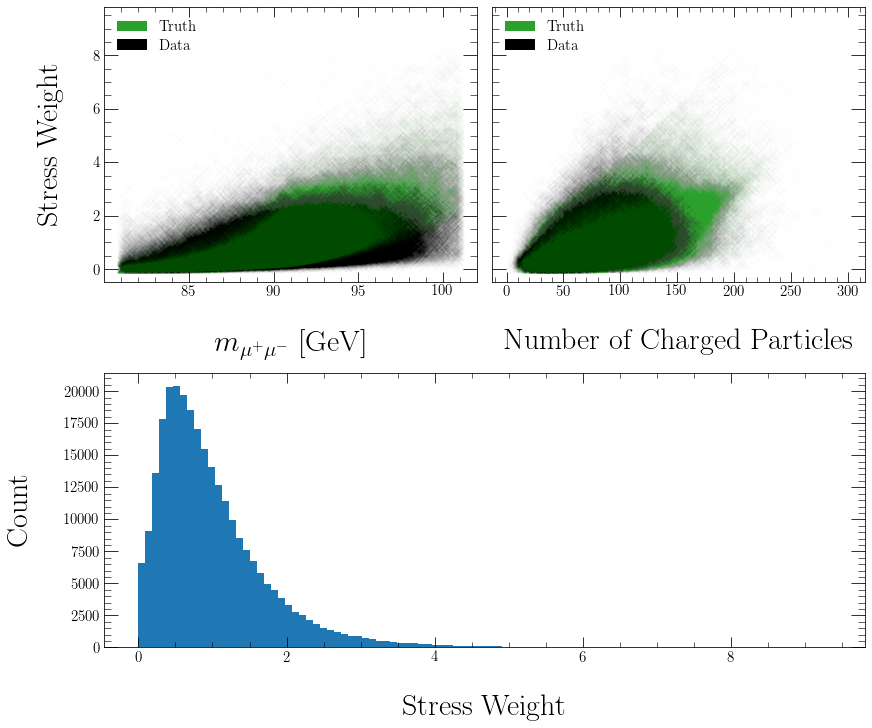

In [59]:
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(m_ll_data_reco,
         weights_stress,
         'x',
         alpha=0.01,
         color='k',
         label='Data')
ax0.plot(m_ll_data_truth,
         weights_stress,
         'x',
         alpha=0.01,
         color='C2',
         label='Truth')
ax0.set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax0.set_ylabel('Stress Weight')

ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
plt.setp(ax1.get_yticklabels(), visible=False)
ax1.plot(Ntracks_data_reco,
         weights_stress,
         'x',
         alpha=0.01,
         color='k',
         label='Data')
ax1.plot(Ntracks_data_truth,
         weights_stress,
         'x',
         alpha=0.01,
         color='C2',
         label='Truth')
ax1.set_xlabel('Number of Charged Particles')

handles = [Patch(facecolor='C2'), Patch(facecolor='k')]
labels = ['Truth', 'Data']
ax0.legend(handles, labels)
ax1.legend(handles, labels)

ax2 = fig.add_subplot(gs[1, :])
ax2.hist(weights_stress,
         bins=np.linspace(np.min(weights_stress), np.max(weights_stress), 100))
ax2.set_xlabel('Stress Weight')
ax2.set_ylabel('Count')

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-MultiFold-StressWeights.png',
#     bbox_inches='tight')

fig.show()

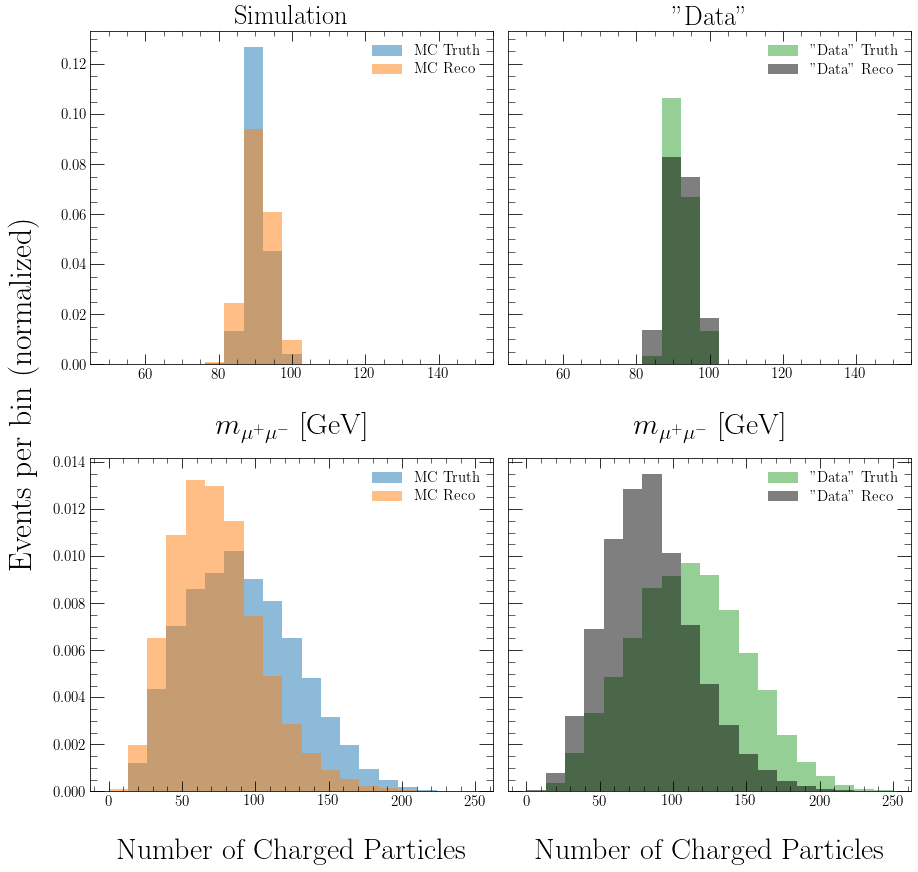

In [60]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 12),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(50, 150, 20)

ax[0, 0].set_title('Simulation')
ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG0, _, _ = ax[0, 0].hist(m_ll_sim_truth,
                          bins=bins,
                          label='MC Truth',
                          **plot_style_2,
                          color='C0')
hS0, _, _ = ax[0, 0].hist(m_ll_sim_reco,
                          bins=bins,
                          label='MC Reco',
                          **plot_style_2,
                          color='C1')
legend = ax[0, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Data"')
ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[0, 1].hist(m_ll_data_truth,
                          weights=weights_stress,
                          bins=bins,
                          label='"Data" Truth',
                          **plot_style_2,
                          color='C2')
hS1, _, _ = ax[0, 1].hist(m_ll_data_reco,
                          weights=weights_stress,
                          bins=bins,
                          label='"Data" Reco',
                          **plot_style_2,
                          color='k')
legend = ax[0, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

bins = np.linspace(0, 250, 20)

ax[1, 0].set_xlabel('Number of Charged Particles')
hG0, _, _ = ax[1, 0].hist(Ntracks_sim_truth,
                          bins=bins,
                          label='MC Truth',
                          **plot_style_2,
                          color='C0')
hS0, _, _ = ax[1, 0].hist(Ntracks_sim_reco,
                          bins=bins,
                          label='MC Reco',
                          **plot_style_2,
                          color='C1')
legend = ax[1, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1, 1].hist(Ntracks_data_truth,
                          weights=weights_stress,
                          bins=bins,
                          label='"Data" Truth',
                          **plot_style_2,
                          color='C2')
hS1, _, _ = ax[1, 1].hist(Ntracks_data_reco,
                          weights=weights_stress,
                          bins=bins,
                          label='"Data" Reco',
                          **plot_style_2,
                          color='k')
legend = ax[1, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.text(-0.05,
         0.55,
         'Events per bin (normalized)',
         va='center',
         rotation='vertical',
         fontsize='x-large')
# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-MultiFold-Distributions.pdf', 
#     bbox_inches='tight')
fig.show()

### Unfold $m_{\mu^+\mu^-}$ and Number of Charged Particles Simultaneously

In [61]:
# z-score standardization

num_observables = 2

scaler_m_ll_truth = preprocessing.StandardScaler()
scaler_m_ll_reco = preprocessing.StandardScaler()

scaler_m_ll_truth.fit(m_ll_sim_truth.reshape(-1,1))
scaler_m_ll_reco.fit(np.concatenate((m_ll_sim_reco, m_ll_data_reco)).reshape(-1,1))

scaler_Ntracks_truth = preprocessing.StandardScaler()
scaler_Ntracks_reco = preprocessing.StandardScaler()

scaler_Ntracks_truth.fit(Ntracks_sim_truth.reshape(-1,1))
scaler_Ntracks_reco.fit(np.concatenate((Ntracks_sim_reco, Ntracks_data_reco)).reshape(-1,1))

sim_truth = (np.squeeze(scaler_m_ll_truth.transform(m_ll_sim_truth.reshape(-1,1))),
             np.squeeze(scaler_Ntracks_truth.transform(Ntracks_sim_truth.reshape(-1,1))))

sim_reco = (np.squeeze(scaler_m_ll_reco.transform(m_ll_sim_reco.reshape(-1,1))),
             np.squeeze(scaler_Ntracks_reco.transform(Ntracks_sim_reco.reshape(-1,1))))

data_reco = (np.squeeze(scaler_m_ll_reco.transform(m_ll_data_reco.reshape(-1,1))),
                   np.squeeze(scaler_Ntracks_reco.transform(Ntracks_data_reco.reshape(-1,1))))

In [62]:
weights, _ = multifold(num_observables=num_observables,
                       iterations=10,
                       sim_truth=sim_truth,
                       sim_reco=sim_reco,
                       data_reco=data_reco,
                       weights_MC_data=weights_stress)


ITERATION: 1

STEP 1

Epoch 1/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6708 - accuracy: 0.3510 - val_loss: 0.6631 - val_accuracy: 0.3666
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.3643 - val_loss: 0.6627 - val_accuracy: 0.3612
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.3660 - val_loss: 0.6626 - val_accuracy: 0.3665
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.3661 - val_loss: 0.6625 - val_accuracy: 0.3642
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.3662 - val_loss: 0.6625 - val_accuracy: 0.3658
Epoch 6/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6630 - accuracy: 0.3647 - val_loss: 0.6625 - val_accuracy: 0.3671
Epoch 7/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.3654 - val_loss: 0.6627 - val_accurac

Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.3584 - val_loss: 0.6609 - val_accuracy: 0.3535
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.3572 - val_loss: 0.6608 - val_accuracy: 0.3539
Epoch 6/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.3580 - val_loss: 0.6608 - val_accuracy: 0.3591
Epoch 7/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.3582 - val_loss: 0.6608 - val_accuracy: 0.3545
Epoch 8/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.3566 - val_loss: 0.6609 - val_accuracy: 0.3573
Epoch 9/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.3574 - val_loss: 0.6608 - val_accuracy: 0.3559
Epoch 10/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.3565 - val_loss: 0.6608 - val_accuracy: 0.3607
Epoch 11/200

Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.3513 - val_loss: 0.6440 - val_accuracy: 0.3509
Epoch 6/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.3516 - val_loss: 0.6440 - val_accuracy: 0.3491
Epoch 7/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.3509 - val_loss: 0.6440 - val_accuracy: 0.3517
Epoch 8/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.3518 - val_loss: 0.6440 - val_accuracy: 0.3501
Epoch 9/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.3515 - val_loss: 0.6440 - val_accuracy: 0.3519
Epoch 10/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.3504 - val_loss: 0.6441 - val_accuracy: 0.3522
Epoch 11/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.3518 - val_loss: 0.6440 - val_accuracy: 0.3512
Epoch 12/20


STEP 2

Epoch 1/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6568 - accuracy: 0.3747 - val_loss: 0.6385 - val_accuracy: 0.3442
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.3494 - val_loss: 0.6378 - val_accuracy: 0.3494
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.3504 - val_loss: 0.6378 - val_accuracy: 0.3492
Epoch 4/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6378 - accuracy: 0.3502 - val_loss: 0.6378 - val_accuracy: 0.3496
Epoch 5/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6378 - accuracy: 0.3508 - val_loss: 0.6377 - val_accuracy: 0.3485
Epoch 6/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6378 - accuracy: 0.3494 - val_loss: 0.6379 - val_accuracy: 0.3541
Epoch 7/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.3501 - val_loss: 0.6378 - val_accuracy: 0.3506
Epoc

42/42 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.3493 - val_loss: 0.6360 - val_accuracy: 0.3524
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.3501 - val_loss: 0.6359 - val_accuracy: 0.3512
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.3493 - val_loss: 0.6359 - val_accuracy: 0.3501
Epoch 6/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.3501 - val_loss: 0.6360 - val_accuracy: 0.3508
Epoch 7/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.3497 - val_loss: 0.6359 - val_accuracy: 0.3492
Epoch 8/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.3492 - val_loss: 0.6361 - val_accuracy: 0.3524
Epoch 9/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.3497 - val_loss: 0.6361 - val_accuracy: 0.3527
Epoch 10/200
42/42 [=====


STEP 2

Epoch 1/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6544 - accuracy: 0.3726 - val_loss: 0.6345 - val_accuracy: 0.3455
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.3508 - val_loss: 0.6340 - val_accuracy: 0.3493
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.3502 - val_loss: 0.6340 - val_accuracy: 0.3515
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.3512 - val_loss: 0.6340 - val_accuracy: 0.3489
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.3503 - val_loss: 0.6341 - val_accuracy: 0.3509
Epoch 6/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.3507 - val_loss: 0.6340 - val_accuracy: 0.3502
Epoch 7/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.3507 - val_loss: 0.6340 - val_accuracy: 0.3510
Epoc

#### Results

ITERATION: 1


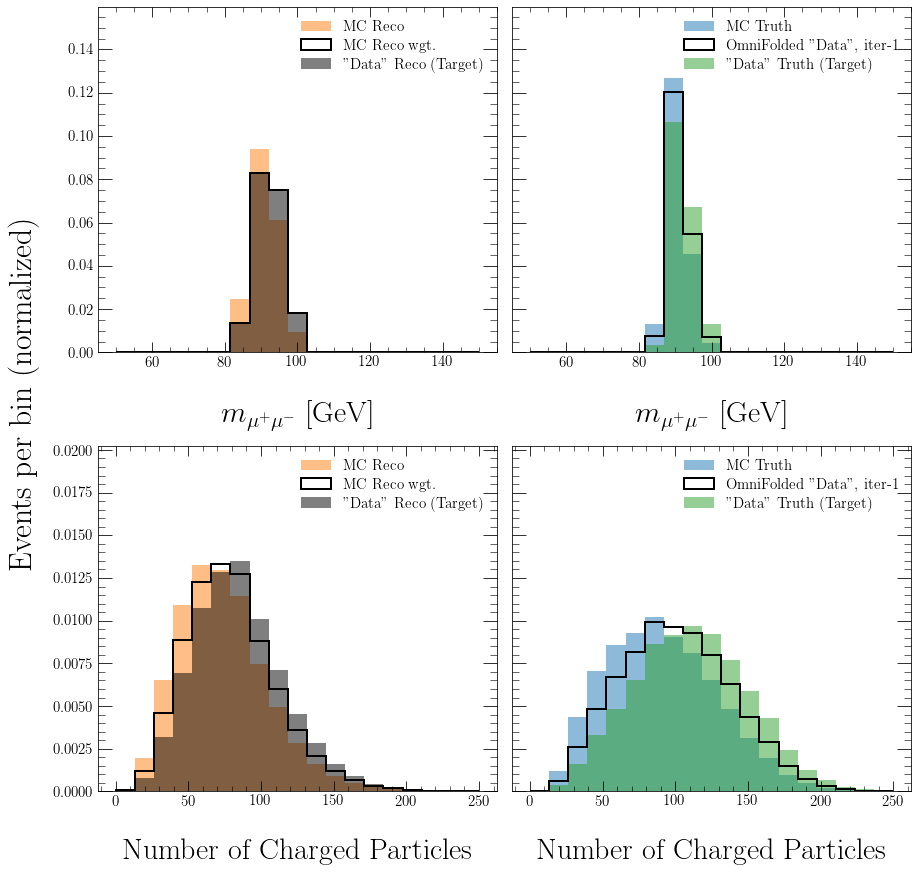

ITERATION: 2


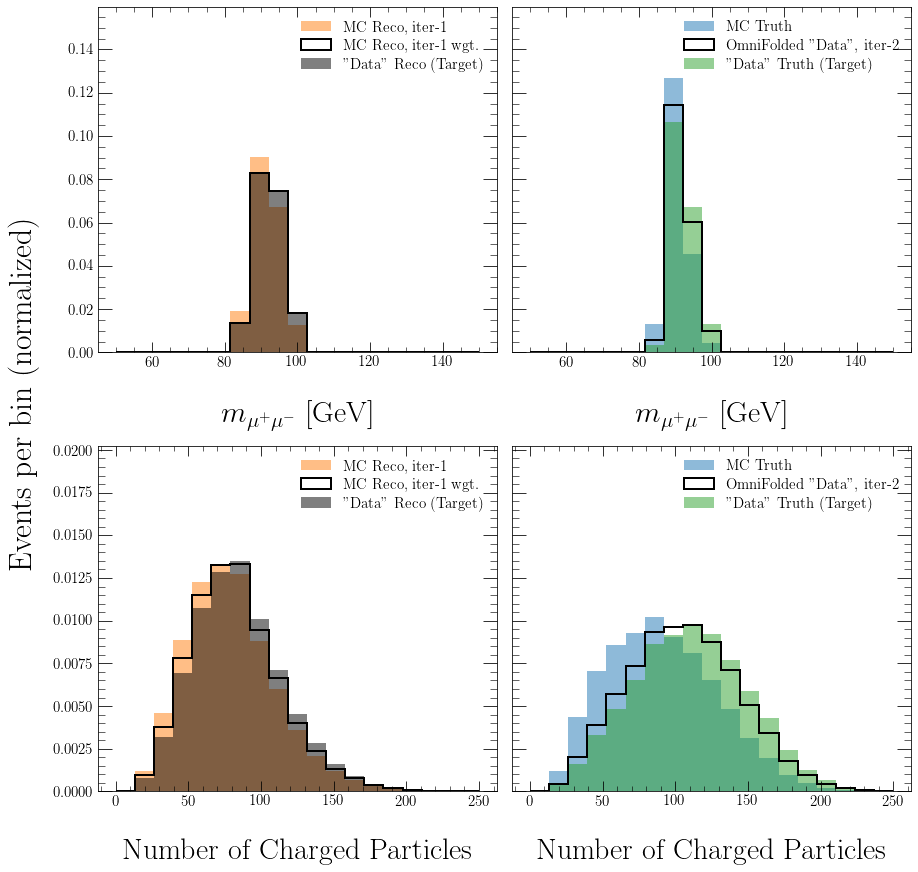

ITERATION: 3


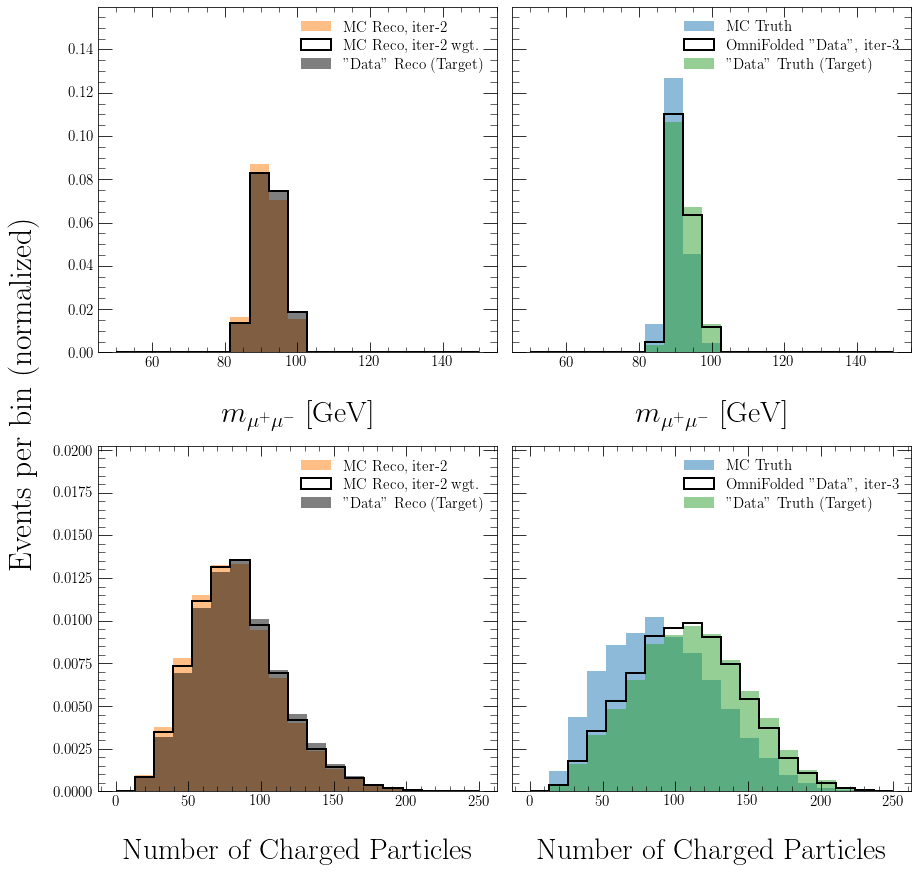

ITERATION: 4


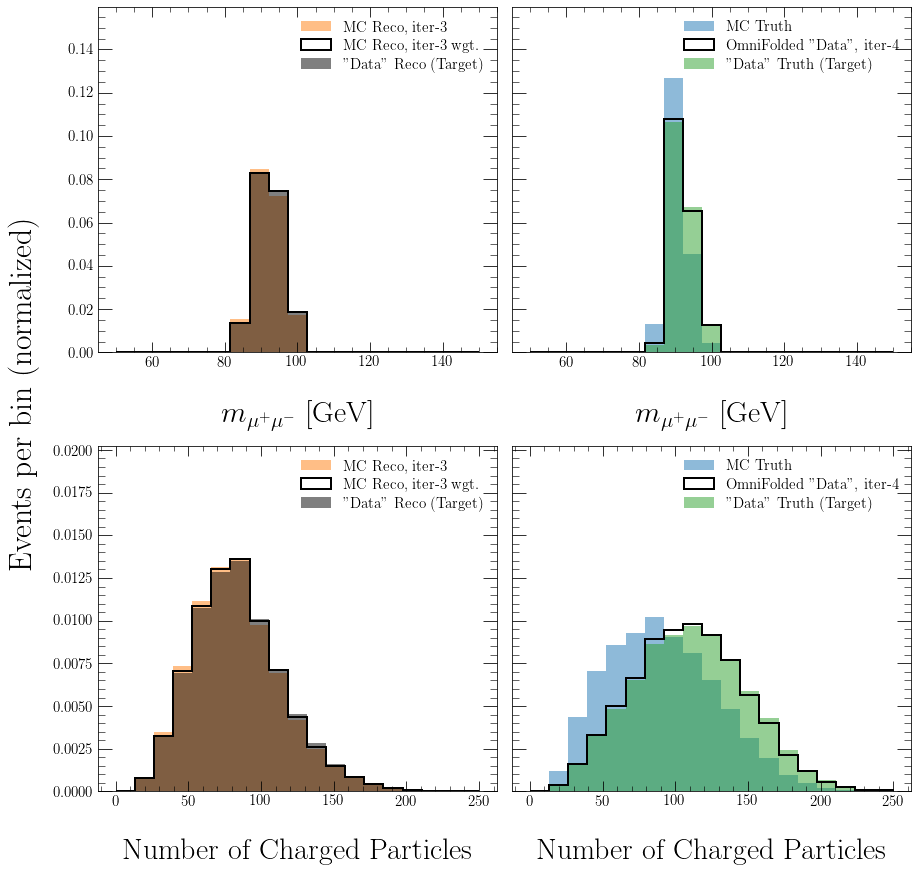

ITERATION: 5


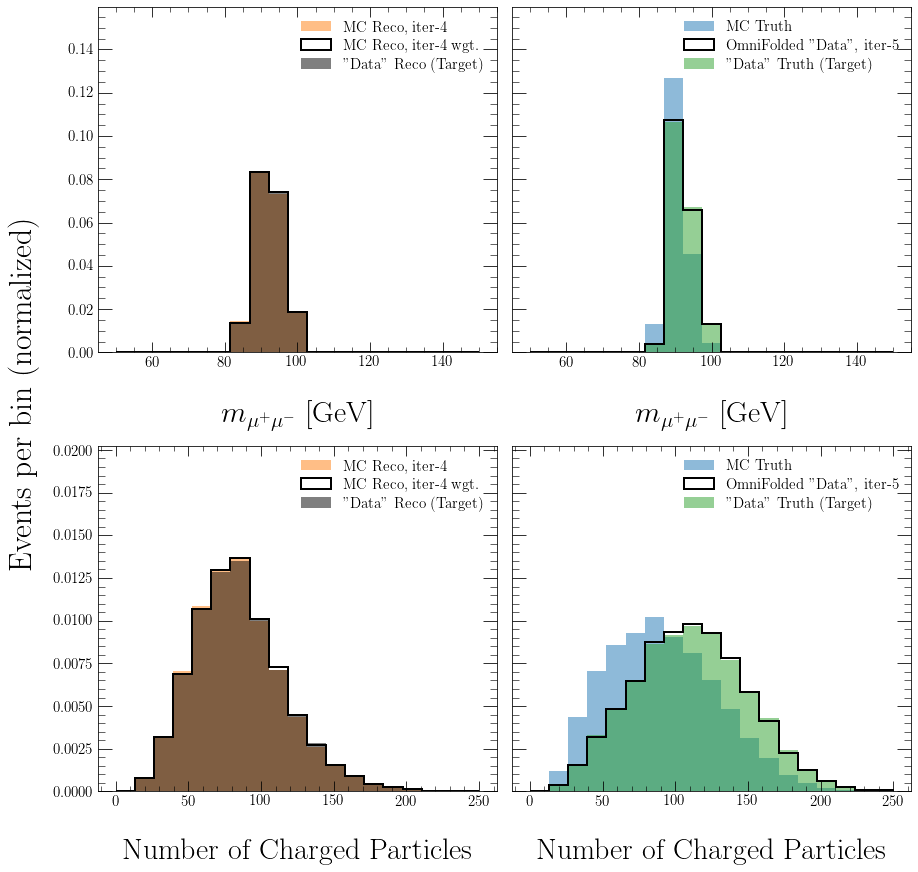

ITERATION: 6


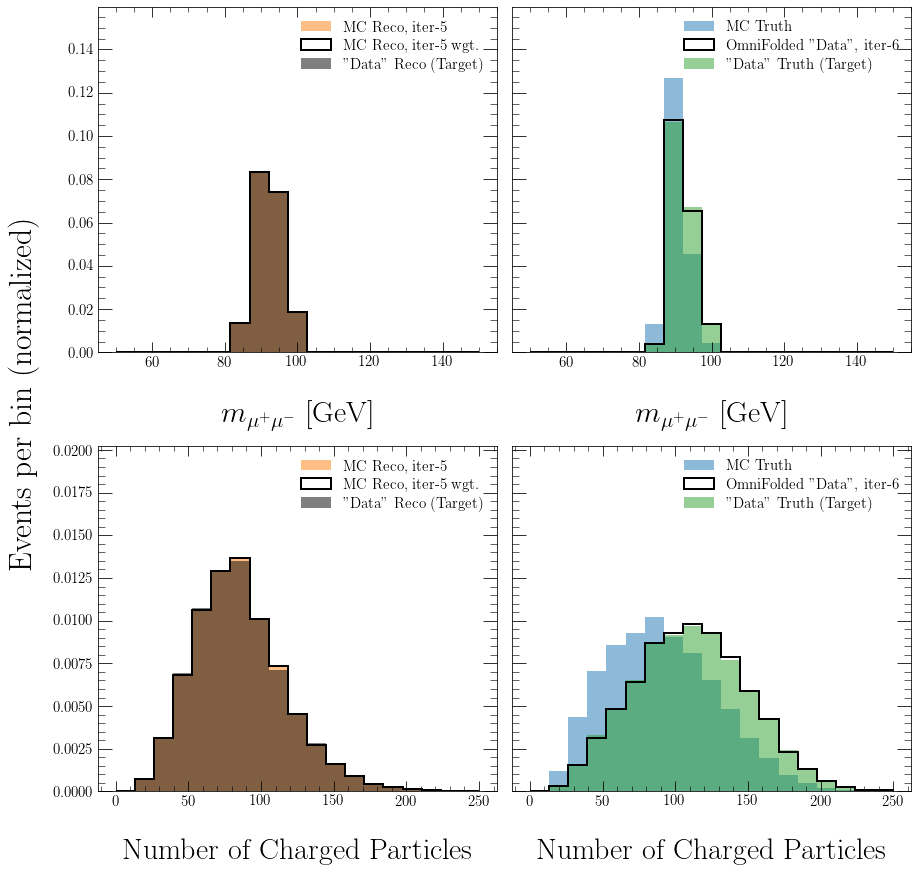

ITERATION: 7


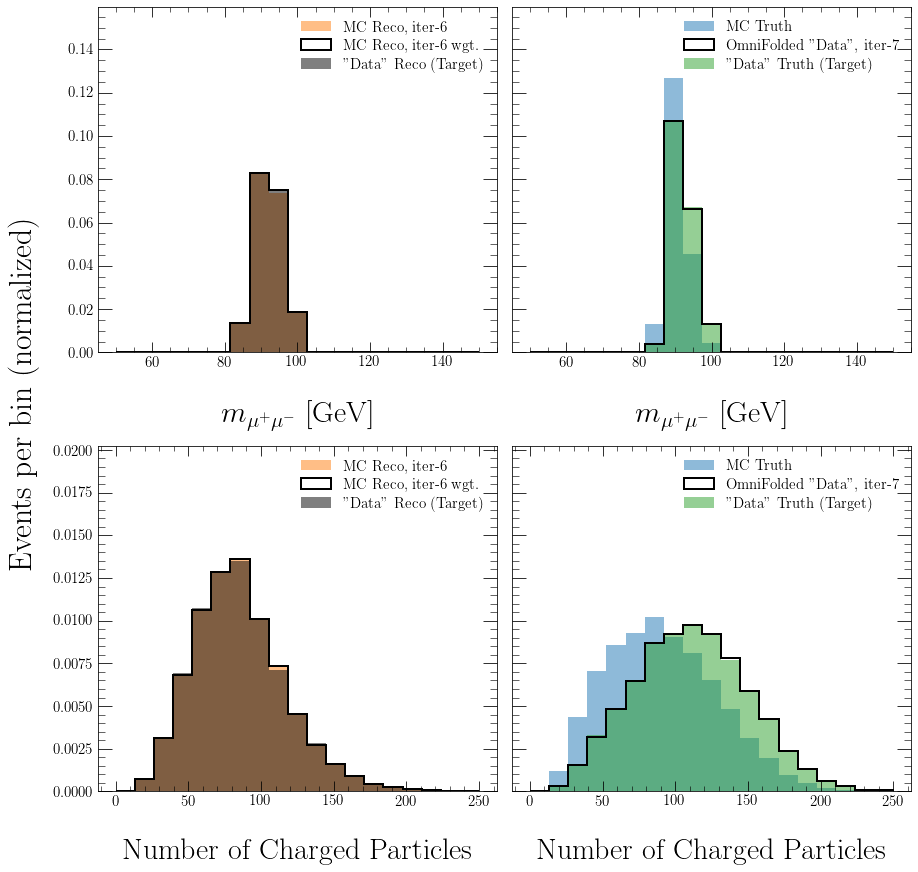

ITERATION: 8


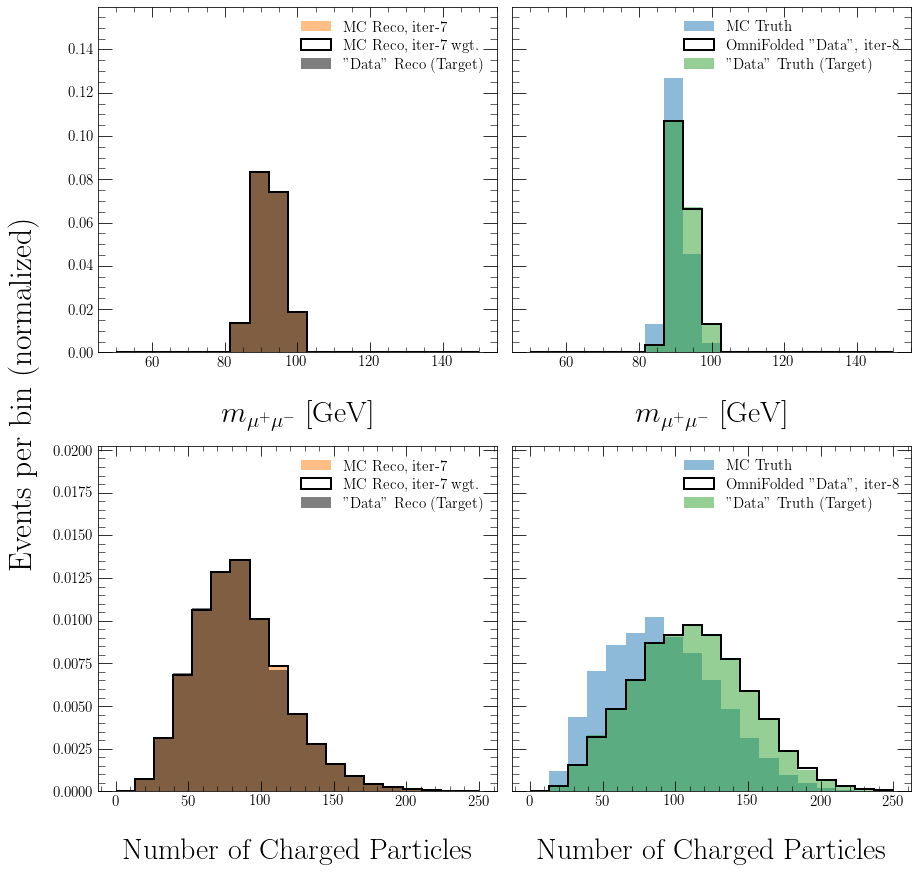

ITERATION: 9


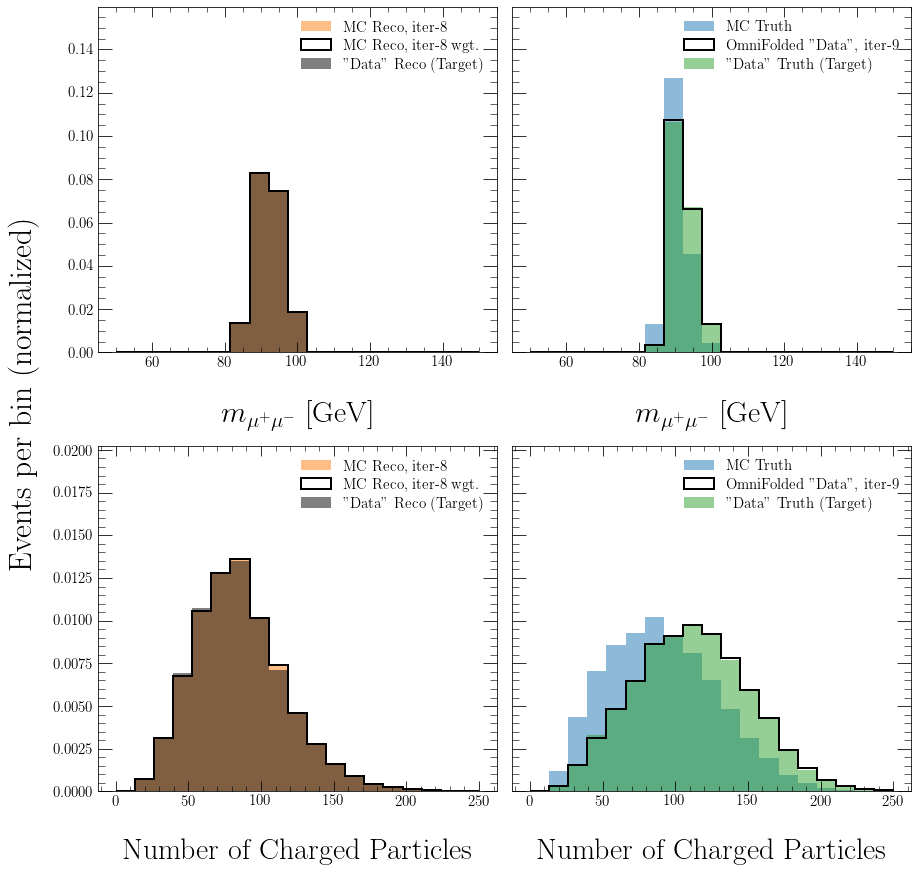

ITERATION: 10


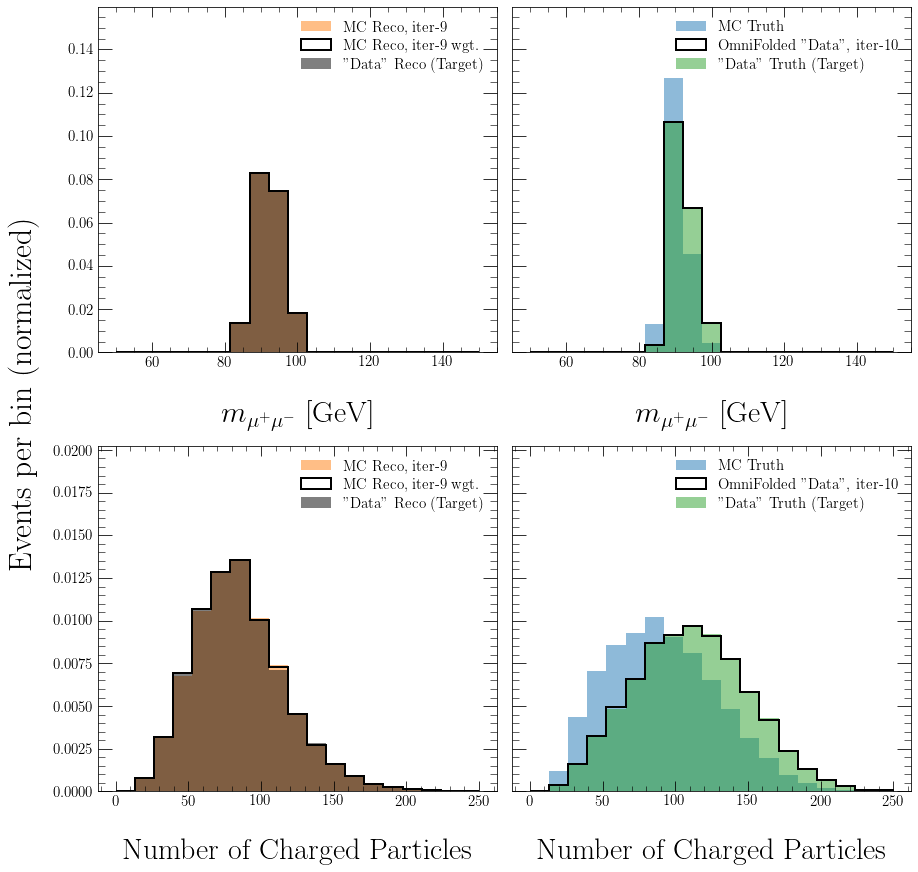

In [63]:
for i in range(len(weights)):
    if i == 0:
        weights_init = np.ones(len(weights[i - 1, 1, :]))
        label0 = ''.format(i)
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(50, 150, 20)

    fig, ax = plt.subplots(num_observables,
                           2,
                           figsize=(12, 12),
                           constrained_layout=True,
                           sharey='row')

    ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0, 0].hist(m_ll_sim_reco,
                  weights=weights_init,
                  bins=bins,
                  label='MC Reco' + label0,
                  **plot_style_2,
                  color='C1')
    ax[0, 0].hist(m_ll_sim_reco,
                  bins=bins,
                  weights=weights[i, 0, :],
                  label='MC Reco' + label0 + ' wgt.',
                  **plot_style_1)

    hR0, _, _ = ax[0, 0].hist(m_ll_data_reco,
                              weights=weights_stress,
                              bins=bins,
                              label=r'"Data" Reco (Target)',
                              **plot_style_2,
                              color='k')
    ax[0, 0].legend(frameon=False)
    

    ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0, 1].hist(m_ll_sim_truth,
                  bins=bins,
                  label=r'MC Truth',
                  **plot_style_2,
                  color='C0')
    ax[0, 1].hist(m_ll_sim_truth,
                  bins=bins,
                  weights=weights[i, 1, :],
                  label='OmniFolded "Data"' + label1,
                  **plot_style_1)

    hT0, _, _ = ax[0, 1].hist(m_ll_data_truth,
                              weights=weights_stress,
                              bins=bins,
                              label=r'"Data" Truth (Target)',
                              **plot_style_2,
                              color='C2')
    ax[0, 0].set_ylim([0, 1.5 * np.max(np.concatenate((hT0, hR0)))])
    ax[0, 1].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1, 0].set_xlabel('Number of Charged Particles')
    ax[1, 0].hist(Ntracks_sim_reco,
                  weights=weights_init,
                  bins=bins,
                  label='MC Reco' + label0,
                  **plot_style_2,
                  color='C1')
    ax[1, 0].hist(Ntracks_sim_reco,
                  bins=bins,
                  weights=weights[i, 1, :],
                  label='MC Reco' + label0 + ' wgt.',
                  **plot_style_1)
    hR1, _, _ = ax[1, 0].hist(Ntracks_data_reco,
                              weights=weights_stress,
                              bins=bins,
                              label=r'"Data" Reco (Target)',
                              **plot_style_2,
                              color='k')
    ax[1, 0].legend(frameon=False)

    ax[1, 1].set_xlabel('Number of Charged Particles')
    ax[1, 1].hist(Ntracks_sim_truth,
                  bins=bins,
                  label=r'MC Truth',
                  **plot_style_2,
                  color='C0')
    ax[1, 1].hist(Ntracks_sim_truth,
                  bins=bins,
                  weights=weights[i, 1, :],
                  label='OmniFolded "Data"' + label1,
                  **plot_style_1)
    hT1, _, _ = ax[1, 1].hist(Ntracks_data_truth,
                              weights=weights_stress,
                              bins=bins,
                              label=r'"Data" Truth (Target)',
                              **plot_style_2,
                              color='C2')
    ax[1, 1].legend(frameon=False)

    fig.text(-0.05,
             0.55,
             'Events per bin (normalized)',
             va='center',
             rotation='vertical',
             fontsize='x-large')

    ax[1, 0].set_ylim([0, 1.5 * np.max(np.concatenate((hT1, hR1)))])

#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-MultiFold-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    fig.show()
    plt.show()

# Stress Test B
Stress weights are based on a random variable.
After standardizing (z-score) each observable $x$ to $x'$, the weights are given by $w\sim  \mathcal{N}(0, \text{sigmoid}(x'))$.

## UniFold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles separately.

### Setup Datasets

In [64]:
m_ll_sim_truth, m_ll_data_truth, m_ll_sim_reco, m_ll_data_reco = train_test_split(Events_0.events['truth_m_ll'][mypass_0],
                                                                      Events_0.events['m_ll'][mypass_0], 
                                                                      test_size=0.5)

In [65]:
scaler_m_ll = preprocessing.StandardScaler()

scaler_m_ll.fit(np.concatenate((m_ll_sim_truth, m_ll_data_truth)).reshape(-1,1))

weight_m_ll_seed = np.squeeze(scaler_m_ll.transform(m_ll_data_truth.reshape(-1,1)))

In [66]:
weights_m_ll_stress = [
    abs(np.random.normal(0, sigmoid(std))) for std in weight_m_ll_seed
]
weights_m_ll_stress = np.array(weights_m_ll_stress)
weights_m_ll_stress = weights_m_ll_stress / np.mean(weights_m_ll_stress)

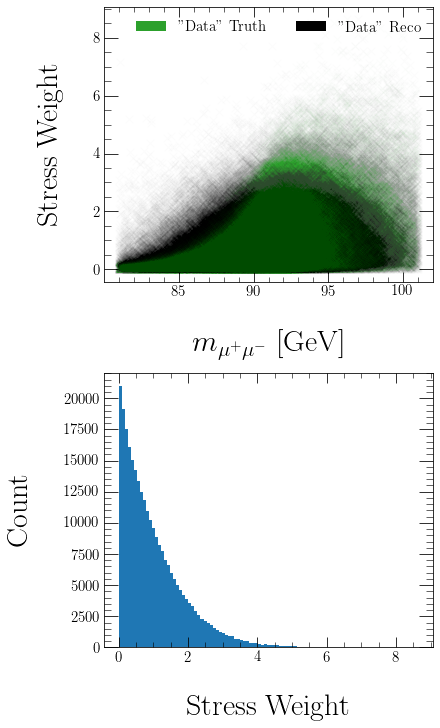

In [67]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10), constrained_layout=True)

ax[0].plot(m_ll_data_reco,
           weights_m_ll_stress,
           'x',
           alpha=0.01,
           label='Data',
           color='k')
ax[0].plot(m_ll_data_truth,
           weights_m_ll_stress,
           'x',
           alpha=0.01,
           label='Truth',
           color='C2')

ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Stress Weight')
handles = [Patch(facecolor='C2'), Patch(facecolor='k')]
labels = ['"Data" Truth', '"Data" Reco']
ax[0].legend(handles, labels, ncol=2)

ax[1].hist(weights_m_ll_stress,
           bins=np.linspace(np.min(weights_m_ll_stress),
                            np.max(weights_m_ll_stress), 100))
ax[1].set_xlabel('Stress Weight')
ax[1].set_ylabel('Count')

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-UniFold-m_ll-StressWeights.png',
#     bbox_inches='tight')

fig.show()

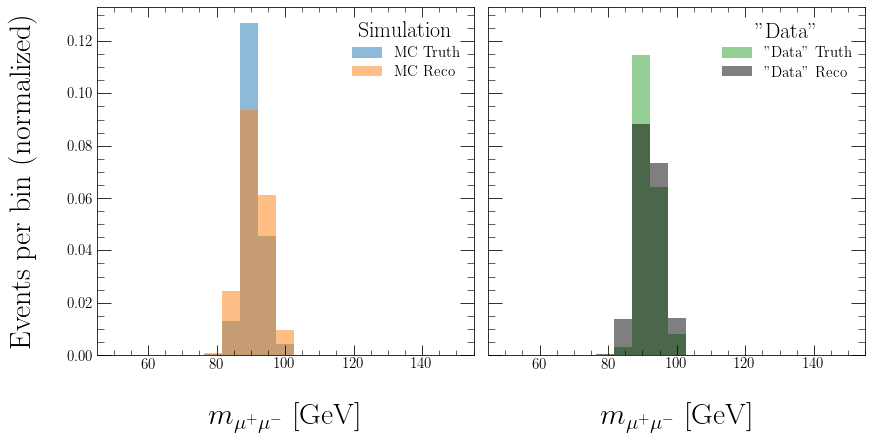

In [68]:
bins = np.linspace(50, 150, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Events per bin (normalized)')
hG0, _, _ = ax[0].hist(m_ll_sim_truth,
                       bins=bins,
                       label='MC Truth',
                       **plot_style_2,
                       color='C0')
hS0, _, _ = ax[0].hist(m_ll_sim_reco,
                       bins=bins,
                       label='MC Reco',
                       **plot_style_2,
                       color='C1')
legend = ax[0].legend(title='Simulation', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[1].hist(m_ll_data_truth,
                       weights=weights_m_ll_stress,
                       bins=bins,
                       label='"Data" Truth',
                       **plot_style_2,
                       color='C2')
hS1, _, _ = ax[1].hist(m_ll_data_reco,
                       weights=weights_m_ll_stress,
                       bins=bins,
                       label='"Data" Reco',
                       **plot_style_2,
                       color='k')
legend = ax[1].legend(title='"Data"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-UniFold-m_ll-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

In [69]:
Ntracks_sim_truth, Ntracks_data_truth, Ntracks_sim_reco, Ntracks_data_reco = train_test_split(
    Events_0.events['truth_Ntracks'][mypass_0],
    Events_0.events['Ntracks'][mypass_0],
    test_size=0.5)

In [70]:
scaler_Ntracks = preprocessing.StandardScaler()

scaler_Ntracks.fit(np.concatenate((Ntracks_sim_truth, Ntracks_data_truth)).reshape(-1,1))

weight_Ntracks_seed = np.squeeze(scaler_Ntracks.transform(Ntracks_data_truth.reshape(-1,1)))

In [71]:
weights_Ntracks_stress = [abs(np.random.normal(0, sigmoid(std))) for std in weight_Ntracks_seed]
weights_Ntracks_stress = np.array(weights_Ntracks_stress)
weights_Ntracks_stress = weights_Ntracks_stress/np.mean(weights_Ntracks_stress)

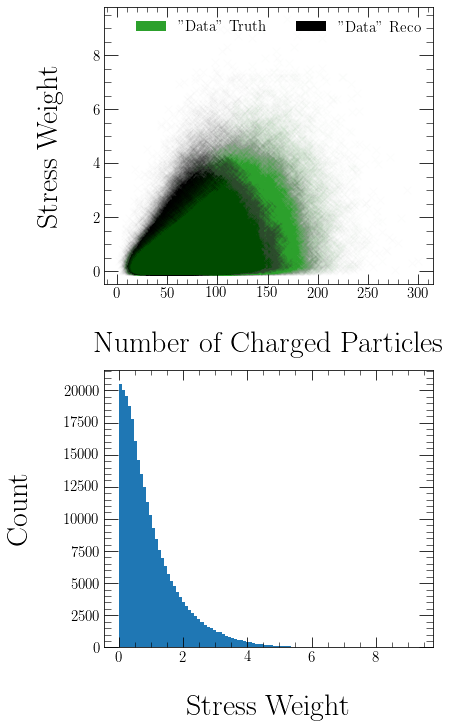

In [72]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10), constrained_layout=True)

ax[0].plot(Ntracks_data_reco, weights_Ntracks_stress,
           'x',
           alpha=0.01,
           label='Data',
           color='k')
ax[0].plot(Ntracks_data_truth, weights_Ntracks_stress,
           'x',
           alpha=0.01,
           label='Truth',
           color='C2')

ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Stress Weight')
handles = [Patch(facecolor='C2'), Patch(facecolor='k')]
labels = ['"Data" Truth', '"Data" Reco']
ax[0].legend(handles, labels, ncol=2)

ax[1].hist(weights_Ntracks_stress,
           bins=np.linspace(np.min(weights_Ntracks_stress),
                            np.max(weights_Ntracks_stress), 100))
ax[1].set_xlabel('Stress Weight')
ax[1].set_ylabel('Count')

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-UniFold-Ntracks-StressWeights.png',
#     bbox_inches='tight')

fig.show()

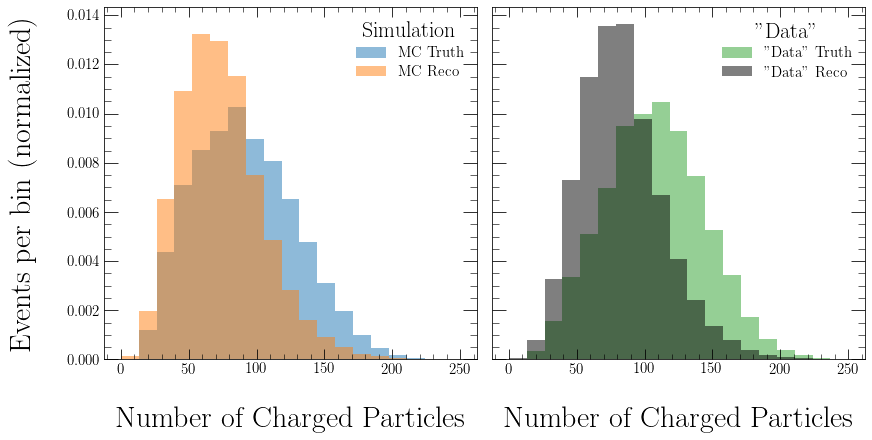

In [73]:
bins = np.linspace(0, 250, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Events per bin (normalized)')
hG0, _, _ = ax[0].hist(Ntracks_sim_truth,
                       bins=bins,
                       label='MC Truth',
                       **plot_style_2,
                       color='C0')
hS0, _, _ = ax[0].hist(Ntracks_sim_reco,
                       bins=bins,
                       label='MC Reco',
                       **plot_style_2,
                       color='C1')
legend = ax[0].legend(title='Simulation', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1].hist(Ntracks_data_truth,
                       weights=weights_Ntracks_stress,
                       bins=bins,
                       label='"Data" Truth',
                       **plot_style_2,
                       color='C2')
hS1, _, _ = ax[1].hist(Ntracks_data_reco,
                       weights=weights_Ntracks_stress,
                       bins=bins,
                       label='"Data" Reco',
                       **plot_style_2,
                       color='k')
legend = ax[1].legend(title='"Data"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-UniFold-Ntracks-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

### Unfold $m_{\mu^+\mu^-}$

In [74]:
# z-score standardization

scaler_truth = preprocessing.StandardScaler()
scaler_reco = preprocessing.StandardScaler()

scaler_truth.fit(m_ll_sim_truth.reshape(-1,1))
scaler_reco.fit(np.concatenate((m_ll_sim_reco, m_ll_data_reco)).reshape(-1,1))

sim_truth = np.squeeze(scaler_truth.transform(m_ll_sim_truth.reshape(-1,1)))
sim_reco = np.squeeze(scaler_reco.transform(m_ll_sim_reco.reshape(-1,1)))
data_reco = np.squeeze(scaler_reco.transform(m_ll_data_reco.reshape(-1,1)))

In [75]:
weights, _ = unifold(iterations=10,
                     sim_truth=sim_truth,
                     sim_reco=sim_reco,
                     data_reco=data_reco,
                     weights_MC_data=weights_m_ll_stress)


ITERATION: 1

STEP 1

Epoch 1/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6853 - accuracy: 0.3744 - val_loss: 0.6841 - val_accuracy: 0.3917
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6846 - accuracy: 0.3963 - val_loss: 0.6842 - val_accuracy: 0.3919
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.3902 - val_loss: 0.6841 - val_accuracy: 0.3841
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.3831 - val_loss: 0.6841 - val_accuracy: 0.3811
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.3788 - val_loss: 0.6841 - val_accuracy: 0.3817
Epoch 6/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.3810 - val_loss: 0.6842 - val_accuracy: 0.3858
Epoch 7/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6846 - accuracy: 0.3788 - val_loss: 0.6841 - val_accurac

42/42 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.2496 - val_loss: 0.6923 - val_accuracy: 0.2498
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.2497 - val_loss: 0.6923 - val_accuracy: 0.2495
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.2498 - val_loss: 0.6923 - val_accuracy: 0.2499
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.2497 - val_loss: 0.6923 - val_accuracy: 0.2498
Epoch 6/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.2497 - val_loss: 0.6924 - val_accuracy: 0.2498
Epoch 7/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.2499 - val_loss: 0.6923 - val_accuracy: 0.2499
Epoch 8/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.2496 - val_loss: 0.6923 - val_accuracy: 0.2498
Epoch 9/200
42/42 [======

42/42 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.3821 - val_loss: 0.6819 - val_accuracy: 0.3725
Epoch 14/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.3800 - val_loss: 0.6819 - val_accuracy: 0.3802
Epoch 15/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.3815 - val_loss: 0.6819 - val_accuracy: 0.3819
Epoch 16/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.3822 - val_loss: 0.6819 - val_accuracy: 0.3834
Epoch 17/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.3805 - val_loss: 0.6819 - val_accuracy: 0.3833
Epoch 18/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.3817 - val_loss: 0.6819 - val_accuracy: 0.3795
Epoch 19/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.3805 - val_loss: 0.6819 - val_accuracy: 0.3793
Epoch 20/200
42/42 

42/42 [==============================] - 0s 4ms/step - loss: 0.6971 - accuracy: 0.2502 - val_loss: 0.6936 - val_accuracy: 0.2502
Epoch 10/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.2500 - val_loss: 0.6936 - val_accuracy: 0.2501
Epoch 11/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6971 - accuracy: 0.2503 - val_loss: 0.6936 - val_accuracy: 0.2501
Epoch 12/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.2500 - val_loss: 0.6936 - val_accuracy: 0.2503
Epoch 13/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.2503 - val_loss: 0.6936 - val_accuracy: 0.2501
Epoch 14/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6971 - accuracy: 0.2499 - val_loss: 0.6936 - val_accuracy: 0.2501
Epoch 15/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6971 - accuracy: 0.2501 - val_loss: 0.6936 - val_accuracy: 0.2502
Epoch 16/200
42/42 

42/42 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.2497 - val_loss: 0.6900 - val_accuracy: 0.2499
Epoch 12/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.2503 - val_loss: 0.6899 - val_accuracy: 0.2508
Epoch 13/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.2501 - val_loss: 0.6900 - val_accuracy: 0.2506
Epoch 14/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.2502 - val_loss: 0.6900 - val_accuracy: 0.2508
Epoch 15/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6902 - accuracy: 0.2500 - val_loss: 0.6900 - val_accuracy: 0.2506
Epoch 16/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6902 - accuracy: 0.2500 - val_loss: 0.6899 - val_accuracy: 0.2504
Epoch 17/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6902 - accuracy: 0.2499 - val_loss: 0.6900 - val_accuracy: 0.2495
Epoch 18/200
42/42 

42/42 [==============================] - 0s 3ms/step - loss: 0.6710 - accuracy: 0.3768 - val_loss: 0.6712 - val_accuracy: 0.3762
Epoch 8/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6710 - accuracy: 0.3764 - val_loss: 0.6713 - val_accuracy: 0.3771
Epoch 9/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6711 - accuracy: 0.3768 - val_loss: 0.6712 - val_accuracy: 0.3771
Epoch 10/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6710 - accuracy: 0.3778 - val_loss: 0.6712 - val_accuracy: 0.3799
Epoch 11/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6710 - accuracy: 0.3781 - val_loss: 0.6712 - val_accuracy: 0.3766
Epoch 12/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6711 - accuracy: 0.3763 - val_loss: 0.6713 - val_accuracy: 0.3845
Epoch 00012: early stopping

ITERATION: 8

STEP 1

Epoch 1/200
42/42 [==============================] - 0s 5ms/step - loss: 0.6967 - accuracy: 0.2498 - val_loss: 0

42/42 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.2494 - val_loss: 0.6951 - val_accuracy: 0.2499
Epoch 21/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.2500 - val_loss: 0.6951 - val_accuracy: 0.2505
Epoch 22/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.2497 - val_loss: 0.6951 - val_accuracy: 0.2495
Epoch 23/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.2503 - val_loss: 0.6951 - val_accuracy: 0.2504
Epoch 24/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.2504 - val_loss: 0.6952 - val_accuracy: 0.2499
Epoch 00024: early stopping

STEP 2

Epoch 1/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6780 - accuracy: 0.3725 - val_loss: 0.6723 - val_accuracy: 0.3809
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6714 - accuracy: 0.3807 - val_loss: 0.6721 - val_a

#### Results 

ITERATION 1:


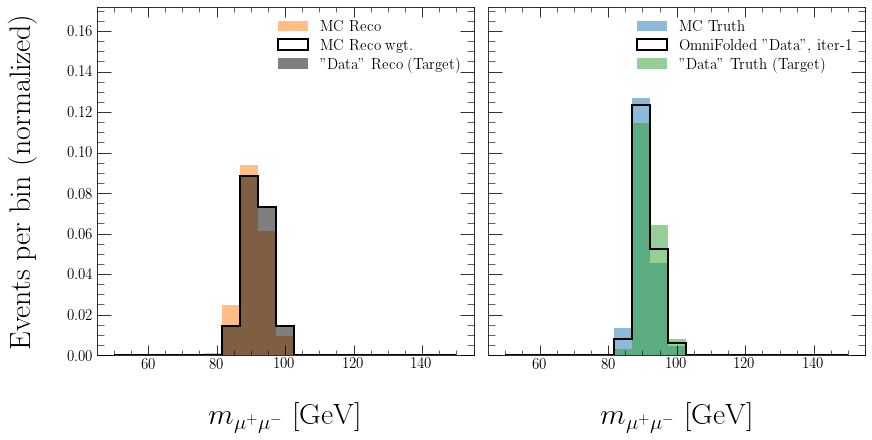

ITERATION 2:


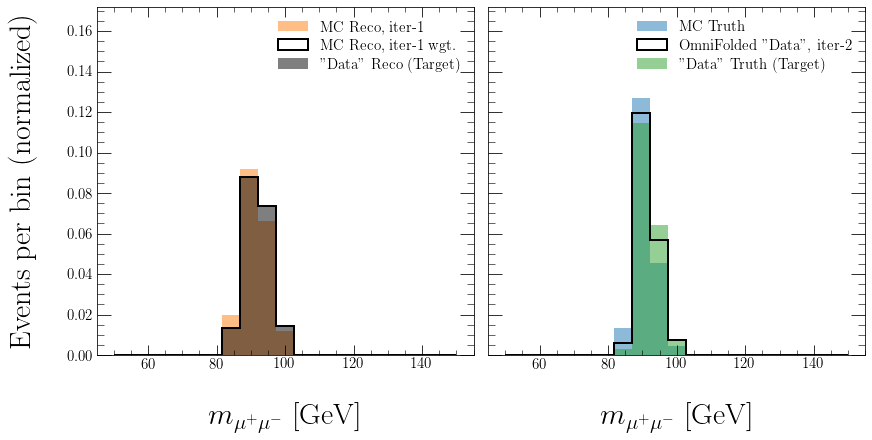

ITERATION 3:


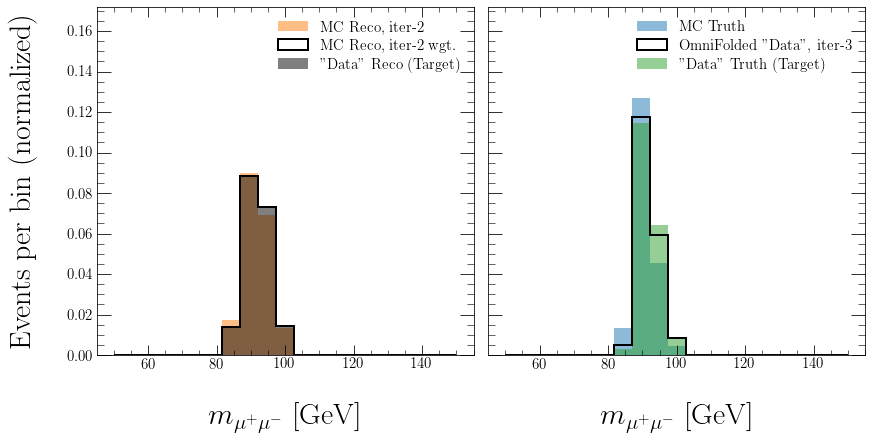

ITERATION 4:


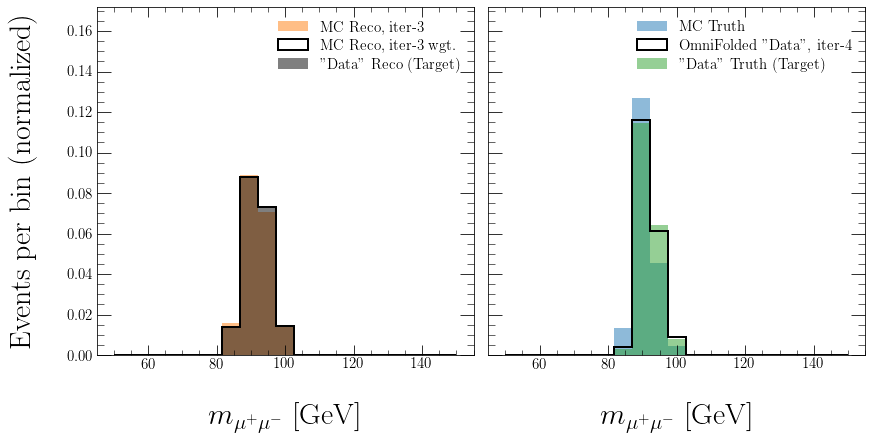

ITERATION 5:


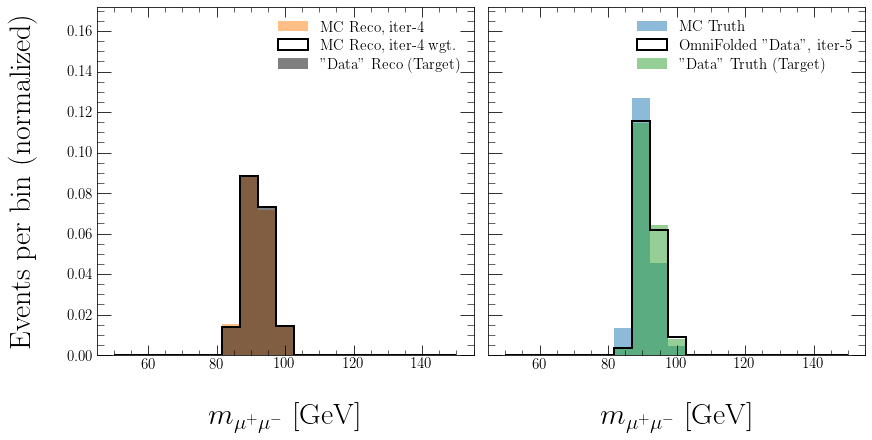

ITERATION 6:


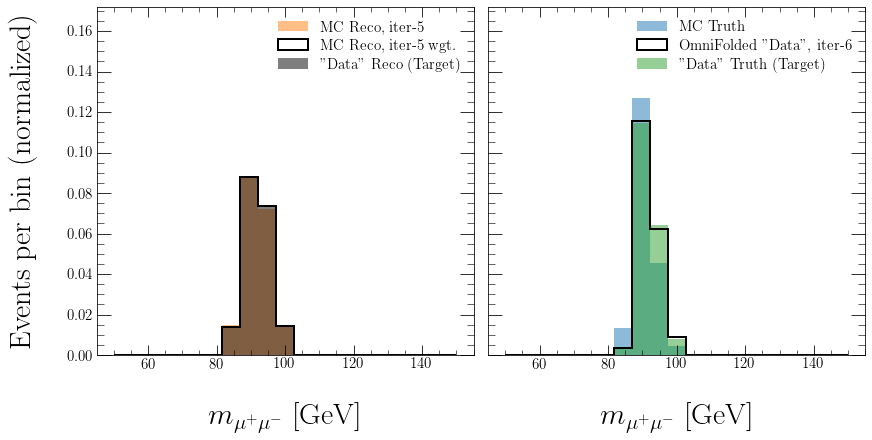

ITERATION 7:


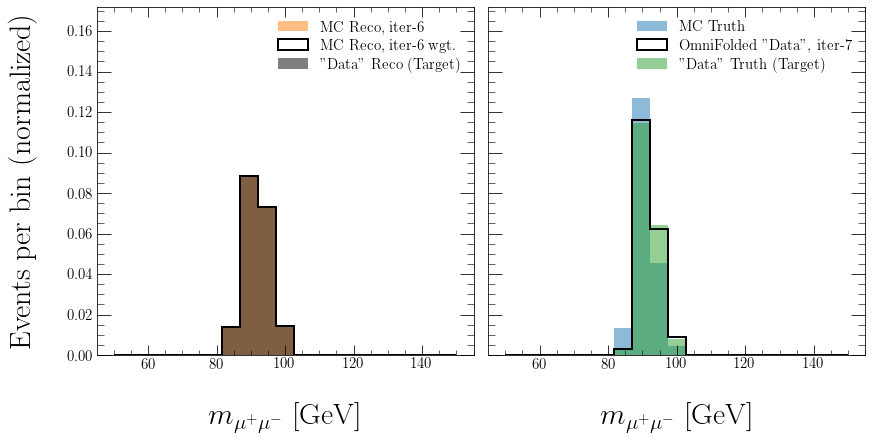

ITERATION 8:


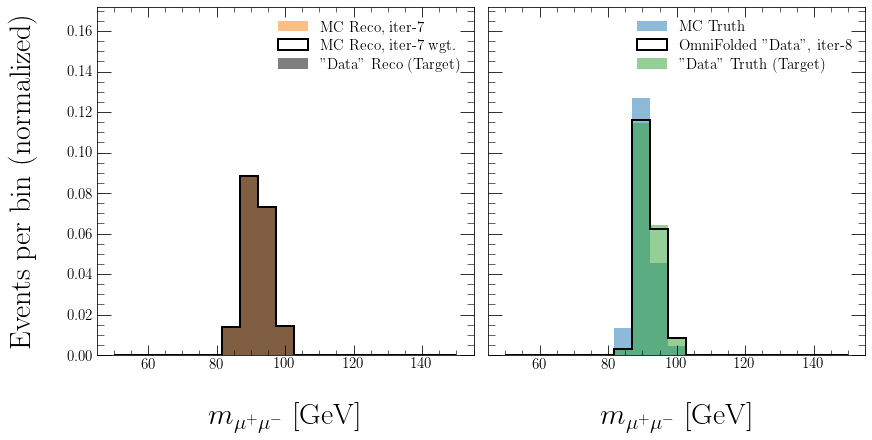

ITERATION 9:


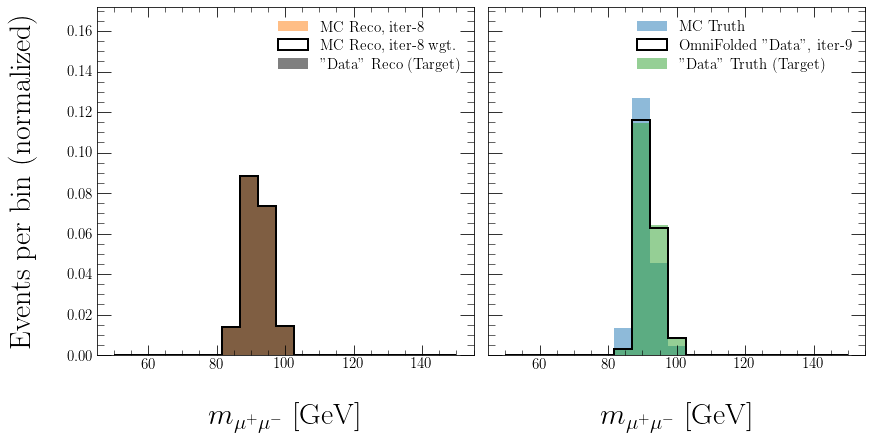

ITERATION 10:


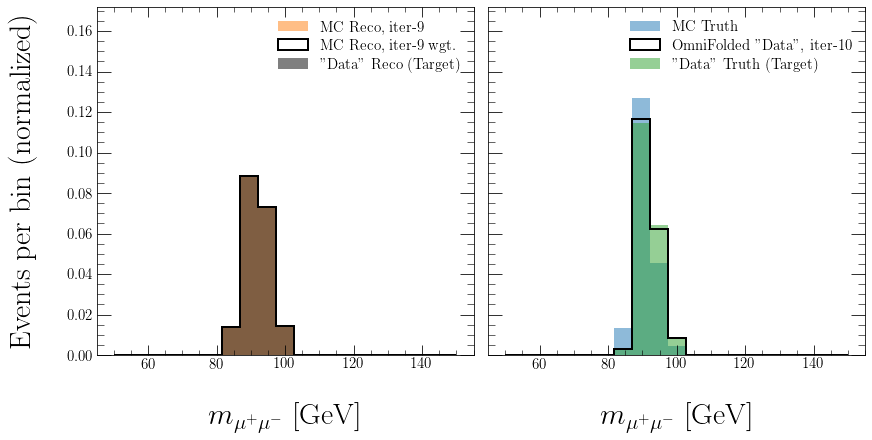

In [76]:
bins = np.linspace(50, 150, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = np.ones(len(m_ll_sim_reco))
        label0 = ''
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    ax[0].hist(m_ll_sim_reco,
               weights=weights_init,
               bins=bins,
               label='MC Reco' + label0,
               **plot_style_2,
               color='C1')

    ax[0].hist(m_ll_sim_reco,
               bins=bins,
               label='MC Reco' + label0 + ' wgt.',
               weights=weights[i, 0, :],
               **plot_style_1)
    hR, _, _ = ax[0].hist(m_ll_data_reco,
                          weights=weights_m_ll_stress,
                          bins=bins,
                          label='"Data" Reco (Target)',
                          **plot_style_2,
                          color='k')
    ax[0].set_xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend()
    ax[1].hist(m_ll_sim_truth, bins=bins, label=r'MC Truth', **plot_style_2)

    ax[1].hist(m_ll_sim_truth,
               bins=bins,
               label='OmniFolded "Data"' + label1,
               weights=weights[i, 1, :],
               **plot_style_1)
    hT, _, _ = ax[1].hist(m_ll_data_truth,
                          weights=weights_m_ll_stress,
                          bins=bins,
                          label='"Data" Truth (Target)',
                          **plot_style_2,
                          color='C2')
    ax[1].legend()
    ax[1].set_xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")

    plt.ylim([0, 1.5 * max(max(hT), max(hR))])
    fig.show()
#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-UniFold-m_ll-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    plt.show()

### Unfold Number of Charged Particles

In [77]:
# z-score standardization

scaler_truth = preprocessing.StandardScaler()
scaler_reco = preprocessing.StandardScaler()

scaler_truth.fit(Ntracks_sim_truth.reshape(-1,1))
scaler_reco.fit(np.concatenate((Ntracks_sim_reco, Ntracks_data_reco)).reshape(-1,1))

sim_truth = np.squeeze(scaler_truth.transform(Ntracks_sim_truth.reshape(-1,1)))
sim_reco = np.squeeze(scaler_reco.transform(Ntracks_sim_reco.reshape(-1,1)))
data_reco = np.squeeze(scaler_reco.transform(Ntracks_data_reco.reshape(-1,1)))

In [78]:
weights, _ = unifold(iterations=10,
                     sim_truth=sim_truth,
                     sim_reco=sim_reco,
                     data_reco=data_reco,
                     weights_MC_data=weights_Ntracks_stress)


ITERATION: 1

STEP 1

Epoch 1/200
42/42 [==============================] - 0s 7ms/step - loss: 0.6824 - accuracy: 0.3635 - val_loss: 0.6800 - val_accuracy: 0.3845
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.3861 - val_loss: 0.6800 - val_accuracy: 0.3915
Epoch 3/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.3853 - val_loss: 0.6799 - val_accuracy: 0.3845
Epoch 4/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.3863 - val_loss: 0.6798 - val_accuracy: 0.3845
Epoch 5/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.3846 - val_loss: 0.6798 - val_accuracy: 0.3812
Epoch 6/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.3827 - val_loss: 0.6798 - val_accuracy: 0.3812
Epoch 7/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.3835 - val_loss: 0.6800 - val_accurac

42/42 [==============================] - 0s 4ms/step - loss: 0.6956 - accuracy: 0.2500 - val_loss: 0.6953 - val_accuracy: 0.2491
Epoch 11/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6956 - accuracy: 0.2501 - val_loss: 0.6953 - val_accuracy: 0.2492
Epoch 12/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6956 - accuracy: 0.2501 - val_loss: 0.6953 - val_accuracy: 0.2491
Epoch 00012: early stopping

STEP 2

Epoch 1/200
42/42 [==============================] - 0s 6ms/step - loss: 0.6797 - accuracy: 0.3766 - val_loss: 0.6789 - val_accuracy: 0.3763
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.3749 - val_loss: 0.6789 - val_accuracy: 0.3741
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.3747 - val_loss: 0.6790 - val_accuracy: 0.3763
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.3748 - val_loss: 0.6789 - val_acc

42/42 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.3732 - val_loss: 0.6759 - val_accuracy: 0.3736
Epoch 8/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.3732 - val_loss: 0.6760 - val_accuracy: 0.3712
Epoch 9/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6763 - accuracy: 0.3721 - val_loss: 0.6760 - val_accuracy: 0.3712
Epoch 10/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6763 - accuracy: 0.3722 - val_loss: 0.6759 - val_accuracy: 0.3759
Epoch 11/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.3732 - val_loss: 0.6759 - val_accuracy: 0.3736
Epoch 12/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.3726 - val_loss: 0.6759 - val_accuracy: 0.3736
Epoch 13/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.3730 - val_loss: 0.6759 - val_accuracy: 0.3736
Epoch 14/200
42/42 [=

42/42 [==============================] - 0s 3ms/step - loss: 0.6886 - accuracy: 0.2500 - val_loss: 0.6901 - val_accuracy: 0.2494
Epoch 15/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.2501 - val_loss: 0.6901 - val_accuracy: 0.2499
Epoch 16/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.2500 - val_loss: 0.6901 - val_accuracy: 0.2494
Epoch 00016: early stopping

STEP 2

Epoch 1/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6789 - accuracy: 0.3587 - val_loss: 0.6728 - val_accuracy: 0.3681
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6720 - accuracy: 0.3725 - val_loss: 0.6727 - val_accuracy: 0.3729
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6719 - accuracy: 0.3730 - val_loss: 0.6727 - val_accuracy: 0.3729
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6719 - accuracy: 0.3705 - val_loss: 0.6727 - val_acc

Epoch 11/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.2504 - val_loss: 0.6908 - val_accuracy: 0.2498
Epoch 12/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.2499 - val_loss: 0.6908 - val_accuracy: 0.2496
Epoch 13/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.2502 - val_loss: 0.6908 - val_accuracy: 0.2496
Epoch 14/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.2500 - val_loss: 0.6908 - val_accuracy: 0.2498
Epoch 15/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.2501 - val_loss: 0.6908 - val_accuracy: 0.2496
Epoch 00015: early stopping

STEP 2

Epoch 1/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6768 - accuracy: 0.3641 - val_loss: 0.6687 - val_accuracy: 0.3662
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6695 - accuracy: 0.3708 - val_loss: 0

42/42 [==============================] - 0s 4ms/step - loss: 0.6773 - accuracy: 0.3649 - val_loss: 0.6691 - val_accuracy: 0.3687
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.3718 - val_loss: 0.6690 - val_accuracy: 0.3736
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.3727 - val_loss: 0.6690 - val_accuracy: 0.3712
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.3708 - val_loss: 0.6690 - val_accuracy: 0.3712
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.3706 - val_loss: 0.6690 - val_accuracy: 0.3712
Epoch 6/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.3706 - val_loss: 0.6690 - val_accuracy: 0.3736
Epoch 7/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.3715 - val_loss: 0.6690 - val_accuracy: 0.3712
Epoch 8/200
42/42 [======

42/42 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.2504 - val_loss: 0.6930 - val_accuracy: 0.2504
Epoch 11/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.2499 - val_loss: 0.6930 - val_accuracy: 0.2502
Epoch 12/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.2502 - val_loss: 0.6930 - val_accuracy: 0.2505
Epoch 13/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.2501 - val_loss: 0.6930 - val_accuracy: 0.2505
Epoch 00013: early stopping

STEP 2

Epoch 1/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6759 - accuracy: 0.3662 - val_loss: 0.6693 - val_accuracy: 0.3710
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6684 - accuracy: 0.3730 - val_loss: 0.6690 - val_accuracy: 0.3733
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6683 - accuracy: 0.3731 - val_loss: 0.6690 - val_ac

#### Results

ITERATION 1:


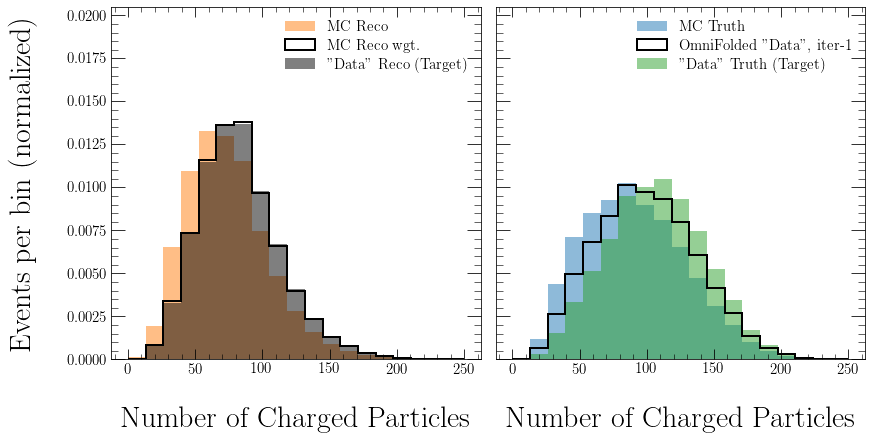

ITERATION 2:


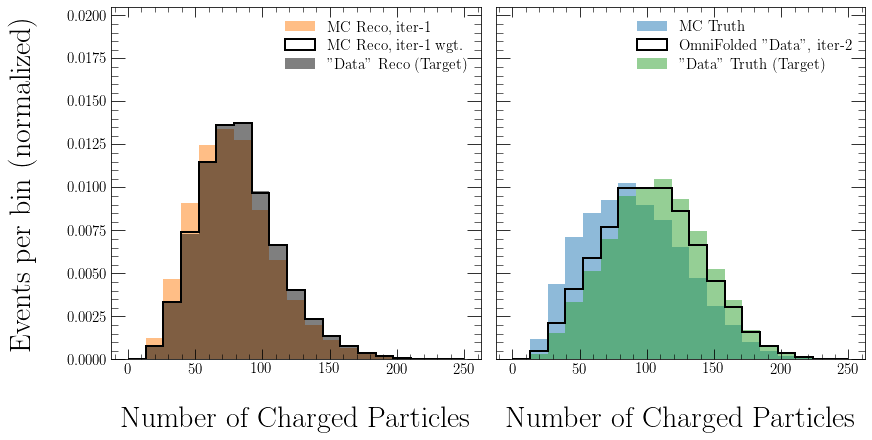

ITERATION 3:


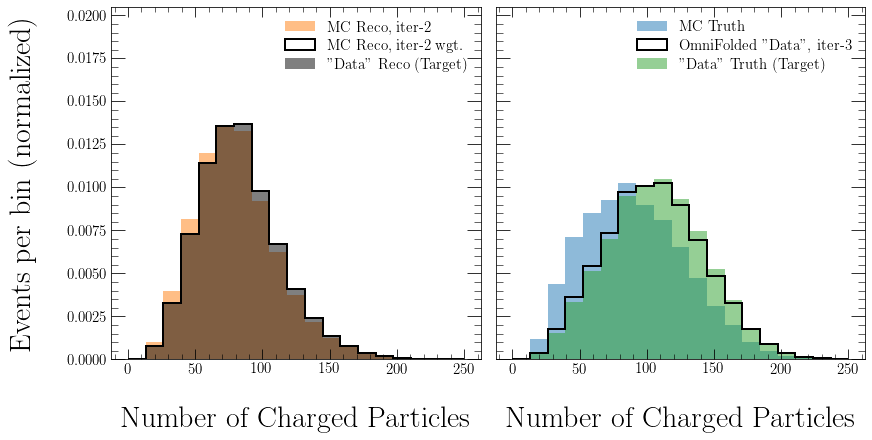

ITERATION 4:


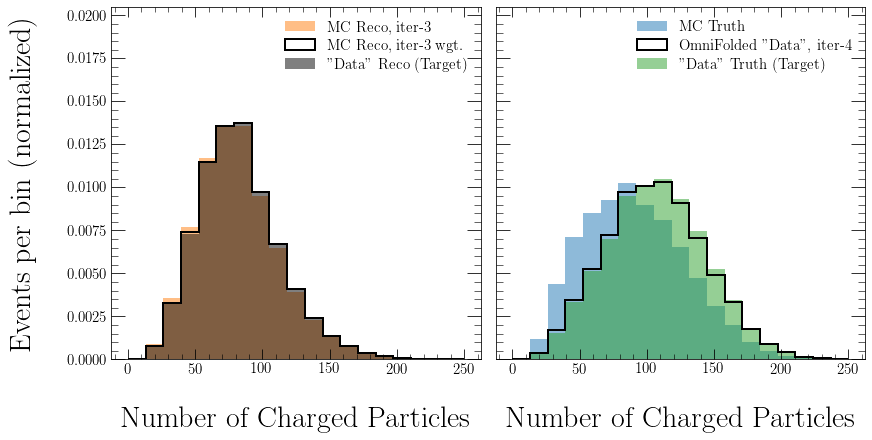

ITERATION 5:


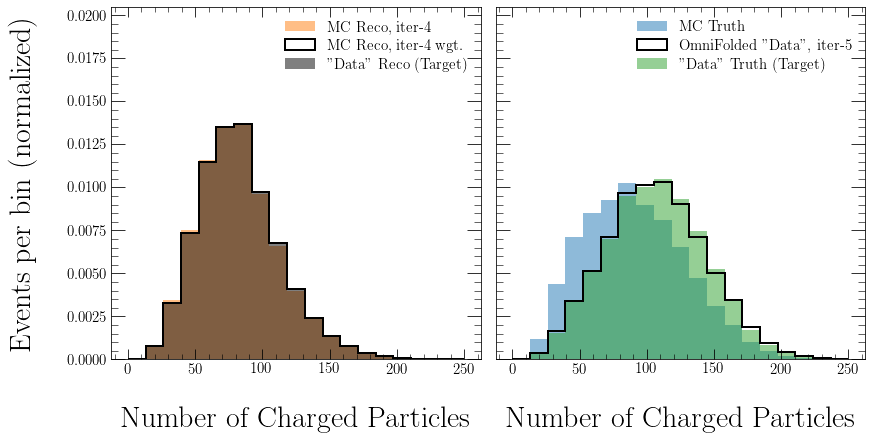

ITERATION 6:


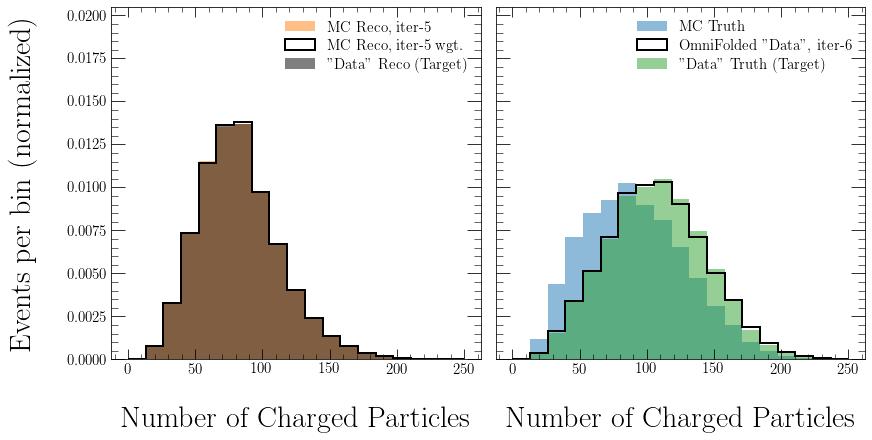

ITERATION 7:


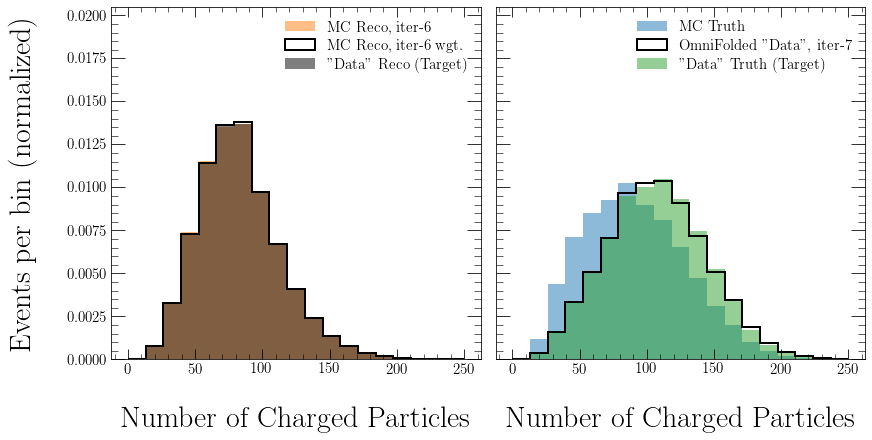

ITERATION 8:


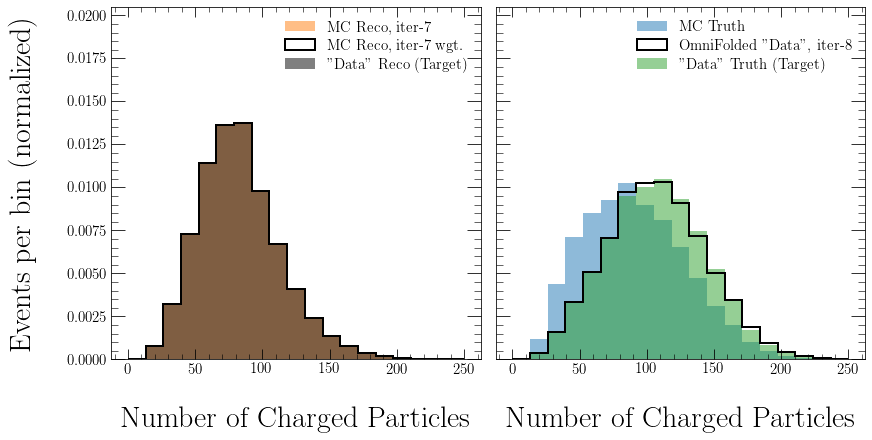

ITERATION 9:


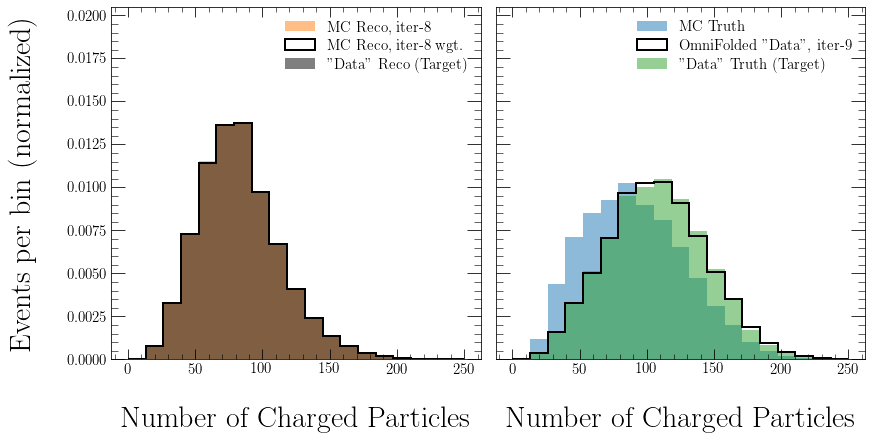

ITERATION 10:


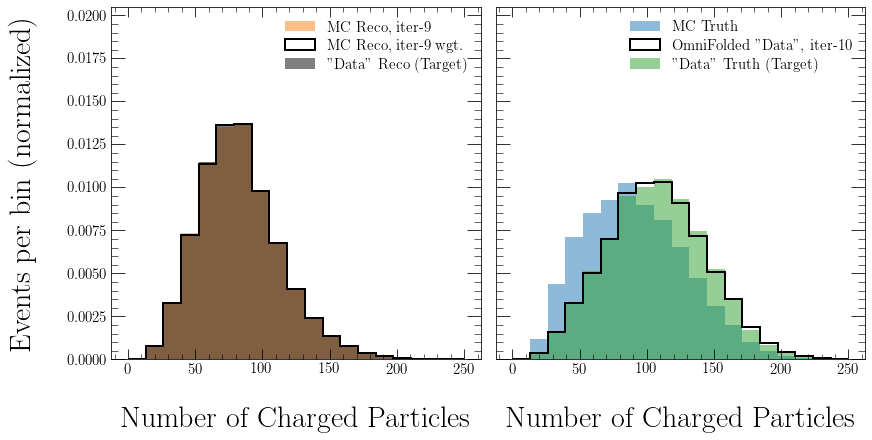

In [79]:
bins = np.linspace(0, 250, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = np.ones(len(Ntracks_sim_reco))
        label0 = ''
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    ax[0].hist(Ntracks_sim_reco,
               weights=weights_init,
               bins=bins,
               label='MC Reco' + label0,
               **plot_style_2,
               color='C1')

    ax[0].hist(Ntracks_sim_reco,
               bins=bins,
               label='MC Reco' + label0 + ' wgt.',
               weights=weights[i, 0, :],
               **plot_style_1)
    hR, _, _ = ax[0].hist(Ntracks_data_reco,
                          weights=weights_Ntracks_stress,
                          bins=bins,
                          label='"Data" Reco (Target)',
                          **plot_style_2,
                          color='k')
    ax[0].set_xlabel(r"Number of Charged Particles")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend()
    ax[1].hist(Ntracks_sim_truth, bins=bins, label=r'MC Truth', **plot_style_2)

    ax[1].hist(Ntracks_sim_truth,
               bins=bins,
               label='OmniFolded "Data"' + label1,
               weights=weights[i, 1, :],
               **plot_style_1)
    hT, _, _ = ax[1].hist(Ntracks_data_truth,
                          weights=weights_Ntracks_stress,
                          bins=bins,
                          label='"Data" Truth (Target)',
                          **plot_style_2,
                          color='C2')
    ax[1].legend()
    ax[1].set_xlabel(r"Number of Charged Particles")

    plt.ylim([0, 1.5 * max(max(hT), max(hR))])
    fig.show()
#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-UniFold-Ntracks-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    plt.show()

## MultiFold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles simultaneously.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the synthetic dataset, and the other half as the unknown "natural" dataset.

In [80]:
K.clear_session()

### Setup datasets

In [81]:
m_ll_sim_truth, m_ll_data_truth, m_ll_sim_reco, m_ll_data_reco, Ntracks_sim_truth, Ntracks_data_truth, Ntracks_sim_reco, Ntracks_data_reco = train_test_split(
    Events_0.events['truth_m_ll'][mypass_0],
    Events_0.events['m_ll'][mypass_0],
    Events_0.events['truth_Ntracks'][mypass_0],
    Events_0.events['Ntracks'][mypass_0],
    test_size=0.5)

In [82]:
scaler_m_ll = preprocessing.StandardScaler()
scaler_m_ll.fit(np.concatenate((m_ll_sim_truth, m_ll_data_truth)).reshape(-1,1))

scaler_Ntracks = preprocessing.StandardScaler()
scaler_Ntracks.fit(np.concatenate((Ntracks_sim_truth, Ntracks_data_truth)).reshape(-1,1))

weight_m_ll_seed = np.squeeze(scaler_m_ll.transform(m_ll_data_truth.reshape(-1,1)))
weight_Ntracks_seed = np.squeeze(scaler_Ntracks.transform(Ntracks_data_truth.reshape(-1,1)))

weight_seed = weight_m_ll_seed + weight_Ntracks_seed

In [83]:
weights_stress = [
    abs(np.random.normal(0, sigmoid(std))) for std in weight_seed
]
weights_stress = np.array(weights_stress)
weights_stress = weights_stress / np.mean(weights_stress)

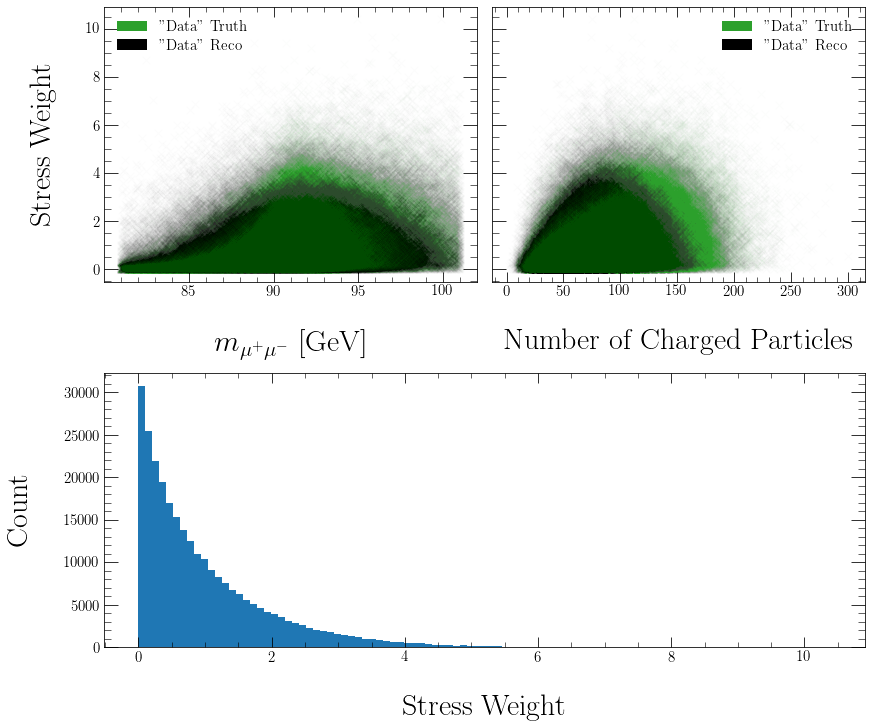

In [84]:
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(m_ll_data_reco,
         weights_stress,
         'x',
         alpha=0.01,
         color='k',
         label='"Data" Reco')
ax0.plot(m_ll_data_truth,
         weights_stress,
         'x',
         alpha=0.01,
         color='C2',
         label='"Data" Truth')
ax0.set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax0.set_ylabel('Stress Weight')

ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
plt.setp(ax1.get_yticklabels(), visible=False)
ax1.plot(Ntracks_data_reco,
         weights_stress,
         'x',
         alpha=0.01,
         color='k',
         label='"Data" Reco')
ax1.plot(Ntracks_data_truth,
         weights_stress,
         'x',
         alpha=0.01,
         color='C2',
         label='"Data" Truth')
ax1.set_xlabel('Number of Charged Particles')

handles = [Patch(facecolor='C2'), Patch(facecolor='k')]
labels = ['"Data" Truth', '"Data" Reco']
ax0.legend(handles, labels)
ax1.legend(handles, labels)

ax2 = fig.add_subplot(gs[1, :])
ax2.hist(weights_stress,
         bins=np.linspace(np.min(weights_stress), np.max(weights_stress), 100))
ax2.set_xlabel('Stress Weight')
ax2.set_ylabel('Count')

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-MultiFold-StressWeights.png',
#     bbox_inches='tight')

fig.show()

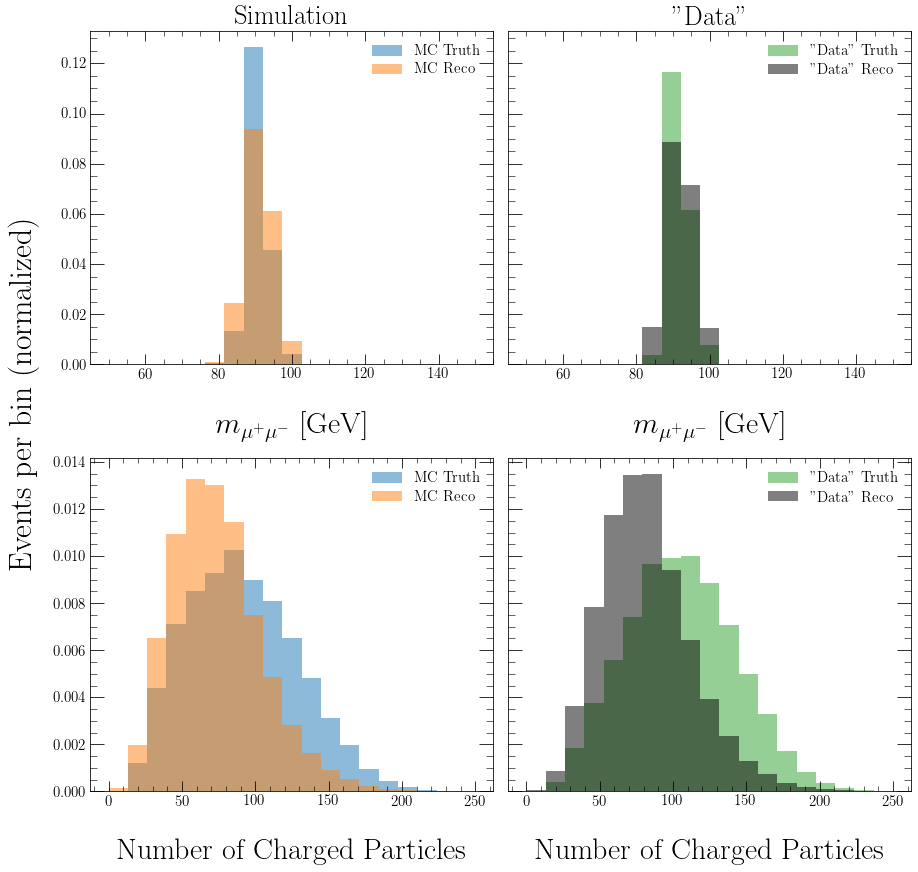

In [85]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 12),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(50, 150, 20)

ax[0, 0].set_title('Simulation')
ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG0, _, _ = ax[0, 0].hist(m_ll_sim_truth,
                          bins=bins,
                          label='MC Truth',
                          **plot_style_2,
                          color='C0')
hS0, _, _ = ax[0, 0].hist(m_ll_sim_reco,
                          bins=bins,
                          label='MC Reco',
                          **plot_style_2,
                          color='C1')
legend = ax[0, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Data"')
ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[0, 1].hist(m_ll_data_truth,
                          weights=weights_stress,
                          bins=bins,
                          label='"Data" Truth',
                          **plot_style_2,
                          color='C2')
hS1, _, _ = ax[0, 1].hist(m_ll_data_reco,
                          weights=weights_stress,
                          bins=bins,
                          label='"Data" Reco',
                          **plot_style_2,
                          color='k')
legend = ax[0, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

bins = np.linspace(0, 250, 20)

ax[1, 0].set_xlabel('Number of Charged Particles')
hG0, _, _ = ax[1, 0].hist(Ntracks_sim_truth,
                          bins=bins,
                          label='MC Truth',
                          **plot_style_2,
                          color='C0')
hS0, _, _ = ax[1, 0].hist(Ntracks_sim_reco,
                          bins=bins,
                          label='MC Reco',
                          **plot_style_2,
                          color='C1')
legend = ax[1, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1, 1].hist(Ntracks_data_truth,
                          weights=weights_stress,
                          bins=bins,
                          label='"Data" Truth',
                          **plot_style_2,
                          color='C2')
hS1, _, _ = ax[1, 1].hist(Ntracks_data_reco,
                          weights=weights_stress,
                          bins=bins,
                          label='"Data" Reco',
                          **plot_style_2,
                          color='k')
legend = ax[1, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.text(-0.05,
         0.55,
         'Events per bin (normalized)',
         va='center',
         rotation='vertical',
         fontsize='x-large')
# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-MultiFold-Distributions.pdf', 
#     bbox_inches='tight')
fig.show()

### Unfold $m_{\mu^+\mu^-}$ and Number of Charged Particles Simultaneously

In [86]:
# z-score standardization

num_observables = 2

scaler_m_ll_truth = preprocessing.StandardScaler()
scaler_m_ll_reco = preprocessing.StandardScaler()

scaler_m_ll_truth.fit(m_ll_sim_truth.reshape(-1,1))
scaler_m_ll_reco.fit(np.concatenate((m_ll_sim_reco, m_ll_data_reco)).reshape(-1,1))

scaler_Ntracks_truth = preprocessing.StandardScaler()
scaler_Ntracks_reco = preprocessing.StandardScaler()

scaler_Ntracks_truth.fit(Ntracks_sim_truth.reshape(-1,1))
scaler_Ntracks_reco.fit(np.concatenate((Ntracks_sim_reco, Ntracks_data_reco)).reshape(-1,1))

sim_truth = (np.squeeze(scaler_m_ll_truth.transform(m_ll_sim_truth.reshape(-1,1))),
             np.squeeze(scaler_Ntracks_truth.transform(Ntracks_sim_truth.reshape(-1,1))))

sim_reco = (np.squeeze(scaler_m_ll_reco.transform(m_ll_sim_reco.reshape(-1,1))),
             np.squeeze(scaler_Ntracks_reco.transform(Ntracks_sim_reco.reshape(-1,1))))

data_reco = (np.squeeze(scaler_m_ll_reco.transform(m_ll_data_reco.reshape(-1,1))),
                   np.squeeze(scaler_Ntracks_reco.transform(Ntracks_data_reco.reshape(-1,1))))

In [87]:
weights, _ = multifold(num_observables=num_observables,
                       iterations=10,
                       sim_truth=sim_truth,
                       sim_reco=sim_reco,
                       data_reco=data_reco,
                       weights_MC_data=weights_stress)


ITERATION: 1

STEP 1

Epoch 1/200
42/42 [==============================] - 0s 5ms/step - loss: 0.6789 - accuracy: 0.3606 - val_loss: 0.6767 - val_accuracy: 0.3791
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6746 - accuracy: 0.3822 - val_loss: 0.6764 - val_accuracy: 0.3807
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6744 - accuracy: 0.3840 - val_loss: 0.6762 - val_accuracy: 0.3872
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6744 - accuracy: 0.3823 - val_loss: 0.6763 - val_accuracy: 0.3840
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.3824 - val_loss: 0.6763 - val_accuracy: 0.3853
Epoch 6/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.3821 - val_loss: 0.6765 - val_accuracy: 0.3761
Epoch 7/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.3824 - val_loss: 0.6763 - val_accurac

42/42 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.3808 - val_loss: 0.6846 - val_accuracy: 0.3800
Epoch 00014: early stopping

ITERATION: 2

STEP 1

Epoch 1/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.2502 - val_loss: 0.6834 - val_accuracy: 0.2502
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.2503 - val_loss: 0.6834 - val_accuracy: 0.2501
Epoch 3/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.2503 - val_loss: 0.6834 - val_accuracy: 0.2502
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.2501 - val_loss: 0.6833 - val_accuracy: 0.2502
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.2503 - val_loss: 0.6834 - val_accuracy: 0.2502
Epoch 6/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6861 - accuracy: 0.2502 - val_loss: 0.68

42/42 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.2501 - val_loss: 0.6878 - val_accuracy: 0.2499
Epoch 13/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.2505 - val_loss: 0.6878 - val_accuracy: 0.2500
Epoch 14/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.2503 - val_loss: 0.6878 - val_accuracy: 0.2501
Epoch 00014: early stopping

STEP 2

Epoch 1/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6683 - accuracy: 0.3773 - val_loss: 0.6655 - val_accuracy: 0.3740
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6655 - accuracy: 0.3707 - val_loss: 0.6654 - val_accuracy: 0.3726
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6654 - accuracy: 0.3705 - val_loss: 0.6655 - val_accuracy: 0.3737
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6654 - accuracy: 0.3700 - val_loss: 0.6655 - val_acc

Epoch 13/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.2504 - val_loss: 0.6936 - val_accuracy: 0.2501
Epoch 00013: early stopping

STEP 2

Epoch 1/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6681 - accuracy: 0.3787 - val_loss: 0.6605 - val_accuracy: 0.3783
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.3731 - val_loss: 0.6599 - val_accuracy: 0.3731
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6593 - accuracy: 0.3728 - val_loss: 0.6598 - val_accuracy: 0.3693
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6593 - accuracy: 0.3709 - val_loss: 0.6598 - val_accuracy: 0.3732
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6593 - accuracy: 0.3716 - val_loss: 0.6598 - val_accuracy: 0.3715
Epoch 6/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6593 - accuracy: 0.3715 - val_loss: 0.659

42/42 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.3712 - val_loss: 0.6554 - val_accuracy: 0.3722
Epoch 15/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.3703 - val_loss: 0.6554 - val_accuracy: 0.3729
Epoch 16/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.3715 - val_loss: 0.6554 - val_accuracy: 0.3708
Epoch 00016: early stopping

ITERATION: 7

STEP 1

Epoch 1/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6953 - accuracy: 0.2505 - val_loss: 0.6892 - val_accuracy: 0.2496
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.2501 - val_loss: 0.6889 - val_accuracy: 0.2500
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.2500 - val_loss: 0.6889 - val_accuracy: 0.2502
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.2500 - val_loss: 0.

Epoch 00013: early stopping

ITERATION: 9

STEP 1

Epoch 1/200
42/42 [==============================] - 0s 4ms/step - loss: 0.7025 - accuracy: 0.2497 - val_loss: 0.6945 - val_accuracy: 0.2500
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.2498 - val_loss: 0.6943 - val_accuracy: 0.2495
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.2502 - val_loss: 0.6944 - val_accuracy: 0.2489
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.2506 - val_loss: 0.6944 - val_accuracy: 0.2493
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.2506 - val_loss: 0.6944 - val_accuracy: 0.2489
Epoch 6/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.2508 - val_loss: 0.6944 - val_accuracy: 0.2490
Epoch 7/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.2509 - va

Epoch 10/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.3720 - val_loss: 0.6547 - val_accuracy: 0.3751
Epoch 11/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.3738 - val_loss: 0.6547 - val_accuracy: 0.3731
Epoch 12/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.3726 - val_loss: 0.6548 - val_accuracy: 0.3732
Epoch 00012: early stopping


#### Results

ITERATION: 1


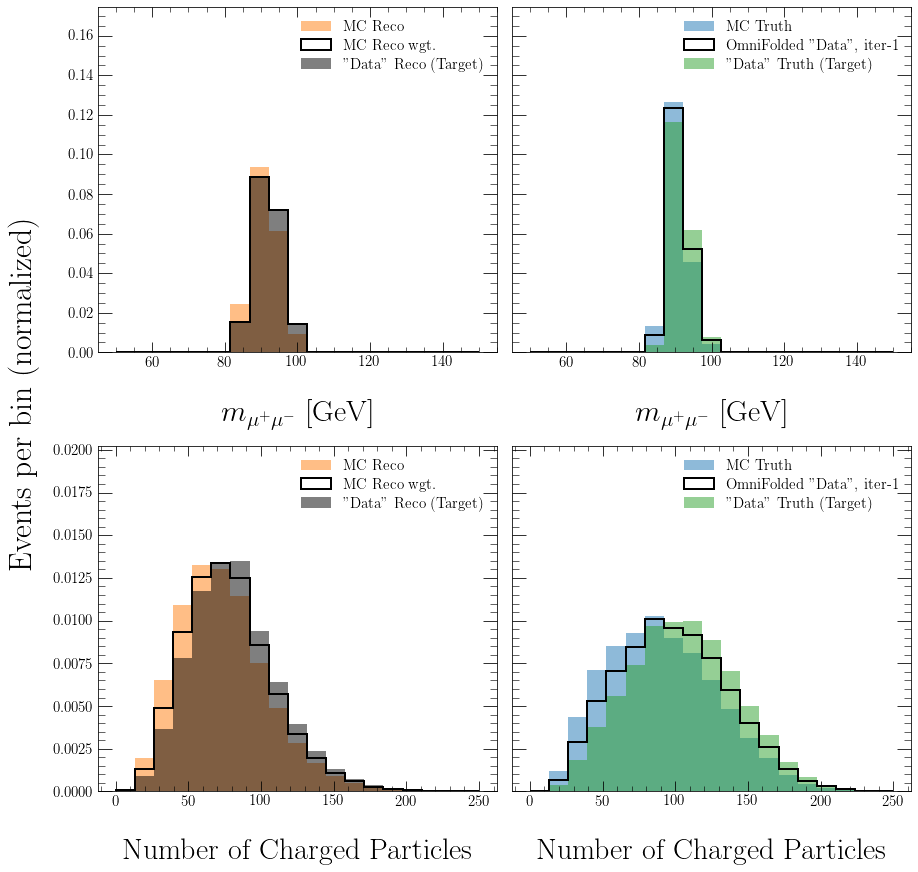

ITERATION: 2


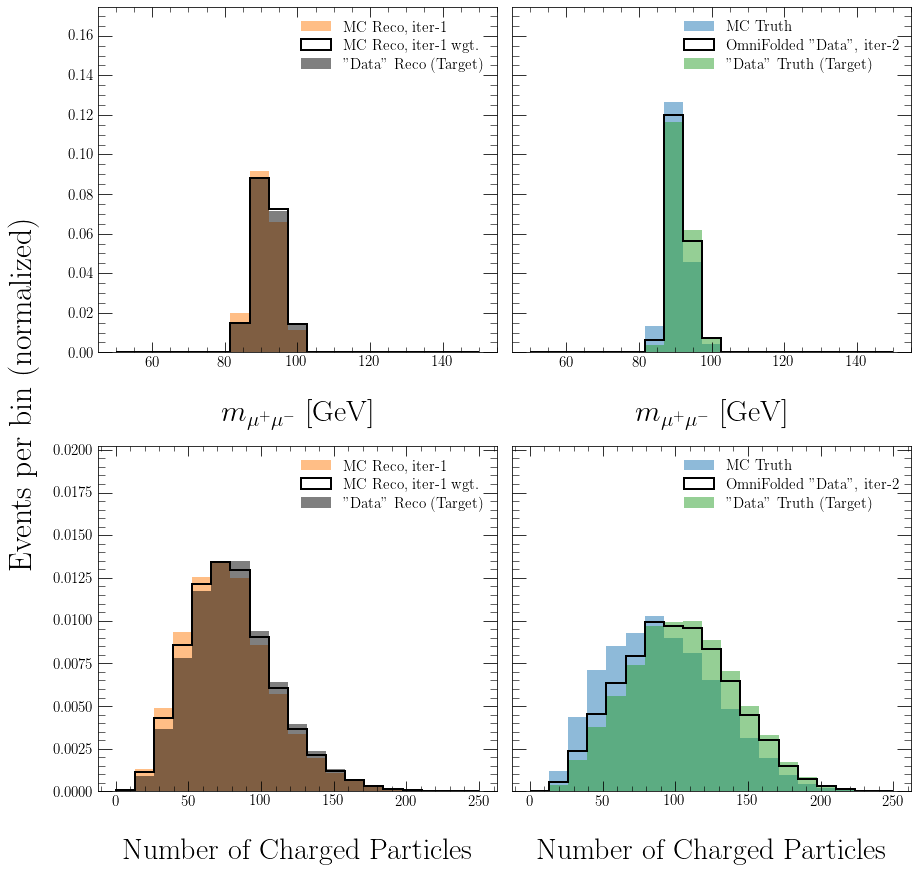

ITERATION: 3


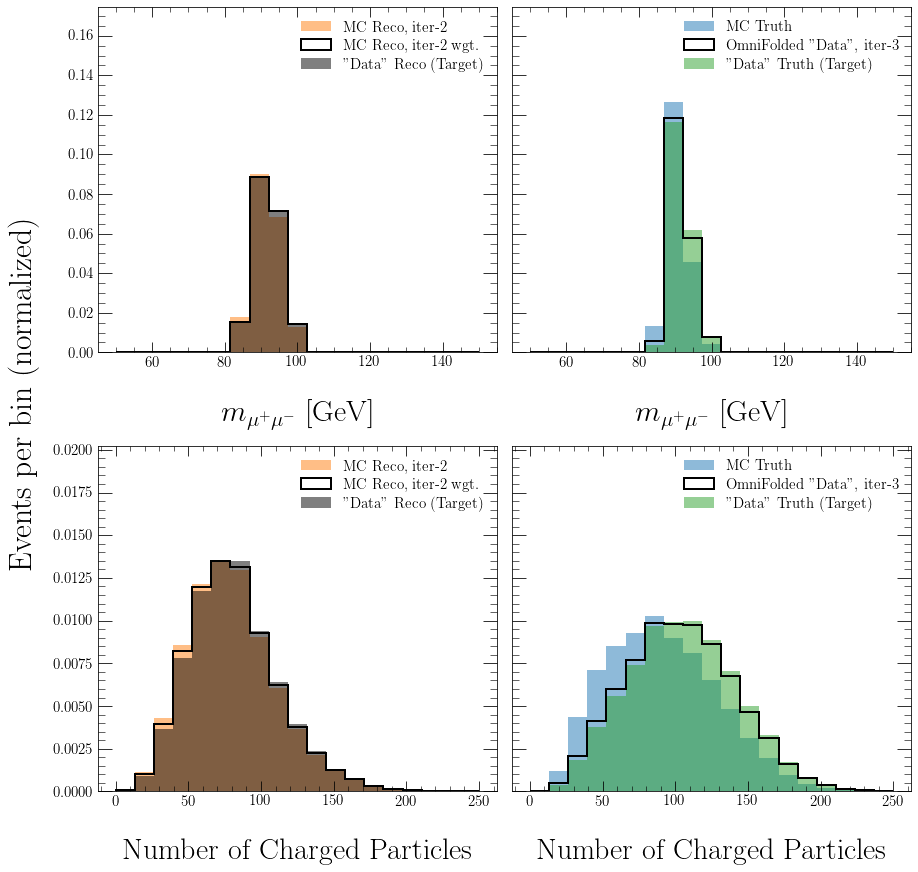

ITERATION: 4


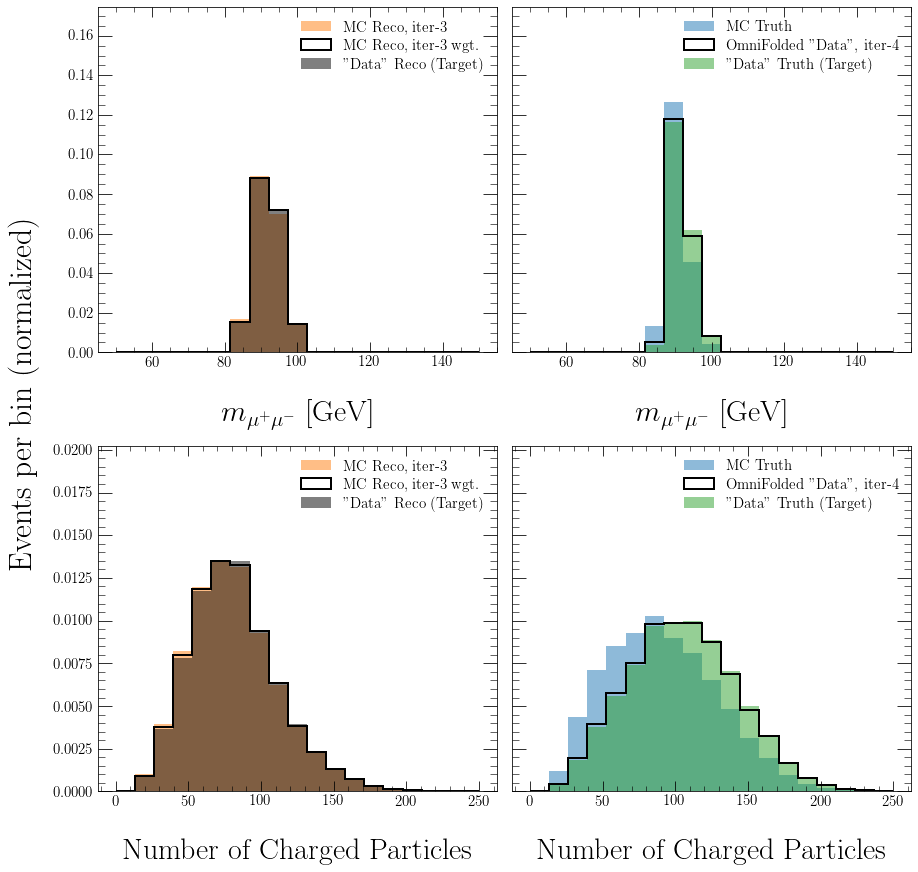

ITERATION: 5


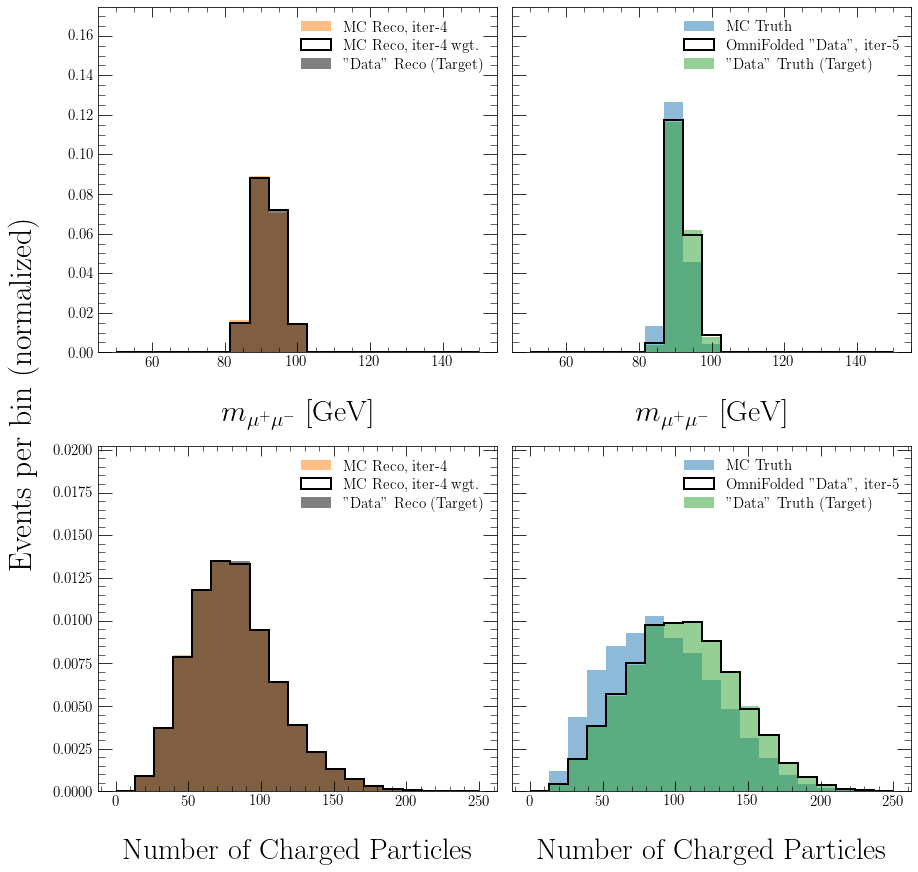

ITERATION: 6


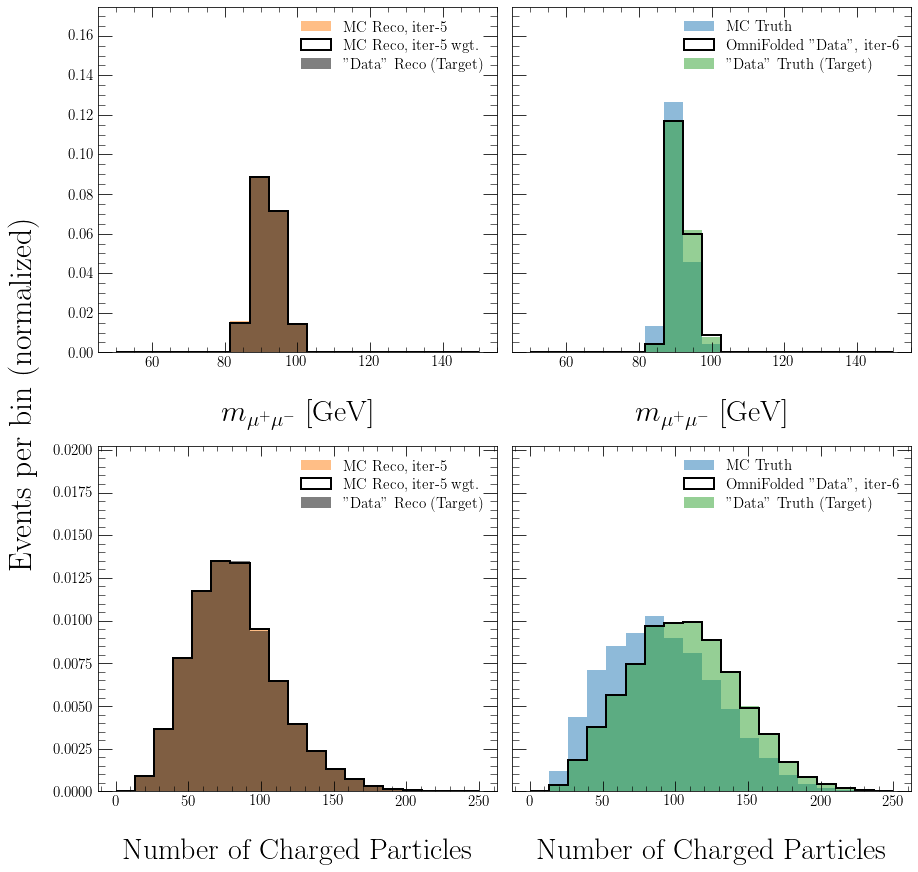

ITERATION: 7


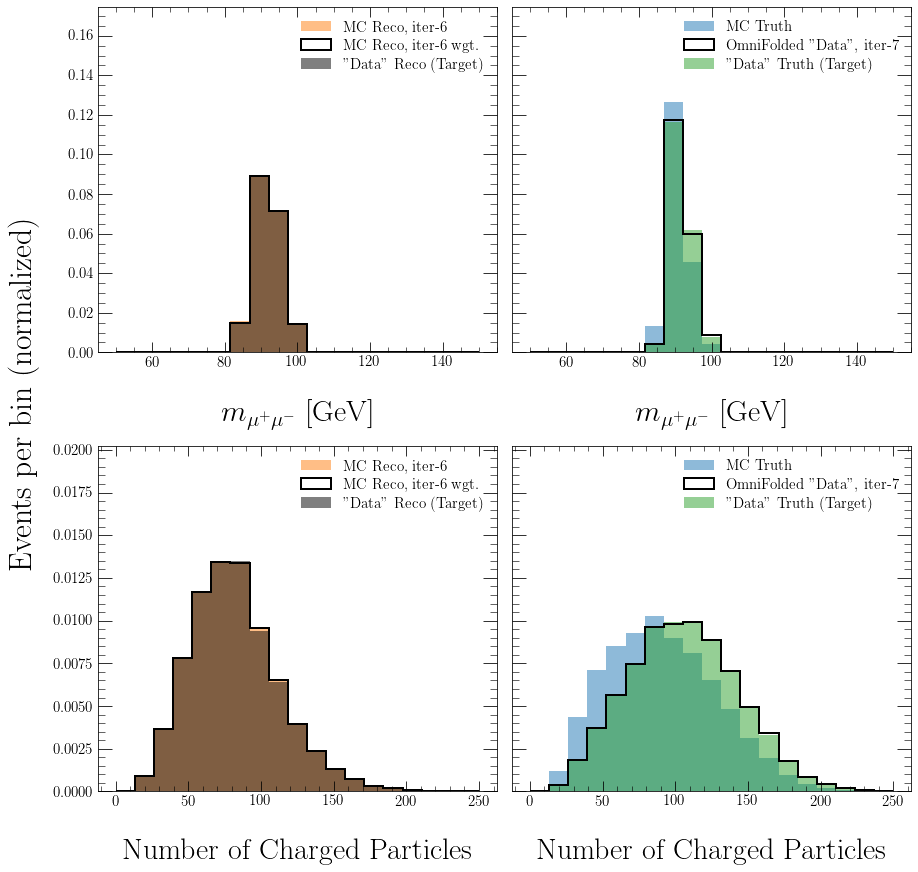

ITERATION: 8


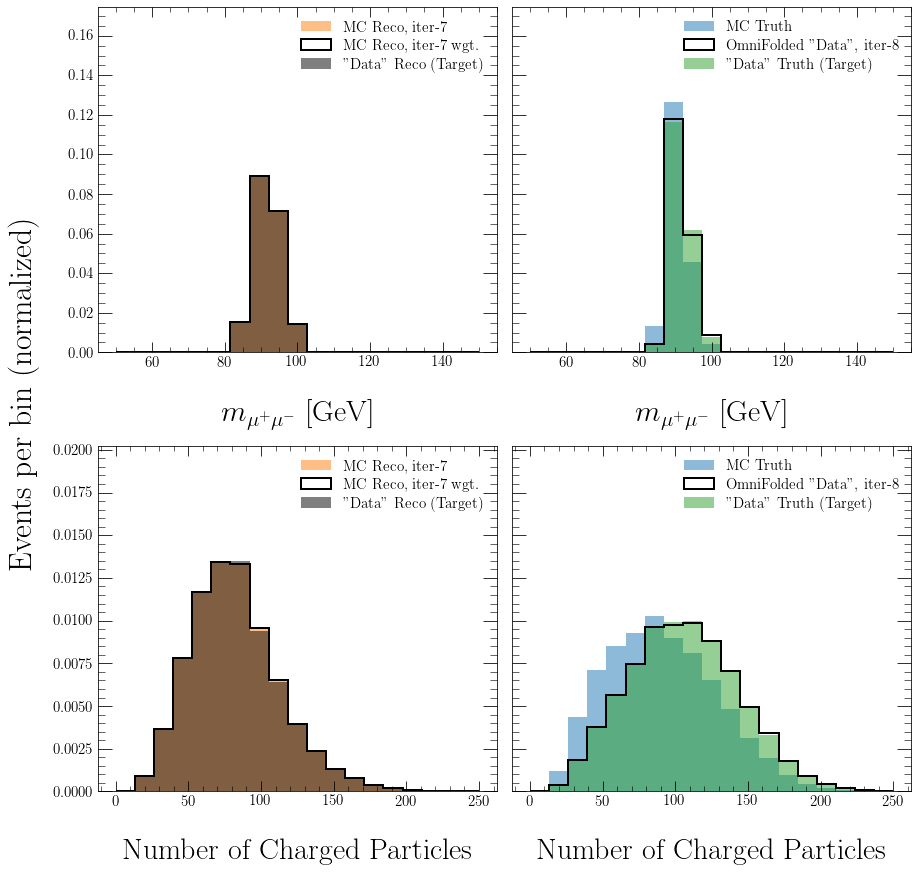

ITERATION: 9


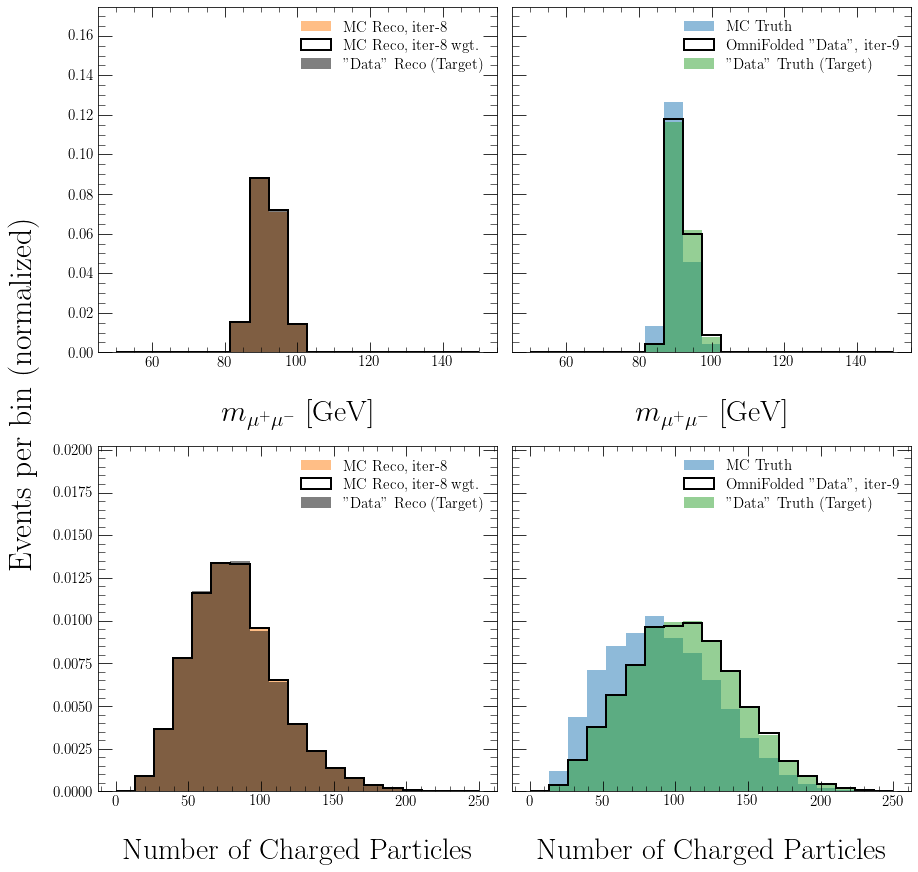

ITERATION: 10


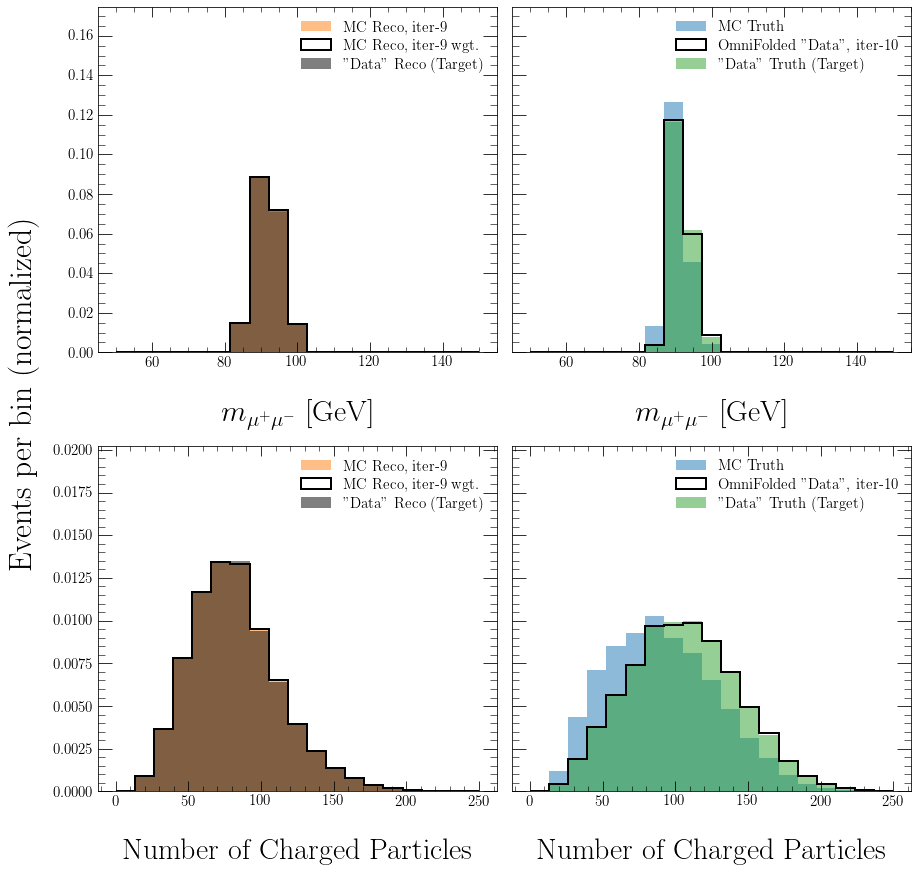

In [88]:
for i in range(len(weights)):
    if i == 0:
        weights_init = np.ones(len(weights[i - 1, 1, :]))
        label0 = ''.format(i)
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(50, 150, 20)

    fig, ax = plt.subplots(num_observables,
                           2,
                           figsize=(12, 12),
                           constrained_layout=True,
                           sharey='row')

    ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0, 0].hist(m_ll_sim_reco,
                  weights=weights_init,
                  bins=bins,
                  label='MC Reco' + label0,
                  **plot_style_2,
                  color='C1')
    ax[0, 0].hist(m_ll_sim_reco,
                  bins=bins,
                  weights=weights[i, 0, :],
                  label='MC Reco' + label0 + ' wgt.',
                  **plot_style_1)

    hR0, _, _ = ax[0, 0].hist(m_ll_data_reco,
                              weights=weights_stress,
                              bins=bins,
                              label=r'"Data" Reco (Target)',
                              **plot_style_2,
                              color='k')
    ax[0, 0].legend(frameon=False)
    

    ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0, 1].hist(m_ll_sim_truth,
                  bins=bins,
                  label=r'MC Truth',
                  **plot_style_2,
                  color='C0')
    ax[0, 1].hist(m_ll_sim_truth,
                  bins=bins,
                  weights=weights[i, 1, :],
                  label='OmniFolded "Data"' + label1,
                  **plot_style_1)

    hT0, _, _ = ax[0, 1].hist(m_ll_data_truth,
                              weights=weights_stress,
                              bins=bins,
                              label=r'"Data" Truth (Target)',
                              **plot_style_2,
                              color='C2')
    ax[0, 0].set_ylim([0, 1.5 * np.max(np.concatenate((hT0, hR0)))])
    ax[0, 1].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1, 0].set_xlabel('Number of Charged Particles')
    ax[1, 0].hist(Ntracks_sim_reco,
                  weights=weights_init,
                  bins=bins,
                  label='MC Reco' + label0,
                  **plot_style_2,
                  color='C1')
    ax[1, 0].hist(Ntracks_sim_reco,
                  bins=bins,
                  weights=weights[i, 1, :],
                  label='MC Reco' + label0 + ' wgt.',
                  **plot_style_1)
    hR1, _, _ = ax[1, 0].hist(Ntracks_data_reco,
                              weights=weights_stress,
                              bins=bins,
                              label=r'"Data" Reco (Target)',
                              **plot_style_2,
                              color='k')
    ax[1, 0].legend(frameon=False)

    ax[1, 1].set_xlabel('Number of Charged Particles')
    ax[1, 1].hist(Ntracks_sim_truth,
                  bins=bins,
                  label=r'MC Truth',
                  **plot_style_2,
                  color='C0')
    ax[1, 1].hist(Ntracks_sim_truth,
                  bins=bins,
                  weights=weights[i, 1, :],
                  label='OmniFolded "Data"' + label1,
                  **plot_style_1)
    hT1, _, _ = ax[1, 1].hist(Ntracks_data_truth,
                              weights=weights_stress,
                              bins=bins,
                              label=r'"Data" Truth (Target)',
                              **plot_style_2,
                              color='C2')
    ax[1, 1].legend(frameon=False)

    fig.text(-0.05,
             0.55,
             'Events per bin (normalized)',
             va='center',
             rotation='vertical',
             fontsize='x-large')

    ax[1, 0].set_ylim([0, 1.5 * np.max(np.concatenate((hT1, hR1)))])

#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-MultiFold-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    fig.show()
    plt.show()